## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


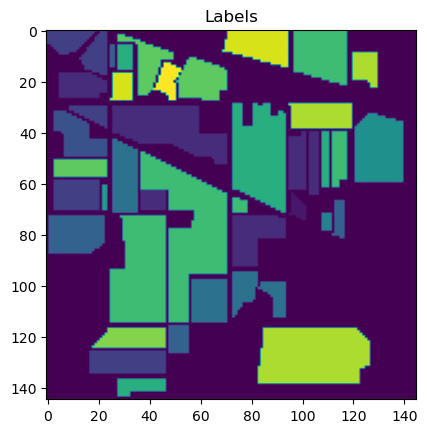

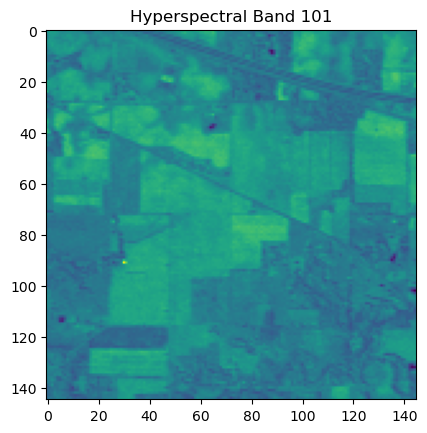

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(320, 5, 5, 200)
(75, 5, 5, 200)
(9854, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0774, PSNR: 10.6304


Epoch [1/50] Training Loss: 0.0642, PSNR: 11.4906
	[Val]   Batch [1/33] Loss: 0.0493, PSNR: 12.7327
	[Val]   Batch [10/33] Loss: 0.0488, PSNR: 12.3847
	[Val]   Batch [20/33] Loss: 0.0484, PSNR: 11.9854
	[Val]   Batch [30/33] Loss: 0.0471, PSNR: 12.3479
Epoch [1/50] Validation Loss: 0.0491, PSNR: 12.5467

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0489, PSNR: 12.5725


Epoch [2/50] Training Loss: 0.0389, PSNR: 13.6849
	[Val]   Batch [1/33] Loss: 0.0283, PSNR: 15.1508
	[Val]   Batch [10/33] Loss: 0.0278, PSNR: 14.8310
	[Val]   Batch [20/33] Loss: 0.0275, PSNR: 14.4391
	[Val]   Batch [30/33] Loss: 0.0267, PSNR: 14.8061
Epoch [2/50] Validation Loss: 0.0282, PSNR: 14.9625

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0287, PSNR: 14.9419


Epoch [3/50] Training Loss: 0.0225, PSNR: 16.0702
	[Val]   Batch [1/33] Loss: 0.0169, PSNR: 17.3764
	[Val]   Batch [10/33] Loss: 0.0164, PSNR: 17.1054
	[Val]   Batch [20/33] Loss: 0.0162, PSNR: 16.7463
	[Val]   Batch [30/33] Loss: 0.0157, PSNR: 17.1187
Epoch [3/50] Validation Loss: 0.0169, PSNR: 17.1931

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0166, PSNR: 17.4538


Epoch [4/50] Training Loss: 0.0137, PSNR: 18.1834
	[Val]   Batch [1/33] Loss: 0.0113, PSNR: 19.1413
	[Val]   Batch [10/33] Loss: 0.0108, PSNR: 18.9290
	[Val]   Batch [20/33] Loss: 0.0105, PSNR: 18.6034
	[Val]   Batch [30/33] Loss: 0.0102, PSNR: 18.9824
Epoch [4/50] Validation Loss: 0.0112, PSNR: 18.9588

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0108, PSNR: 19.1870


Epoch [5/50] Training Loss: 0.0093, PSNR: 19.8938
	[Val]   Batch [1/33] Loss: 0.0081, PSNR: 20.5704
	[Val]   Batch [10/33] Loss: 0.0077, PSNR: 20.4143
	[Val]   Batch [20/33] Loss: 0.0074, PSNR: 20.1339
	[Val]   Batch [30/33] Loss: 0.0072, PSNR: 20.5269
Epoch [5/50] Validation Loss: 0.0081, PSNR: 20.3871

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0089, PSNR: 19.9224


Epoch [6/50] Training Loss: 0.0069, PSNR: 21.1603
	[Val]   Batch [1/33] Loss: 0.0064, PSNR: 21.6273
	[Val]   Batch [10/33] Loss: 0.0059, PSNR: 21.5340
	[Val]   Batch [20/33] Loss: 0.0057, PSNR: 21.2865
	[Val]   Batch [30/33] Loss: 0.0055, PSNR: 21.6679
Epoch [6/50] Validation Loss: 0.0064, PSNR: 21.4457

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0059, PSNR: 21.5554


Epoch [7/50] Training Loss: 0.0055, PSNR: 22.1355
	[Val]   Batch [1/33] Loss: 0.0052, PSNR: 22.5330
	[Val]   Batch [10/33] Loss: 0.0047, PSNR: 22.4997
	[Val]   Batch [20/33] Loss: 0.0045, PSNR: 22.3013
	[Val]   Batch [30/33] Loss: 0.0043, PSNR: 22.7153
Epoch [7/50] Validation Loss: 0.0052, PSNR: 22.3606

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0052, PSNR: 22.0548


Epoch [8/50] Training Loss: 0.0046, PSNR: 22.9042
	[Val]   Batch [1/33] Loss: 0.0044, PSNR: 23.2651
	[Val]   Batch [10/33] Loss: 0.0040, PSNR: 23.2879
	[Val]   Batch [20/33] Loss: 0.0037, PSNR: 23.1260
	[Val]   Batch [30/33] Loss: 0.0036, PSNR: 23.5495
Epoch [8/50] Validation Loss: 0.0043, PSNR: 23.1039

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0035, PSNR: 23.1860


Epoch [9/50] Training Loss: 0.0040, PSNR: 23.5740
	[Val]   Batch [1/33] Loss: 0.0038, PSNR: 23.8594
	[Val]   Batch [10/33] Loss: 0.0034, PSNR: 23.9389
	[Val]   Batch [20/33] Loss: 0.0032, PSNR: 23.8138
	[Val]   Batch [30/33] Loss: 0.0030, PSNR: 24.2795
Epoch [9/50] Validation Loss: 0.0038, PSNR: 23.7259

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0036, PSNR: 24.0153


Epoch [10/50] Training Loss: 0.0035, PSNR: 24.1893
	[Val]   Batch [1/33] Loss: 0.0033, PSNR: 24.5129
	[Val]   Batch [10/33] Loss: 0.0029, PSNR: 24.6908
	[Val]   Batch [20/33] Loss: 0.0027, PSNR: 24.5968
	[Val]   Batch [30/33] Loss: 0.0025, PSNR: 25.0763
Epoch [10/50] Validation Loss: 0.0032, PSNR: 24.4318

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0030, PSNR: 24.7225


Epoch [11/50] Training Loss: 0.0030, PSNR: 24.7551
	[Val]   Batch [1/33] Loss: 0.0029, PSNR: 25.0947
	[Val]   Batch [10/33] Loss: 0.0025, PSNR: 25.3593
	[Val]   Batch [20/33] Loss: 0.0023, PSNR: 25.2873
	[Val]   Batch [30/33] Loss: 0.0021, PSNR: 25.7908
Epoch [11/50] Validation Loss: 0.0028, PSNR: 25.0635

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0024, PSNR: 25.9086


Epoch [12/50] Training Loss: 0.0027, PSNR: 25.2949
	[Val]   Batch [1/33] Loss: 0.0026, PSNR: 25.5762
	[Val]   Batch [10/33] Loss: 0.0022, PSNR: 25.8590
	[Val]   Batch [20/33] Loss: 0.0020, PSNR: 25.8144
	[Val]   Batch [30/33] Loss: 0.0019, PSNR: 26.3428
Epoch [12/50] Validation Loss: 0.0025, PSNR: 25.5590

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0022, PSNR: 25.8173


Epoch [13/50] Training Loss: 0.0024, PSNR: 25.7565
	[Val]   Batch [1/33] Loss: 0.0023, PSNR: 26.0569
	[Val]   Batch [10/33] Loss: 0.0019, PSNR: 26.3849
	[Val]   Batch [20/33] Loss: 0.0018, PSNR: 26.3720
	[Val]   Batch [30/33] Loss: 0.0016, PSNR: 26.9130
Epoch [13/50] Validation Loss: 0.0022, PSNR: 26.0725

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0018, PSNR: 26.3795


Epoch [14/50] Training Loss: 0.0022, PSNR: 26.1275
	[Val]   Batch [1/33] Loss: 0.0021, PSNR: 26.4727
	[Val]   Batch [10/33] Loss: 0.0018, PSNR: 26.7877
	[Val]   Batch [20/33] Loss: 0.0016, PSNR: 26.7710
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.3711
Epoch [14/50] Validation Loss: 0.0020, PSNR: 26.4898

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0023, PSNR: 25.8042


Epoch [15/50] Training Loss: 0.0020, PSNR: 26.5829
	[Val]   Batch [1/33] Loss: 0.0018, PSNR: 27.0706
	[Val]   Batch [10/33] Loss: 0.0015, PSNR: 27.3689
	[Val]   Batch [20/33] Loss: 0.0014, PSNR: 27.3765
	[Val]   Batch [30/33] Loss: 0.0013, PSNR: 27.9808
Epoch [15/50] Validation Loss: 0.0018, PSNR: 27.0788

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0022, PSNR: 26.1753


Epoch [16/50] Training Loss: 0.0018, PSNR: 26.9231
	[Val]   Batch [1/33] Loss: 0.0016, PSNR: 27.4962
	[Val]   Batch [10/33] Loss: 0.0014, PSNR: 27.7549
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.7866
	[Val]   Batch [30/33] Loss: 0.0012, PSNR: 28.4344
Epoch [16/50] Validation Loss: 0.0016, PSNR: 27.5067

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 28.0994


Epoch [17/50] Training Loss: 0.0017, PSNR: 27.2908
	[Val]   Batch [1/33] Loss: 0.0015, PSNR: 27.7896
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.0305
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 28.0676
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.7367
Epoch [17/50] Validation Loss: 0.0015, PSNR: 27.7967

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0020, PSNR: 26.3303


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.6561
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.3418
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.5540
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.6005
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 29.2675
Epoch [18/50] Validation Loss: 0.0013, PSNR: 28.3400

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 28.2114


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.9688
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.5196
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.7191
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.8102
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.5474
Epoch [19/50] Validation Loss: 0.0013, PSNR: 28.5436

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.6141


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.2929
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.0742
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.1991
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.3160
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.0728
Epoch [20/50] Validation Loss: 0.0011, PSNR: 29.0783

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.6327


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.5734
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.5528
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.6992
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.8522
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.5627
Epoch [21/50] Validation Loss: 0.0010, PSNR: 29.5487

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 27.9543


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.8231
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.8799
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 29.9844
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.1982
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.9219
Epoch [22/50] Validation Loss: 0.0009, PSNR: 29.8845

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.6777


Epoch [23/50] Training Loss: 0.0011, PSNR: 28.9863
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 29.9625
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.0954
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.3210
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.0633
Epoch [23/50] Validation Loss: 0.0009, PSNR: 29.9837

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.2781


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.2061
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.3746
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.5168
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.8127
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.5227
Epoch [24/50] Validation Loss: 0.0008, PSNR: 30.4141

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.4893


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.3166
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.0702
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.1519
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.3763
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.1395
Epoch [25/50] Validation Loss: 0.0009, PSNR: 30.0861

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.6244


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.4953
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.6416
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7350
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.0635
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.7869
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.6795

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 30.1043


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.5861
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.8309
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.9347
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.2549
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.9870
Epoch [27/50] Validation Loss: 0.0007, PSNR: 30.8669
Early stopping triggered at epoch 27. No improvement for 3 epochs.


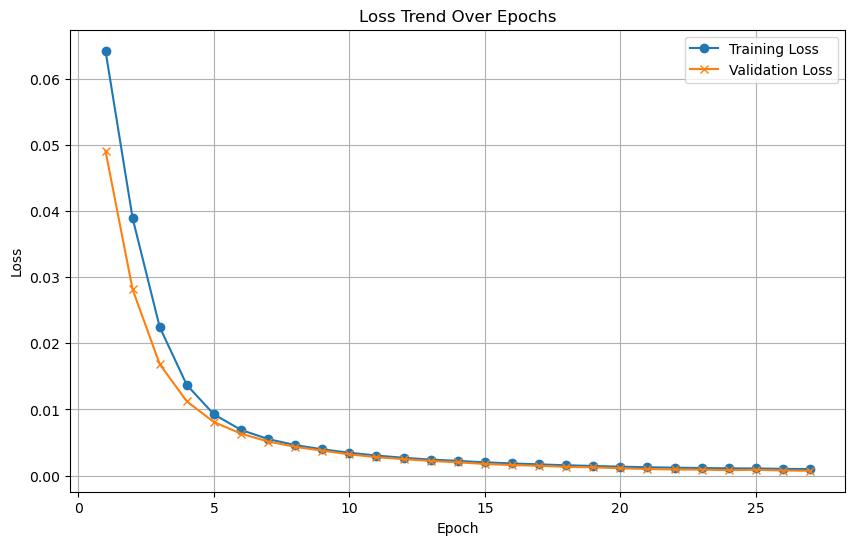

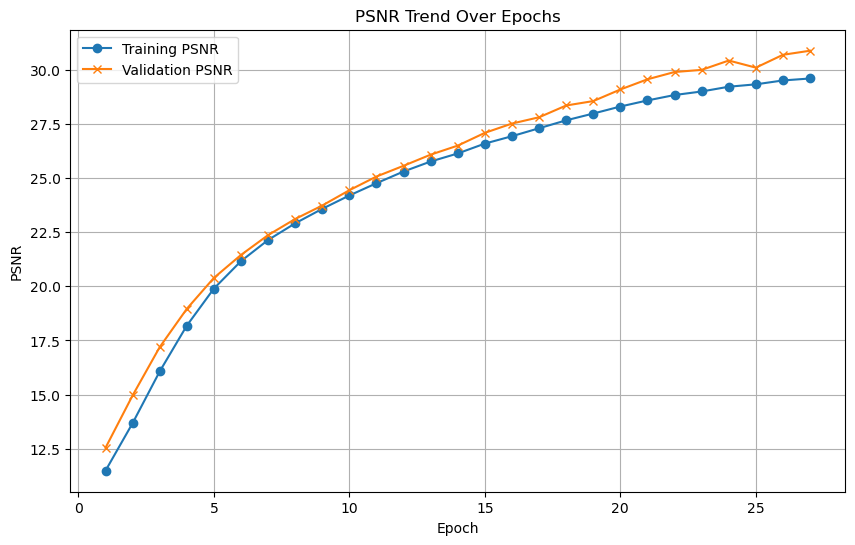

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/39 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7870
    Validation Batch [1/1], Loss: 2.7760
Validation Loss: 2.7760, Validation Accuracy: 6.67%
Validation loss improved from inf to 2.7760. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7629
    Validation Batch [1/1], Loss: 2.7760
Validation Loss: 2.7760, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7411
    Validation Batch [1/1], Loss: 2.7761
Validation Loss: 2.7761, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7409
    Validation Batch [1/1], Loss: 2.7762
Validation Loss: 2.7762, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

Epoch [9/1000] completed, Average Training Loss: 2.6729
    Validation Batch [1/1], Loss: 2.7766
Validation Loss: 2.7766, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6580
    Validation Batch [1/1], Loss: 2.7766
Validation Loss: 2.7766, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6597
    Validation Batch [1/1], Loss: 2.7765
Validation Loss: 2.7765, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.6472
    Validation Batch [1/1], Loss: 2.7765
Validation Loss: 2.7765, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.6381
    Validation

    Validation Batch [1/1], Loss: 2.7761
Validation Loss: 2.7761, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.6019
    Validation Batch [1/1], Loss: 2.7760
Validation Loss: 2.7760, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.5885
    Validation Batch [1/1], Loss: 2.7759
Validation Loss: 2.7759, Validation Accuracy: 6.67%
Validation loss improved from 2.7760 to 2.7759. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.5644
    Validation Batch [1/1], Loss: 2.7757
Validation Loss: 2.7757, Validation Accuracy: 6.67%
Validation loss improved from 2.7759 to 2.7757. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.5629
    Validation Batch [1/1], Loss: 2.7753

Epoch [31/1000] completed, Average Training Loss: 2.4494
    Validation Batch [1/1], Loss: 2.7661
Validation Loss: 2.7661, Validation Accuracy: 6.67%
Validation loss improved from 2.7685 to 2.7661. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.4507
    Validation Batch [1/1], Loss: 2.7644
Validation Loss: 2.7644, Validation Accuracy: 6.67%
Validation loss improved from 2.7661 to 2.7644. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.4537
    Validation Batch [1/1], Loss: 2.7624
Validation Loss: 2.7624, Validation Accuracy: 6.67%
Validation loss improved from 2.7644 to 2.7624. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/1000] completed, Average Training Loss: 2.4243
    Validation Batch [1/1], Loss: 2.7585
Validation Loss: 2.7585, Validation Accuracy: 6.67%
Validation loss improved from 2.7624 to 2.7585. Saving model...

LOG: Epoch [35/1000] - Training
Epoch [35/10

Epoch [40/1000] completed, Average Training Loss: 2.3748
    Validation Batch [1/1], Loss: 2.7214
Validation Loss: 2.7214, Validation Accuracy: 6.67%
Validation loss improved from 2.7264 to 2.7214. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.3705
    Validation Batch [1/1], Loss: 2.7185
Validation Loss: 2.7185, Validation Accuracy: 6.67%
Validation loss improved from 2.7214 to 2.7185. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.3599
    Validation Batch [1/1], Loss: 2.7120
Validation Loss: 2.7120, Validation Accuracy: 6.67%
Validation loss improved from 2.7185 to 2.7120. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.3465
    Validation Batch [1/1], Loss: 2.7042
Validation Loss: 2.7042, Validation Accuracy: 8.00%
Validation loss improved from 2.7120 to 2.7042. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/10

Epoch [55/1000] completed, Average Training Loss: 2.2602
    Validation Batch [1/1], Loss: 2.5737
Validation Loss: 2.5737, Validation Accuracy: 14.67%
Validation loss improved from 2.5783 to 2.5737. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 2.2488
    Validation Batch [1/1], Loss: 2.5631
Validation Loss: 2.5631, Validation Accuracy: 13.33%
Validation loss improved from 2.5737 to 2.5631. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 2.2244
    Validation Batch [1/1], Loss: 2.5292
Validation Loss: 2.5292, Validation Accuracy: 21.33%
Validation loss improved from 2.5631 to 2.5292. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 2.2297
    Validation Batch [1/1], Loss: 2.5065
Validation Loss: 2.5065, Validation Accuracy: 24.00%
Validation loss improved from 2.5292 to 2.5065. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [5

Epoch [62/1000] completed, Average Training Loss: 2.2083
    Validation Batch [1/1], Loss: 2.4039
Validation Loss: 2.4039, Validation Accuracy: 36.00%
Validation loss improved from 2.4268 to 2.4039. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.1855
    Validation Batch [1/1], Loss: 2.3972
Validation Loss: 2.3972, Validation Accuracy: 33.33%
Validation loss improved from 2.4039 to 2.3972. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 2.1676
    Validation Batch [1/1], Loss: 2.3969
Validation Loss: 2.3969, Validation Accuracy: 36.00%
Validation loss improved from 2.3972 to 2.3969. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 2.1627
    Validation Batch [1/1], Loss: 2.3723
Validation Loss: 2.3723, Validation Accuracy: 40.00%
Validation loss improved from 2.3969 to 2.3723. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [6

    Validation Batch [1/1], Loss: 2.2301
Validation Loss: 2.2301, Validation Accuracy: 56.00%
Validation loss improved from 2.2453 to 2.2301. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 2.0784
    Validation Batch [1/1], Loss: 2.2239
Validation Loss: 2.2239, Validation Accuracy: 56.00%
Validation loss improved from 2.2301 to 2.2239. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 2.0307
    Validation Batch [1/1], Loss: 2.2373
Validation Loss: 2.2373, Validation Accuracy: 53.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 2.0431
    Validation Batch [1/1], Loss: 2.2628
Validation Loss: 2.2628, Validation Accuracy: 48.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 2.0489
    Validation Batch [1/1], Loss: 2.25

    Validation Batch [1/1], Loss: 2.2191
Validation Loss: 2.2191, Validation Accuracy: 42.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.9917
    Validation Batch [1/1], Loss: 2.2013
Validation Loss: 2.2013, Validation Accuracy: 45.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.9891
    Validation Batch [1/1], Loss: 2.1472
Validation Loss: 2.1472, Validation Accuracy: 56.00%
Validation loss improved from 2.1854 to 2.1472. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.9726
    Validation Batch [1/1], Loss: 2.1424
Validation Loss: 2.1424, Validation Accuracy: 54.67%
Validation loss improved from 2.1472 to 2.1424. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.9699
    Validation Batch [1/1], Loss: 2.19

Epoch [100/1000] completed, Average Training Loss: 1.8564
    Validation Batch [1/1], Loss: 2.0561
Validation Loss: 2.0561, Validation Accuracy: 50.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.8580
    Validation Batch [1/1], Loss: 2.0430
Validation Loss: 2.0430, Validation Accuracy: 53.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 1.8515
    Validation Batch [1/1], Loss: 2.0380
Validation Loss: 2.0380, Validation Accuracy: 52.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 1.8381
    Validation Batch [1/1], Loss: 2.0669
Validation Loss: 2.0669, Validation Accuracy: 44.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [104/1000] - Training
Epoch [104/1000] completed, Average Training Loss: 1.8136
  

Epoch [106/1000] completed, Average Training Loss: 1.7978
    Validation Batch [1/1], Loss: 2.0138
Validation Loss: 2.0138, Validation Accuracy: 48.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 1.7857
    Validation Batch [1/1], Loss: 1.9907
Validation Loss: 1.9907, Validation Accuracy: 50.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.7671
    Validation Batch [1/1], Loss: 1.9233
Validation Loss: 1.9233, Validation Accuracy: 56.00%
Validation loss improved from 1.9367 to 1.9233. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.7816
    Validation Batch [1/1], Loss: 1.9031
Validation Loss: 1.9031, Validation Accuracy: 57.33%
Validation loss improved from 1.9233 to 1.9031. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Av

Epoch [121/1000] completed, Average Training Loss: 1.6436
    Validation Batch [1/1], Loss: 1.9215
Validation Loss: 1.9215, Validation Accuracy: 50.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.6788
    Validation Batch [1/1], Loss: 1.8396
Validation Loss: 1.8396, Validation Accuracy: 54.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.6503
    Validation Batch [1/1], Loss: 1.7850
Validation Loss: 1.7850, Validation Accuracy: 58.67%
Validation loss improved from 1.8105 to 1.7850. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.6468
    Validation Batch [1/1], Loss: 1.7890
Validation Loss: 1.7890, Validation Accuracy: 61.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training 

Epoch [130/1000] completed, Average Training Loss: 1.5628
    Validation Batch [1/1], Loss: 1.7347
Validation Loss: 1.7347, Validation Accuracy: 61.33%
Validation loss improved from 1.7695 to 1.7347. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 1.5626
    Validation Batch [1/1], Loss: 1.7587
Validation Loss: 1.7587, Validation Accuracy: 65.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.5441
    Validation Batch [1/1], Loss: 1.7567
Validation Loss: 1.7567, Validation Accuracy: 57.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 1.5430
    Validation Batch [1/1], Loss: 1.6975
Validation Loss: 1.6975, Validation Accuracy: 62.67%
Validation loss improved from 1.7347 to 1.6975. Saving model...

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Av

Epoch [144/1000] completed, Average Training Loss: 1.4559
    Validation Batch [1/1], Loss: 1.7149
Validation Loss: 1.7149, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 1.4336
    Validation Batch [1/1], Loss: 1.6207
Validation Loss: 1.6207, Validation Accuracy: 69.33%
Validation loss improved from 1.6316 to 1.6207. Saving model...

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 1.4055
    Validation Batch [1/1], Loss: 1.6061
Validation Loss: 1.6061, Validation Accuracy: 61.33%
Validation loss improved from 1.6207 to 1.6061. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 1.4120
    Validation Batch [1/1], Loss: 1.5794
Validation Loss: 1.5794, Validation Accuracy: 64.00%
Validation loss improved from 1.6061 to 1.5794. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000

Epoch [152/1000] completed, Average Training Loss: 1.3713
    Validation Batch [1/1], Loss: 1.5736
Validation Loss: 1.5736, Validation Accuracy: 66.67%
Validation loss improved from 1.5786 to 1.5736. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.3526
    Validation Batch [1/1], Loss: 1.5768
Validation Loss: 1.5768, Validation Accuracy: 61.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.3755
    Validation Batch [1/1], Loss: 1.5391
Validation Loss: 1.5391, Validation Accuracy: 65.33%
Validation loss improved from 1.5736 to 1.5391. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.3225
    Validation Batch [1/1], Loss: 1.5318
Validation Loss: 1.5318, Validation Accuracy: 68.00%
Validation loss improved from 1.5391 to 1.5318. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000

    Validation Batch [1/1], Loss: 1.4789
Validation Loss: 1.4789, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.2306
    Validation Batch [1/1], Loss: 1.4923
Validation Loss: 1.4923, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.2641
    Validation Batch [1/1], Loss: 1.4819
Validation Loss: 1.4819, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.2322
    Validation Batch [1/1], Loss: 1.5085
Validation Loss: 1.5085, Validation Accuracy: 68.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 1.2200
    Validation Batch [1/1], Loss: 1.4639
Validation Loss: 1.

    Validation Batch [1/1], Loss: 1.4418
Validation Loss: 1.4418, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 1.1645
    Validation Batch [1/1], Loss: 1.4203
Validation Loss: 1.4203, Validation Accuracy: 70.67%
Validation loss improved from 1.4408 to 1.4203. Saving model...

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 1.1794
    Validation Batch [1/1], Loss: 1.4068
Validation Loss: 1.4068, Validation Accuracy: 72.00%
Validation loss improved from 1.4203 to 1.4068. Saving model...

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 1.1295
    Validation Batch [1/1], Loss: 1.4008
Validation Loss: 1.4008, Validation Accuracy: 70.67%
Validation loss improved from 1.4068 to 1.4008. Saving model...

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 1.1471
    Validation 

Epoch [189/1000] completed, Average Training Loss: 1.0476
    Validation Batch [1/1], Loss: 1.3446
Validation Loss: 1.3446, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 1.0400
    Validation Batch [1/1], Loss: 1.4654
Validation Loss: 1.4654, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 1.0332
    Validation Batch [1/1], Loss: 1.3733
Validation Loss: 1.3733, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 1.0209
    Validation Batch [1/1], Loss: 1.3252
Validation Loss: 1.3252, Validation Accuracy: 74.67%
Validation loss improved from 1.3443 to 1.3252. Saving model...

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training 

Epoch [197/1000] completed, Average Training Loss: 0.9836
    Validation Batch [1/1], Loss: 1.3379
Validation Loss: 1.3379, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.9639
    Validation Batch [1/1], Loss: 1.3416
Validation Loss: 1.3416, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.9659
    Validation Batch [1/1], Loss: 1.2933
Validation Loss: 1.2933, Validation Accuracy: 72.00%
Validation loss improved from 1.3252 to 1.2933. Saving model...

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.9609
    Validation Batch [1/1], Loss: 1.3088
Validation Loss: 1.3088, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training 

Epoch [212/1000] completed, Average Training Loss: 0.8548
    Validation Batch [1/1], Loss: 1.2273
Validation Loss: 1.2273, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.8689
    Validation Batch [1/1], Loss: 1.1969
Validation Loss: 1.1969, Validation Accuracy: 73.33%
Validation loss improved from 1.2072 to 1.1969. Saving model...

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.8631
    Validation Batch [1/1], Loss: 1.2800
Validation Loss: 1.2800, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.8787
    Validation Batch [1/1], Loss: 1.2039
Validation Loss: 1.2039, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.2313
Validation Loss: 1.2313, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.8065
    Validation Batch [1/1], Loss: 1.2027
Validation Loss: 1.2027, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.7942
    Validation Batch [1/1], Loss: 1.1527
Validation Loss: 1.1527, Validation Accuracy: 72.00%
Validation loss improved from 1.1969 to 1.1527. Saving model...

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.7655
    Validation Batch [1/1], Loss: 1.2466
Validation Loss: 1.2466, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.7975
    Validation Batch [1/1], Loss: 1.1527
Vali

Epoch [233/1000] completed, Average Training Loss: 0.6903
    Validation Batch [1/1], Loss: 1.1458
Validation Loss: 1.1458, Validation Accuracy: 70.67%
Validation loss improved from 1.1527 to 1.1458. Saving model...

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.6834
    Validation Batch [1/1], Loss: 1.2232
Validation Loss: 1.2232, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.7032
    Validation Batch [1/1], Loss: 1.1545
Validation Loss: 1.1545, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.7234
    Validation Batch [1/1], Loss: 1.1296
Validation Loss: 1.1296, Validation Accuracy: 73.33%
Validation loss improved from 1.1458 to 1.1296. Saving model...

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Av

    Validation Batch [1/1], Loss: 1.1271
Validation Loss: 1.1271, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.6374
    Validation Batch [1/1], Loss: 1.0714
Validation Loss: 1.0714, Validation Accuracy: 73.33%
Validation loss improved from 1.0827 to 1.0714. Saving model...

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.6499
    Validation Batch [1/1], Loss: 1.2070
Validation Loss: 1.2070, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.6543
    Validation Batch [1/1], Loss: 1.0829
Validation Loss: 1.0829, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.6322
    Validation Batch [1/1], Loss: 1.0531
Vali

Epoch [255/1000] completed, Average Training Loss: 0.5878
    Validation Batch [1/1], Loss: 1.1150
Validation Loss: 1.1150, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.5722
    Validation Batch [1/1], Loss: 1.1812
Validation Loss: 1.1812, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.5791
    Validation Batch [1/1], Loss: 1.0986
Validation Loss: 1.0986, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.5697
    Validation Batch [1/1], Loss: 1.1097
Validation Loss: 1.1097, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.5674
  

Epoch [263/1000] completed, Average Training Loss: 0.5262
    Validation Batch [1/1], Loss: 1.1752
Validation Loss: 1.1752, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.5244
    Validation Batch [1/1], Loss: 1.0238
Validation Loss: 1.0238, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Training Loss: 0.5253
    Validation Batch [1/1], Loss: 0.9785
Validation Loss: 0.9785, Validation Accuracy: 73.33%
Validation loss improved from 1.0163 to 0.9785. Saving model...

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training Loss: 0.5401
    Validation Batch [1/1], Loss: 1.0311
Validation Loss: 1.0311, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training 

Epoch [279/1000] completed, Average Training Loss: 0.4835
    Validation Batch [1/1], Loss: 1.1261
Validation Loss: 1.1261, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.4987
    Validation Batch [1/1], Loss: 1.1049
Validation Loss: 1.1049, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.4503
    Validation Batch [1/1], Loss: 0.9442
Validation Loss: 0.9442, Validation Accuracy: 76.00%
Validation loss improved from 0.9449 to 0.9442. Saving model...

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.4375
    Validation Batch [1/1], Loss: 0.9925
Validation Loss: 0.9925, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training 

Epoch [285/1000] completed, Average Training Loss: 0.4576
    Validation Batch [1/1], Loss: 1.0268
Validation Loss: 1.0268, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.4245
    Validation Batch [1/1], Loss: 1.0429
Validation Loss: 1.0429, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.4293
    Validation Batch [1/1], Loss: 0.9945
Validation Loss: 0.9945, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.4092
    Validation Batch [1/1], Loss: 0.9550
Validation Loss: 0.9550, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.4377
  

Epoch [302/1000] completed, Average Training Loss: 0.3640
    Validation Batch [1/1], Loss: 1.0243
Validation Loss: 1.0243, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.3601
    Validation Batch [1/1], Loss: 0.9780
Validation Loss: 0.9780, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.3737
    Validation Batch [1/1], Loss: 0.9822
Validation Loss: 0.9822, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [305/1000] - Training


Epoch [305/1000] completed, Average Training Loss: 0.3591
    Validation Batch [1/1], Loss: 0.9820
Validation Loss: 0.9820, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.3554
    Validation Batch [1/1], Loss: 0.9925
Validation Loss: 0.9925, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.3794
    Validation Batch [1/1], Loss: 0.9730
Validation Loss: 0.9730, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.3653
    Validation Batch [1/1], Loss: 1.0191
Validation Loss: 1.0191, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.329

Epoch [315/1000] completed, Average Training Loss: 0.3455
    Validation Batch [1/1], Loss: 0.9885
Validation Loss: 0.9885, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.3247
    Validation Batch [1/1], Loss: 0.9625
Validation Loss: 0.9625, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.3452
    Validation Batch [1/1], Loss: 0.8482
Validation Loss: 0.8482, Validation Accuracy: 76.00%
Validation loss improved from 0.8553 to 0.8482. Saving model...

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.3197
    Validation Batch [1/1], Loss: 0.8815
Validation Loss: 0.8815, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.0308
Validation Loss: 1.0308, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.3314
    Validation Batch [1/1], Loss: 0.9200
Validation Loss: 0.9200, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.2953
    Validation Batch [1/1], Loss: 0.8959
Validation Loss: 0.8959, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.2811
    Validation Batch [1/1], Loss: 0.9829
Validation Loss: 0.9829, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.2770
    Validation Batch [1/1], Loss: 1.0271
Validation Loss

Epoch [340/1000] completed, Average Training Loss: 0.2522
    Validation Batch [1/1], Loss: 0.8910
Validation Loss: 0.8910, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.2722
    Validation Batch [1/1], Loss: 0.8617
Validation Loss: 0.8617, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.2469
    Validation Batch [1/1], Loss: 0.8337
Validation Loss: 0.8337, Validation Accuracy: 77.33%
Validation loss improved from 0.8463 to 0.8337. Saving model...

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.2633
    Validation Batch [1/1], Loss: 0.9167
Validation Loss: 0.9167, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training 

Epoch [349/1000] completed, Average Training Loss: 0.2279
    Validation Batch [1/1], Loss: 0.8039
Validation Loss: 0.8039, Validation Accuracy: 77.33%
Validation loss improved from 0.8217 to 0.8039. Saving model...

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.2670
    Validation Batch [1/1], Loss: 0.8601
Validation Loss: 0.8601, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.2543
    Validation Batch [1/1], Loss: 1.0145
Validation Loss: 1.0145, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training Loss: 0.2353
    Validation Batch [1/1], Loss: 0.9375
Validation Loss: 0.9375, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training 

Epoch [363/1000] completed, Average Training Loss: 0.2204
    Validation Batch [1/1], Loss: 0.7913
Validation Loss: 0.7913, Validation Accuracy: 77.33%
Validation loss improved from 0.8039 to 0.7913. Saving model...

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.2145
    Validation Batch [1/1], Loss: 0.8037
Validation Loss: 0.8037, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.1996
    Validation Batch [1/1], Loss: 0.8873
Validation Loss: 0.8873, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.2084
    Validation Batch [1/1], Loss: 0.8774
Validation Loss: 0.8774, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training 

Epoch [373/1000] completed, Average Training Loss: 0.2042
    Validation Batch [1/1], Loss: 0.8417
Validation Loss: 0.8417, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.1958
    Validation Batch [1/1], Loss: 0.8132
Validation Loss: 0.8132, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.1945
    Validation Batch [1/1], Loss: 0.8185
Validation Loss: 0.8185, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.1984
    Validation Batch [1/1], Loss: 0.8759
Validation Loss: 0.8759, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.1972
  

Epoch [386/1000] completed, Average Training Loss: 0.1863
    Validation Batch [1/1], Loss: 0.7712
Validation Loss: 0.7712, Validation Accuracy: 74.67%
Validation loss improved from 0.7895 to 0.7712. Saving model...

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.1691
    Validation Batch [1/1], Loss: 0.7453
Validation Loss: 0.7453, Validation Accuracy: 74.67%
Validation loss improved from 0.7712 to 0.7453. Saving model...

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.1900
    Validation Batch [1/1], Loss: 0.8434
Validation Loss: 0.8434, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.2044
    Validation Batch [1/1], Loss: 0.9435
Validation Loss: 0.9435, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Av

Epoch [396/1000] completed, Average Training Loss: 0.1662
    Validation Batch [1/1], Loss: 0.7526
Validation Loss: 0.7526, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.1615
    Validation Batch [1/1], Loss: 0.8083
Validation Loss: 0.8083, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.1679
    Validation Batch [1/1], Loss: 0.8094
Validation Loss: 0.8094, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.1701
    Validation Batch [1/1], Loss: 0.8120
Validation Loss: 0.8120, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.1514

Epoch [410/1000] completed, Average Training Loss: 0.1613
    Validation Batch [1/1], Loss: 0.7937
Validation Loss: 0.7937, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.1475
    Validation Batch [1/1], Loss: 0.7427
Validation Loss: 0.7427, Validation Accuracy: 77.33%
Validation loss improved from 0.7453 to 0.7427. Saving model...

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.1428
    Validation Batch [1/1], Loss: 0.7462
Validation Loss: 0.7462, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.1482
    Validation Batch [1/1], Loss: 0.7534
Validation Loss: 0.7534, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training

    Validation Batch [1/1], Loss: 0.7417
Validation Loss: 0.7417, Validation Accuracy: 76.00%
Validation loss improved from 0.7423 to 0.7417. Saving model...

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.1372
    Validation Batch [1/1], Loss: 0.7927
Validation Loss: 0.7927, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.1456
    Validation Batch [1/1], Loss: 0.8084
Validation Loss: 0.8084, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.1554
    Validation Batch [1/1], Loss: 0.8809
Validation Loss: 0.8809, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.1368
    Validation Batch [1/1], Loss: 0.8698
Vali

Epoch [433/1000] completed, Average Training Loss: 0.1306
    Validation Batch [1/1], Loss: 0.7791
Validation Loss: 0.7791, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.1272
    Validation Batch [1/1], Loss: 0.9228
Validation Loss: 0.9228, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.1209
    Validation Batch [1/1], Loss: 0.9251
Validation Loss: 0.9251, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.1315
    Validation Batch [1/1], Loss: 0.9238
Validation Loss: 0.9238, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [437/1000] - Training
Epoch [437/1000] completed, Average Training Loss: 0.1447
  

Epoch [442/1000] completed, Average Training Loss: 0.1202
    Validation Batch [1/1], Loss: 0.8227
Validation Loss: 0.8227, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.1167
    Validation Batch [1/1], Loss: 0.8440
Validation Loss: 0.8440, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.1252
    Validation Batch [1/1], Loss: 0.7752
Validation Loss: 0.7752, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.1234
    Validation Batch [1/1], Loss: 0.7670
Validation Loss: 0.7670, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.1223
  

Epoch [458/1000] completed, Average Training Loss: 0.1324
    Validation Batch [1/1], Loss: 0.7475
Validation Loss: 0.7475, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.0981
    Validation Batch [1/1], Loss: 0.7759
Validation Loss: 0.7759, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.1096
    Validation Batch [1/1], Loss: 0.7424
Validation Loss: 0.7424, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.1059
    Validation Batch [1/1], Loss: 0.7650
Validation Loss: 0.7650, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.111

    Validation Batch [1/1], Loss: 0.7510
Validation Loss: 0.7510, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.1192
    Validation Batch [1/1], Loss: 0.7422
Validation Loss: 0.7422, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.1162
    Validation Batch [1/1], Loss: 0.7897
Validation Loss: 0.7897, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.1128
    Validation Batch [1/1], Loss: 0.8300
Validation Loss: 0.8300, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.1086
    Validation Batch [1/1], Loss: 0.8176
Validation Loss

Epoch [481/1000] completed, Average Training Loss: 0.1026
    Validation Batch [1/1], Loss: 0.7150
Validation Loss: 0.7150, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.1009
    Validation Batch [1/1], Loss: 0.7492
Validation Loss: 0.7492, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.0992
    Validation Batch [1/1], Loss: 0.7786
Validation Loss: 0.7786, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.1046
    Validation Batch [1/1], Loss: 0.7689
Validation Loss: 0.7689, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.091

Epoch [489/1000] completed, Average Training Loss: 0.0960
    Validation Batch [1/1], Loss: 0.8001
Validation Loss: 0.8001, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [490/1000] - Training
Epoch [490/1000] completed, Average Training Loss: 0.0963
    Validation Batch [1/1], Loss: 0.8154
Validation Loss: 0.8154, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.0902
    Validation Batch [1/1], Loss: 0.8043
Validation Loss: 0.8043, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.1114
    Validation Batch [1/1], Loss: 0.7440
Validation Loss: 0.7440, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.095

    Validation Batch [1/1], Loss: 0.8274
Validation Loss: 0.8274, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.1022
    Validation Batch [1/1], Loss: 0.7712
Validation Loss: 0.7712, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.0849
    Validation Batch [1/1], Loss: 0.8074
Validation Loss: 0.8074, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.0860
    Validation Batch [1/1], Loss: 0.8895
Validation Loss: 0.8895, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [506/1000] - Training
Epoch [506/1000] completed, Average Training Loss: 0.0936
    Validation Batch [1/1], Loss: 0.8627
Validation Loss

    Validation Batch [1/1], Loss: 0.7557
Validation Loss: 0.7557, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [513/1000] - Training
Epoch [513/1000] completed, Average Training Loss: 0.0807
    Validation Batch [1/1], Loss: 0.8166
Validation Loss: 0.8166, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.0878
    Validation Batch [1/1], Loss: 0.8304
Validation Loss: 0.8304, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.0833
    Validation Batch [1/1], Loss: 0.8331
Validation Loss: 0.8331, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.0862
    Validation Batch [1/1], Loss: 0.8708
Validation Loss

    Validation Batch [1/1], Loss: 0.7462
Validation Loss: 0.7462, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0881
    Validation Batch [1/1], Loss: 0.7007
Validation Loss: 0.7007, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0835
    Validation Batch [1/1], Loss: 0.7823
Validation Loss: 0.7823, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0786
    Validation Batch [1/1], Loss: 0.8268
Validation Loss: 0.8268, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0683
    Validation Batch [1/1], Loss: 0.7735
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.8470
Validation Loss: 0.8470, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0739
    Validation Batch [1/1], Loss: 0.7334
Validation Loss: 0.7334, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [535/1000] - Training
Epoch [535/1000] completed, Average Training Loss: 0.0727
    Validation Batch [1/1], Loss: 0.7253
Validation Loss: 0.7253, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [536/1000] - Training
Epoch [536/1000] completed, Average Training Loss: 0.0728
    Validation Batch [1/1], Loss: 0.7086
Validation Loss: 0.7086, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [537/1000] - Training
Epoch [537/1000] completed, Average Training Loss: 0.0780
    Validation Batch [1/1], Loss: 0.7026
Validation Loss

Epoch [548/1000] completed, Average Training Loss: 0.0699
    Validation Batch [1/1], Loss: 0.7450
Validation Loss: 0.7450, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [549/1000] - Training
Epoch [549/1000] completed, Average Training Loss: 0.0746
    Validation Batch [1/1], Loss: 0.8728
Validation Loss: 0.8728, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [550/1000] - Training
Epoch [550/1000] completed, Average Training Loss: 0.0687
    Validation Batch [1/1], Loss: 0.9481
Validation Loss: 0.9481, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [551/1000] - Training
Epoch [551/1000] completed, Average Training Loss: 0.0702
    Validation Batch [1/1], Loss: 0.8222
Validation Loss: 0.8222, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.072

Epoch [555/1000] completed, Average Training Loss: 0.0707
    Validation Batch [1/1], Loss: 0.9181
Validation Loss: 0.9181, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0705
    Validation Batch [1/1], Loss: 0.8991
Validation Loss: 0.8991, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0637
    Validation Batch [1/1], Loss: 0.8314
Validation Loss: 0.8314, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0821
    Validation Batch [1/1], Loss: 0.7687
Validation Loss: 0.7687, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.062

Epoch [571/1000] completed, Average Training Loss: 0.0706
    Validation Batch [1/1], Loss: 0.9282
Validation Loss: 0.9282, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.0709
    Validation Batch [1/1], Loss: 0.9423
Validation Loss: 0.9423, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.0697
    Validation Batch [1/1], Loss: 0.8314
Validation Loss: 0.8314, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0581
    Validation Batch [1/1], Loss: 0.9238
Validation Loss: 0.9238, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.069

    Validation Batch [1/1], Loss: 0.8998
Validation Loss: 0.8998, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [578/1000] - Training
Epoch [578/1000] completed, Average Training Loss: 0.0627
    Validation Batch [1/1], Loss: 0.9521
Validation Loss: 0.9521, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [579/1000] - Training
Epoch [579/1000] completed, Average Training Loss: 0.0627
    Validation Batch [1/1], Loss: 0.8163
Validation Loss: 0.8163, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [580/1000] - Training
Epoch [580/1000] completed, Average Training Loss: 0.0676
    Validation Batch [1/1], Loss: 0.7699
Validation Loss: 0.7699, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.0572
    Validation Batch [1/1], Loss: 0.8054
Validation Loss

Epoch [593/1000] completed, Average Training Loss: 0.0656
    Validation Batch [1/1], Loss: 0.8151
Validation Loss: 0.8151, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0607
    Validation Batch [1/1], Loss: 0.9442
Validation Loss: 0.9442, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.0539
    Validation Batch [1/1], Loss: 0.9589
Validation Loss: 0.9589, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.0524
    Validation Batch [1/1], Loss: 0.8350
Validation Loss: 0.8350, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [597/1000] - Training
Epoch [597/1000] completed, Average Training Loss: 0.066

Epoch [601/1000] completed, Average Training Loss: 0.0615
    Validation Batch [1/1], Loss: 0.7692
Validation Loss: 0.7692, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [602/1000] - Training
Epoch [602/1000] completed, Average Training Loss: 0.0698
    Validation Batch [1/1], Loss: 0.7143
Validation Loss: 0.7143, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [603/1000] - Training
Epoch [603/1000] completed, Average Training Loss: 0.0552
    Validation Batch [1/1], Loss: 0.8275
Validation Loss: 0.8275, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [604/1000] - Training
Epoch [604/1000] completed, Average Training Loss: 0.0648
    Validation Batch [1/1], Loss: 0.9953
Validation Loss: 0.9953, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [605/1000] - Training
Epoch [605/1000] completed, Average Training Loss: 0.058

Epoch [616/1000] completed, Average Training Loss: 0.0544
    Validation Batch [1/1], Loss: 0.7108
Validation Loss: 0.7108, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [617/1000] - Training
Epoch [617/1000] completed, Average Training Loss: 0.0503
    Validation Batch [1/1], Loss: 0.7162
Validation Loss: 0.7162, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [618/1000] - Training
Epoch [618/1000] completed, Average Training Loss: 0.0554
    Validation Batch [1/1], Loss: 0.7593
Validation Loss: 0.7593, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [619/1000] - Training
Epoch [619/1000] completed, Average Training Loss: 0.0549
    Validation Batch [1/1], Loss: 0.7716
Validation Loss: 0.7716, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [620/1000] - Training
Epoch [620/1000] completed, Average Training Loss: 0.057

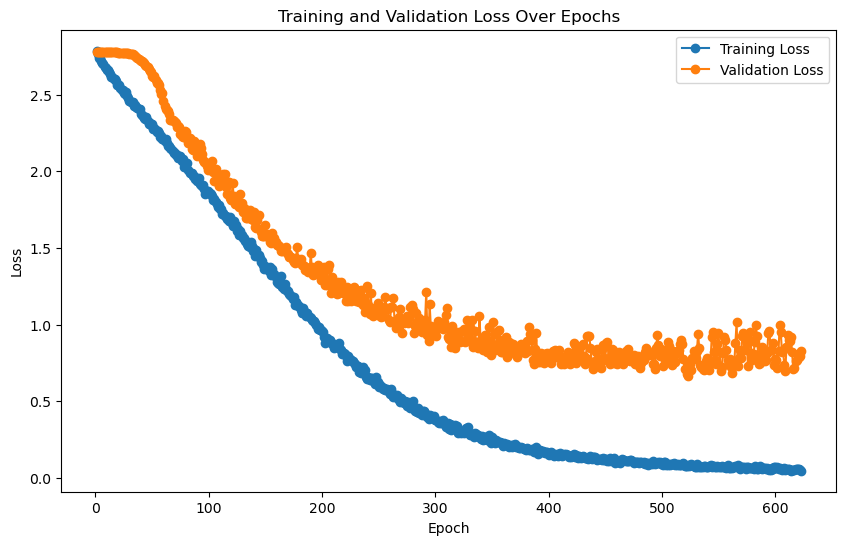

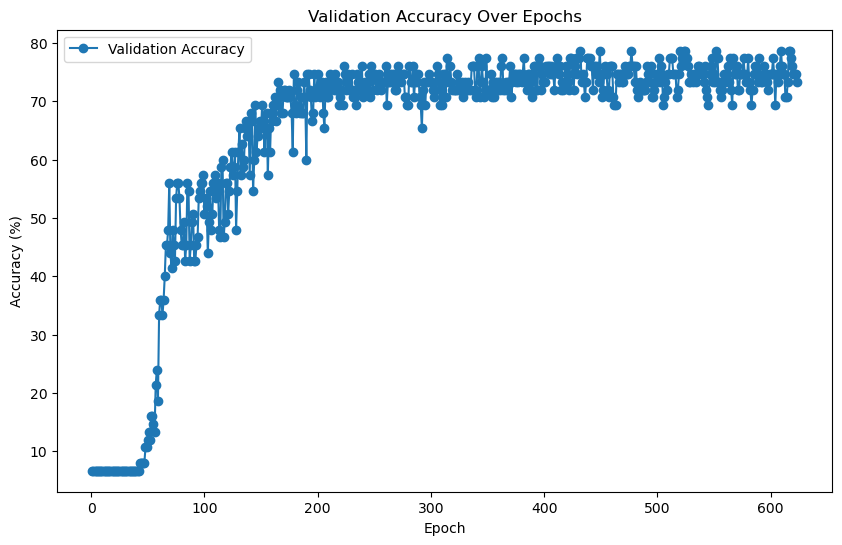


Evaluating on the test set...
    Test Batch [1/39], Loss: 1.6850

Final Test Loss: 1.2772, Test Accuracy: 64.83%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/39 for test dataset.
  Processed batch 20/39 for test dataset.
  Processed batch 30/39 for test dataset.


Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (75, 64), Validation labels shape: (75,)
LOG: Test features shape: (9854, 64), Test labels shape: (9854,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 52.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.25      0.20      0.22         5
           2       1.00      0.60      0.75         5
           3       1.00      0.80      0.89         5
           4       0.50      0.60      0.55         5
           5       0.00      0.00      0.00         5
           6       1.00      0.60      0.75         5
           7       0.57      0.80      0.67         5
           8       0.00      0.00  

Test Accuracy: 45.45%

Test Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.71      0.18        21
           1       0.39      0.42      0.40      1403
           2       0.40      0.19      0.26       805
           3       0.44      0.58      0.50       212
           4       0.45      0.53      0.48       458
           5       0.69      0.57      0.62       705
           6       0.03      1.00      0.06         3
           7       0.87      0.80      0.83       453
           8       0.00      0.00      0.00         0
           9       0.27      0.58      0.37       947
          10       0.52      0.29      0.38      2430
          11       0.30      0.31      0.30       568
          12       0.37      0.69      0.48       180
          13       0.89      0.66      0.76      1240
          14       0.33      0.38      0.35       361
          15       1.00      0.97      0.99        68

    accuracy                

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (75, 64)
Val labels shape: (75,)
Test reps shape: (9854, 64)
Test labels shape: (9854,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9089  |  Val Loss: 2.7317
Validation loss improved from inf to 2.7317.
[Epoch 2/1000] Train Loss: 2.6916  |  Val Loss: 2.6460
Validation loss improved from 2.7317 to 2.6460.
[Epoch 3/1000] Train Loss: 2.5883  |  Val Loss: 2.5833
Validation loss improved from 2.6460 to 2.5833.
[Epoch 4/1000] Train Loss: 2.5143  |  Val Loss: 2.5190
Validation loss improved from 2.5833 to 2.5190.
[Epoch 5/1000] Train Loss: 2.4373  |  Val Loss: 2.4637
Validation loss improved from 2.5190 to 2.4637.
[Epoch 6/1000] Train Loss: 2.3526  |  Val Loss: 2.3980
Validation loss improved from 2.4637 to 2.3980.
[Epoch 7/1000] Train Loss: 2.2654  |  Val Loss: 2.3370
Validation loss improved from 2.3980 to 2.3370.
[Epoch 8/1000] Train Loss: 2.1740  |  Val Loss: 2.2824
Validation loss improved from 2.3370 to 2.2824.
[Epoch 9/1000] Train Loss: 2.0903  |  Val Loss: 2.2564
Validation loss improved from 2.2824 to 2.2564.
[Epoch 10/1000] Train Loss: 2.0060  |  Val Loss: 2.1996
Validation loss impr

[Epoch 12/1000] Train Loss: 1.8510  |  Val Loss: 2.1068
Validation loss improved from 2.1708 to 2.1068.
[Epoch 13/1000] Train Loss: 1.7740  |  Val Loss: 2.0930
Validation loss improved from 2.1068 to 2.0930.
[Epoch 14/1000] Train Loss: 1.7149  |  Val Loss: 2.0440
Validation loss improved from 2.0930 to 2.0440.
[Epoch 15/1000] Train Loss: 1.6437  |  Val Loss: 1.9993
Validation loss improved from 2.0440 to 1.9993.


[Epoch 16/1000] Train Loss: 1.5819  |  Val Loss: 1.9936
Validation loss improved from 1.9993 to 1.9936.
[Epoch 17/1000] Train Loss: 1.5284  |  Val Loss: 1.9638
Validation loss improved from 1.9936 to 1.9638.
[Epoch 18/1000] Train Loss: 1.4740  |  Val Loss: 1.9118
Validation loss improved from 1.9638 to 1.9118.
[Epoch 19/1000] Train Loss: 1.4287  |  Val Loss: 1.8906
Validation loss improved from 1.9118 to 1.8906.


[Epoch 20/1000] Train Loss: 1.3884  |  Val Loss: 1.8728
Validation loss improved from 1.8906 to 1.8728.
[Epoch 21/1000] Train Loss: 1.3480  |  Val Loss: 1.8447
Validation loss improved from 1.8728 to 1.8447.
[Epoch 22/1000] Train Loss: 1.3058  |  Val Loss: 1.8013
Validation loss improved from 1.8447 to 1.8013.
[Epoch 23/1000] Train Loss: 1.2718  |  Val Loss: 1.8384
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 24/1000] Train Loss: 1.2488  |  Val Loss: 1.7833
Validation loss improved from 1.8013 to 1.7833.
[Epoch 25/1000] Train Loss: 1.2192  |  Val Loss: 1.7752
Validation loss improved from 1.7833 to 1.7752.
[Epoch 26/1000] Train Loss: 1.1909  |  Val Loss: 1.7835
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 1.1691  |  Val Loss: 1.7319
Validation loss improved from 1.7752 to 1.7319.
[Epoch 28/1000] Train Loss: 1.1406  |  Val Loss: 1.7966
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 29/1000] Train Loss: 1.1268  |  Val Los

[Epoch 31/1000] Train Loss: 1.0875  |  Val Loss: 1.6910
Validation loss improved from 1.6978 to 1.6910.
[Epoch 32/1000] Train Loss: 1.0634  |  Val Loss: 1.7020
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 33/1000] Train Loss: 1.0409  |  Val Loss: 1.7108
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 34/1000] Train Loss: 1.0223  |  Val Loss: 1.6823
Validation loss improved from 1.6910 to 1.6823.
[Epoch 35/1000] Train Loss: 1.0161  |  Val Loss: 1.6754
Validation loss improved from 1.6823 to 1.6754.
[Epoch 36/1000] Train Loss: 0.9994  |  Val Loss: 1.6483
Validation loss improved from 1.6754 to 1.6483.


[Epoch 37/1000] Train Loss: 0.9836  |  Val Loss: 1.6653
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 38/1000] Train Loss: 0.9607  |  Val Loss: 1.6539
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 39/1000] Train Loss: 0.9592  |  Val Loss: 1.6567
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 40/1000] Train Loss: 0.9402  |  Val Loss: 1.6539
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 41/1000] Train Loss: 0.9227  |  Val Loss: 1.6401
Validation loss improved from 1.6483 to 1.6401.
[Epoch 42/1000] Train Loss: 0.9051  |  Val Loss: 1.6576
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 43/1000] Train Loss: 0.9091  |  Val Loss: 1.6479
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 44/1000] Train Loss: 0.8933  |  Val Loss: 1.6548
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 45/1000] Train Loss: 0.8804  |  Val Loss: 1.6537
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 46/1000] Train Loss: 0.8722  |  Val Loss: 1.6676
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 47/1000] Train Loss: 0.8557  |  Val Loss: 1.6339
Validation loss improved from 1.6401 to 1.6339.
[Epoch 48/1000] Train Loss: 0.8483  |  Val Loss: 1.6543
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 49/1000] Train Loss: 0.8418  |  Val Loss: 1.6303
Validation loss improved from 1.6339 to 1.6303.


[Epoch 50/1000] Train Loss: 0.8374  |  Val Loss: 1.6589
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 0.8186  |  Val Loss: 1.6567
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 52/1000] Train Loss: 0.8083  |  Val Loss: 1.6548
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 53/1000] Train Loss: 0.8018  |  Val Loss: 1.6206
Validation loss improved from 1.6303 to 1.6206.
[Epoch 54/1000] Train Loss: 0.8054  |  Val Loss: 1.6699
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 0.7855  |  Val Loss: 1.6819
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 56/1000] Train Loss: 0.7740  |  Val Loss: 1.6073
Validation loss improved from 1.6206 to 1.6073.
[Epoch 57/1000] Train Loss: 0.7703  |  Val Loss: 1.6615
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 58/1000] Train Loss: 0.7504  |  Val Loss: 1.6563
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 59/1000] Train Loss: 0.7475  |  Val Loss: 1.6492
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 60/1000] Train Loss: 0.7378  |  Val Loss: 1.6375
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 61/1000] Train Loss: 0.7411  |  Val Loss: 1.6736
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 62/1000] Train Loss: 0.7225  |  Val Loss: 1.6259
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 63/1000] Train Loss: 0.7200  |  Val Loss: 1.6374
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 64/1000] Train Loss: 0.7073  |  Val Loss: 1.6697
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 65/1000] Train Loss: 0.7037  |  Val Loss: 1.6340
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 66/1000] Train Loss: 0.6882  |  Val Loss: 1.6558
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 67/1000] Train Loss: 0.6825  |  Val Loss: 1.6537
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 68/1000] Train Loss: 0.6844  |  Val Loss: 1.6661
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 69/1000] Train Loss: 0.6735  |  Val Loss: 1.6601
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 70/1000] Train Loss: 0.6613  |  Val Loss: 1.6621
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 71/1000] Train Loss: 0.6672  |  Val Loss: 1.6726
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 72/1000] Train Loss: 0.6575  |  Val Loss: 1.6569
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 73/1000] Train Loss: 0.6521  |  Val Loss: 1.6722
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 74/1000] Train Loss: 0.6480  |  Val Loss: 1.6883
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 75/1000] Train Loss: 0.6545  |  Val Loss: 1.6884
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 76/1000] Train Loss: 0.6384  |  Val Loss: 1.6605
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 77/1000] Train Loss: 0.6251  |  Val Loss: 1.6885
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 78/1000] Train Loss: 0.6256  |  Val Loss: 1.6810
!! Validation loss did NOT improve !! Patience: 22/100


[Epoch 79/1000] Train Loss: 0.6066  |  Val Loss: 1.7049
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 80/1000] Train Loss: 0.6087  |  Val Loss: 1.6782
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 81/1000] Train Loss: 0.5968  |  Val Loss: 1.6827
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 82/1000] Train Loss: 0.5899  |  Val Loss: 1.6775
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 83/1000] Train Loss: 0.5918  |  Val Loss: 1.7093
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 84/1000] Train Loss: 0.5831  |  Val Loss: 1.7018
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 85/1000] Train Loss: 0.5771  |  Val Loss: 1.6901
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 86/1000] Train Loss: 0.5738  |  Val Loss: 1.7093
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 87/1000] Train Loss: 0.5741  |  Val Loss: 1.7230
!! Validation loss did NOT improve !! Patience: 31/100


[Epoch 88/1000] Train Loss: 0.5649  |  Val Loss: 1.6885
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 89/1000] Train Loss: 0.5644  |  Val Loss: 1.6921
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 90/1000] Train Loss: 0.5620  |  Val Loss: 1.7601
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 91/1000] Train Loss: 0.5558  |  Val Loss: 1.6907
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 92/1000] Train Loss: 0.5565  |  Val Loss: 1.7151
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 93/1000] Train Loss: 0.5498  |  Val Loss: 1.7085
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 94/1000] Train Loss: 0.5291  |  Val Loss: 1.7168
!! Validation loss did NOT improve !! Patience: 38/100


[Epoch 95/1000] Train Loss: 0.5329  |  Val Loss: 1.7493
!! Validation loss did NOT improve !! Patience: 39/100


[Epoch 96/1000] Train Loss: 0.5276  |  Val Loss: 1.7001
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 97/1000] Train Loss: 0.5201  |  Val Loss: 1.7192
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 98/1000] Train Loss: 0.5120  |  Val Loss: 1.7277
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 99/1000] Train Loss: 0.5105  |  Val Loss: 1.7188
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 100/1000] Train Loss: 0.5102  |  Val Loss: 1.7436
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 101/1000] Train Loss: 0.5053  |  Val Loss: 1.7054
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 102/1000] Train Loss: 0.4890  |  Val Loss: 1.7768
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 103/1000] Train Loss: 0.4962  |  Val Loss: 1.7225
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 104/1000] Train Loss: 0.4836  |  Val Loss: 1.7621
!! Validation loss did NOT improve !! Patience: 48/

[Epoch 107/1000] Train Loss: 0.4999  |  Val Loss: 1.7584
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 108/1000] Train Loss: 0.5012  |  Val Loss: 1.7691
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 109/1000] Train Loss: 0.4749  |  Val Loss: 1.7672
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 110/1000] Train Loss: 0.4624  |  Val Loss: 1.8006
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 111/1000] Train Loss: 0.4717  |  Val Loss: 1.7301
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 112/1000] Train Loss: 0.4657  |  Val Loss: 1.7679
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 113/1000] Train Loss: 0.4707  |  Val Loss: 1.7892
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 114/1000] Train Loss: 0.4546  |  Val Loss: 1.7405
!! Validation loss did NOT improve !! Patience: 58/100


[Epoch 115/1000] Train Loss: 0.4435  |  Val Loss: 1.7859
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 116/1000] Train Loss: 0.4321  |  Val Loss: 1.8009
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 117/1000] Train Loss: 0.4374  |  Val Loss: 1.7766
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 118/1000] Train Loss: 0.4414  |  Val Loss: 1.7589
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 119/1000] Train Loss: 0.4297  |  Val Loss: 1.7894
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 120/1000] Train Loss: 0.4348  |  Val Loss: 1.7962
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 121/1000] Train Loss: 0.4392  |  Val Loss: 1.7898
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 122/1000] Train Loss: 0.4207  |  Val Loss: 1.8200
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 123/1000] Train Loss: 0.4241  |  Val Loss: 1.8271
!! Validation loss did NOT improve !! Patience:

[Epoch 126/1000] Train Loss: 0.4170  |  Val Loss: 1.8336
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 127/1000] Train Loss: 0.4133  |  Val Loss: 1.8477
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 128/1000] Train Loss: 0.4077  |  Val Loss: 1.8114
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 129/1000] Train Loss: 0.4004  |  Val Loss: 1.8309
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 130/1000] Train Loss: 0.4031  |  Val Loss: 1.8294
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 131/1000] Train Loss: 0.3824  |  Val Loss: 1.8387
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 132/1000] Train Loss: 0.3846  |  Val Loss: 1.8565
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 133/1000] Train Loss: 0.3845  |  Val Loss: 1.8467
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 134/1000] Train Loss: 0.3843  |  Val Loss: 1.8290
!! Validation loss did NOT improve !! Patience:

[Epoch 135/1000] Train Loss: 0.3865  |  Val Loss: 1.8511
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 136/1000] Train Loss: 0.3862  |  Val Loss: 1.8372
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 137/1000] Train Loss: 0.3730  |  Val Loss: 1.8753
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 138/1000] Train Loss: 0.3734  |  Val Loss: 1.8801
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 139/1000] Train Loss: 0.3776  |  Val Loss: 1.8530
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 140/1000] Train Loss: 0.3591  |  Val Loss: 1.8936
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 141/1000] Train Loss: 0.3576  |  Val Loss: 1.8888
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 142/1000] Train Loss: 0.3704  |  Val Loss: 1.8809
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 143/1000] Train Loss: 0.3602  |  Val Loss: 1.9385
!! Validation loss did NOT improve !! Patience:

[Epoch 144/1000] Train Loss: 0.3498  |  Val Loss: 1.8693
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 145/1000] Train Loss: 0.3504  |  Val Loss: 1.9095
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 146/1000] Train Loss: 0.3583  |  Val Loss: 1.9149
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 147/1000] Train Loss: 0.3426  |  Val Loss: 1.8972
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 148/1000] Train Loss: 0.3558  |  Val Loss: 1.9093
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 149/1000] Train Loss: 0.3442  |  Val Loss: 1.9348
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 150/1000] Train Loss: 0.3334  |  Val Loss: 1.8994
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 151/1000] Train Loss: 0.3418  |  Val Loss: 1.9297
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 152/1000] Train Loss: 0.3331  |  Val Loss: 1.9283
!! Validation loss did NOT improve !! Patience:

[Epoch 154/1000] Train Loss: 0.3314  |  Val Loss: 1.9281
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 155/1000] Train Loss: 0.3260  |  Val Loss: 1.9681
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 156/1000] Train Loss: 0.3275  |  Val Loss: 1.9400
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 156 !!
No improvement for 100 epochs.


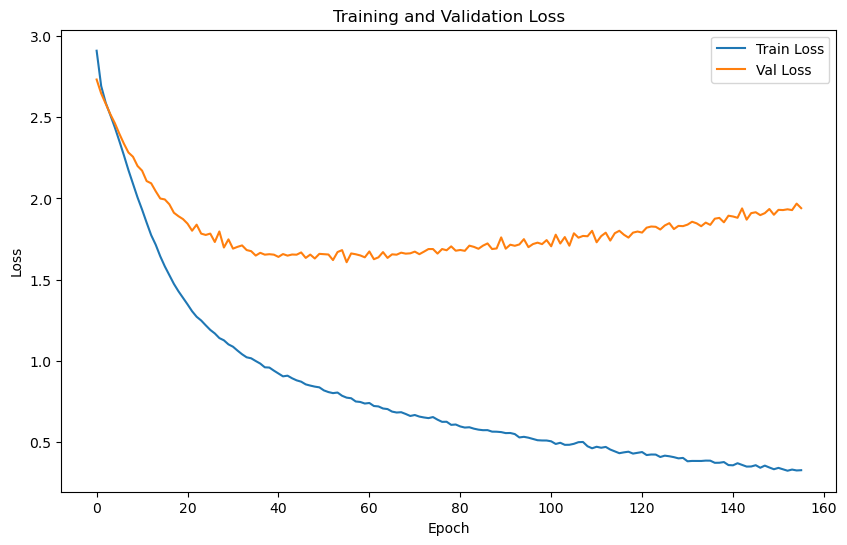

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.8817 | Test Accuracy: 50.15%


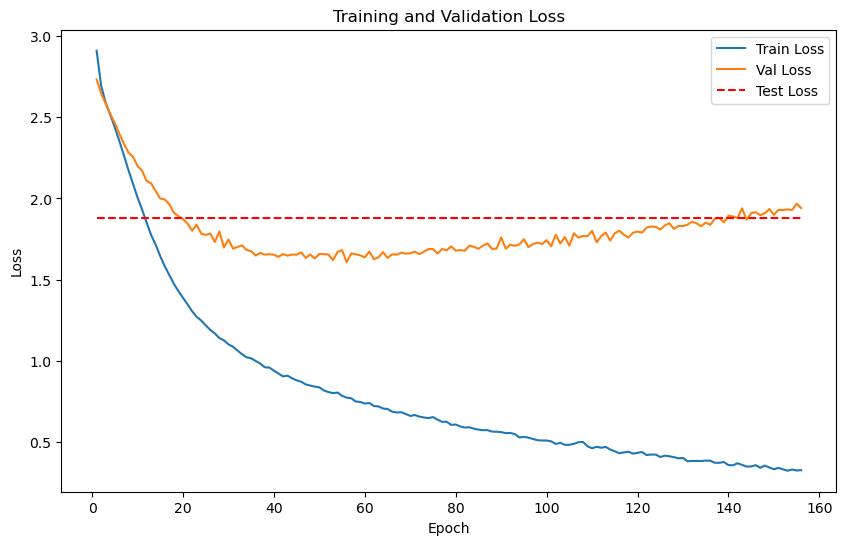

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (75, 64), 
Val labels shape: (75,)


Test embeddings shape: (9854, 64), 
Test labels shape: (9854,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.5366
Epoch [1/2000], Avg Train Loss: 8.5366
Epoch [1/2000], Avg Val Loss: 5.3800
Validation loss improved from inf to 5.3800. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.3348
Epoch [2/2000], Avg Train Loss: 8.3348
Epoch [2/2000], Avg Val Loss: 5.3258
Validation loss improved from 5.3800 to 5.3258. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.4302
Epoch [3/2000], Avg Train Loss: 8.4302
Epoch [3/2000], Avg Val Loss: 5.2728
Validation loss improved from 5.3258 to 5.2728. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.1492
Epoch [4/2000], Avg Train Loss: 8.1492
Epoch [4/2000], Avg Val Loss: 5.2215
Validation loss improved from 5.2728 to 5.2215. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.1315
Epoch [5/2000], Avg Train Loss: 8.1315
Epoch [5/2000], Avg Val Loss: 5.1715
Validation loss improved from 5.2215 to 5.1715. Saving mode

Epoch [13/2000], Avg Val Loss: 4.8152
Validation loss improved from 4.8554 to 4.8152. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.5101
Epoch [14/2000], Avg Train Loss: 7.5101
Epoch [14/2000], Avg Val Loss: 4.7762
Validation loss improved from 4.8152 to 4.7762. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.5410
Epoch [15/2000], Avg Train Loss: 7.5410
Epoch [15/2000], Avg Val Loss: 4.7383
Validation loss improved from 4.7762 to 4.7383. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.5506
Epoch [16/2000], Avg Train Loss: 7.5506
Epoch [16/2000], Avg Val Loss: 4.7015
Validation loss improved from 4.7383 to 4.7015. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.4308
Epoch [17/2000], Avg Train Loss: 7.4308
Epoch [17/2000], Avg Val Loss: 4.6658
Validation loss improved from 4.7015 to 4.6658. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.9753
Epoch [24/2000], Avg Train Loss: 6.9753
Epoch [24/2000], Avg Val Loss: 4.4458
Validation loss improved from 4.4741 to 4.4458. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.8905
Epoch [25/2000], Avg Train Loss: 6.8905
Epoch [25/2000], Avg Val Loss: 4.4185
Validation loss improved from 4.4458 to 4.4185. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.7417
Epoch [26/2000], Avg Train Loss: 6.7417
Epoch [26/2000], Avg Val Loss: 4.3920
Validation loss improved from 4.4185 to 4.3920. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.8195
Epoch [27/2000], Avg Train Loss: 6.8195
Epoch [27/2000], Avg Val Loss: 4.3666
Validation loss improved from 4.3920 to 4.3666. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 6.8103
Epoch [28/2000], Avg Train Loss: 6.8103
Epoch [28/2000], Avg Val Loss: 4.3421
Validation loss improved from 4.3666 to 4.

    Batch [1/1], Train Loss: 6.4921
Epoch [36/2000], Avg Train Loss: 6.4921
Epoch [36/2000], Avg Val Loss: 4.1751
Validation loss improved from 4.1934 to 4.1751. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 6.3646
Epoch [37/2000], Avg Train Loss: 6.3646
Epoch [37/2000], Avg Val Loss: 4.1575
Validation loss improved from 4.1751 to 4.1575. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.3192
Epoch [38/2000], Avg Train Loss: 6.3192
Epoch [38/2000], Avg Val Loss: 4.1407
Validation loss improved from 4.1575 to 4.1407. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 6.2783
Epoch [39/2000], Avg Train Loss: 6.2783
Epoch [39/2000], Avg Val Loss: 4.1246
Validation loss improved from 4.1407 to 4.1246. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.2447
Epoch [40/2000], Avg Train Loss: 6.2447
Epoch [40/2000], Avg Val Loss: 4.1091
Validation loss improved from 4.1246 to 4.

    Batch [1/1], Train Loss: 6.0169
Epoch [49/2000], Avg Train Loss: 6.0169
Epoch [49/2000], Avg Val Loss: 3.9926
Validation loss improved from 4.0037 to 3.9926. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.9563
Epoch [50/2000], Avg Train Loss: 5.9563
Epoch [50/2000], Avg Val Loss: 3.9820
Validation loss improved from 3.9926 to 3.9820. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 6.0075
Epoch [51/2000], Avg Train Loss: 6.0075
Epoch [51/2000], Avg Val Loss: 3.9718
Validation loss improved from 3.9820 to 3.9718. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 6.0126
Epoch [52/2000], Avg Train Loss: 6.0126
Epoch [52/2000], Avg Val Loss: 3.9619
Validation loss improved from 3.9718 to 3.9619. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.9491
Epoch [53/2000], Avg Train Loss: 5.9491
Epoch [53/2000], Avg Val Loss: 3.9523
Validation loss improved from 3.9619 to 3.

Epoch [58/2000], Avg Val Loss: 3.9092
Validation loss improved from 3.9173 to 3.9092. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.8055
Epoch [59/2000], Avg Train Loss: 5.8055
Epoch [59/2000], Avg Val Loss: 3.9013
Validation loss improved from 3.9092 to 3.9013. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.8425
Epoch [60/2000], Avg Train Loss: 5.8425
Epoch [60/2000], Avg Val Loss: 3.8938
Validation loss improved from 3.9013 to 3.8938. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.8249
Epoch [61/2000], Avg Train Loss: 5.8249
Epoch [61/2000], Avg Val Loss: 3.8866
Validation loss improved from 3.8938 to 3.8866. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.7759
Epoch [62/2000], Avg Train Loss: 5.7759
Epoch [62/2000], Avg Val Loss: 3.8796
Validation loss improved from 3.8866 to 3.8796. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Trai

Epoch [71/2000], Avg Val Loss: 3.8254
Validation loss improved from 3.8307 to 3.8254. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.6840
Epoch [72/2000], Avg Train Loss: 5.6840
Epoch [72/2000], Avg Val Loss: 3.8202
Validation loss improved from 3.8254 to 3.8202. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.6565
Epoch [73/2000], Avg Train Loss: 5.6565
Epoch [73/2000], Avg Val Loss: 3.8152
Validation loss improved from 3.8202 to 3.8152. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.6517
Epoch [74/2000], Avg Train Loss: 5.6517
Epoch [74/2000], Avg Val Loss: 3.8103
Validation loss improved from 3.8152 to 3.8103. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.6490
Epoch [75/2000], Avg Train Loss: 5.6490
Epoch [75/2000], Avg Val Loss: 3.8055
Validation loss improved from 3.8103 to 3.8055. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.5381
Epoch [84/2000], Avg Train Loss: 5.5381
Epoch [84/2000], Avg Val Loss: 3.7671
Validation loss improved from 3.7709 to 3.7671. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 5.5580
Epoch [85/2000], Avg Train Loss: 5.5580
Epoch [85/2000], Avg Val Loss: 3.7633
Validation loss improved from 3.7671 to 3.7633. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 5.5149
Epoch [86/2000], Avg Train Loss: 5.5149
Epoch [86/2000], Avg Val Loss: 3.7596
Validation loss improved from 3.7633 to 3.7596. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 5.5320
Epoch [87/2000], Avg Train Loss: 5.5320
Epoch [87/2000], Avg Val Loss: 3.7560
Validation loss improved from 3.7596 to 3.7560. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 5.5163
Epoch [88/2000], Avg Train Loss: 5.5163
Epoch [88/2000], Avg Val Loss: 3.7525
Validation loss improved from 3.7560 to 3.

    Batch [1/1], Train Loss: 5.5027
Epoch [94/2000], Avg Train Loss: 5.5027
Epoch [94/2000], Avg Val Loss: 3.7325
Validation loss improved from 3.7356 to 3.7325. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.5184
Epoch [95/2000], Avg Train Loss: 5.5184
Epoch [95/2000], Avg Val Loss: 3.7293
Validation loss improved from 3.7325 to 3.7293. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.4762
Epoch [96/2000], Avg Train Loss: 5.4762
Epoch [96/2000], Avg Val Loss: 3.7262
Validation loss improved from 3.7293 to 3.7262. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 5.4439
Epoch [97/2000], Avg Train Loss: 5.4439
Epoch [97/2000], Avg Val Loss: 3.7232
Validation loss improved from 3.7262 to 3.7232. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 5.4405
Epoch [98/2000], Avg Train Loss: 5.4405
Epoch [98/2000], Avg Val Loss: 3.7202
Validation loss improved from 3.7232 to 3.

    Batch [1/1], Train Loss: 5.4367
Epoch [107/2000], Avg Train Loss: 5.4367
Epoch [107/2000], Avg Val Loss: 3.6950
Validation loss improved from 3.6976 to 3.6950. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 5.4048
Epoch [108/2000], Avg Train Loss: 5.4048
Epoch [108/2000], Avg Val Loss: 3.6924
Validation loss improved from 3.6950 to 3.6924. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 5.4266
Epoch [109/2000], Avg Train Loss: 5.4266
Epoch [109/2000], Avg Val Loss: 3.6899
Validation loss improved from 3.6924 to 3.6899. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 5.4009
Epoch [110/2000], Avg Train Loss: 5.4009
Epoch [110/2000], Avg Val Loss: 3.6874
Validation loss improved from 3.6899 to 3.6874. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 5.4267
Epoch [111/2000], Avg Train Loss: 5.4267
Epoch [111/2000], Avg Val Loss: 3.6849
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3569
Epoch [123/2000], Avg Train Loss: 5.3569
Epoch [123/2000], Avg Val Loss: 3.6581
Validation loss improved from 3.6602 to 3.6581. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 5.3338
Epoch [124/2000], Avg Train Loss: 5.3338
Epoch [124/2000], Avg Val Loss: 3.6561
Validation loss improved from 3.6581 to 3.6561. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 5.3643
Epoch [125/2000], Avg Train Loss: 5.3643
Epoch [125/2000], Avg Val Loss: 3.6540
Validation loss improved from 3.6561 to 3.6540. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 5.3116
Epoch [126/2000], Avg Train Loss: 5.3116
Epoch [126/2000], Avg Val Loss: 3.6520
Validation loss improved from 3.6540 to 3.6520. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 5.3200
Epoch [127/2000], Avg Train Loss: 5.3200
Epoch [127/2000], Avg Val Loss: 3.6500
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3239
Epoch [131/2000], Avg Train Loss: 5.3239
Epoch [131/2000], Avg Val Loss: 3.6423
Validation loss improved from 3.6442 to 3.6423. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 5.2607
Epoch [132/2000], Avg Train Loss: 5.2607
Epoch [132/2000], Avg Val Loss: 3.6405
Validation loss improved from 3.6423 to 3.6405. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 5.3322
Epoch [133/2000], Avg Train Loss: 5.3322
Epoch [133/2000], Avg Val Loss: 3.6386
Validation loss improved from 3.6405 to 3.6386. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 5.3239
Epoch [134/2000], Avg Train Loss: 5.3239
Epoch [134/2000], Avg Val Loss: 3.6368
Validation loss improved from 3.6386 to 3.6368. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 5.2704
Epoch [135/2000], Avg Train Loss: 5.2704
Epoch [135/2000], Avg Val Loss: 3.6350
Validation loss improved fro

Epoch [144/2000], Avg Val Loss: 3.6189
Validation loss improved from 3.6206 to 3.6189. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 5.2611
Epoch [145/2000], Avg Train Loss: 5.2611
Epoch [145/2000], Avg Val Loss: 3.6172
Validation loss improved from 3.6189 to 3.6172. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 5.2353
Epoch [146/2000], Avg Train Loss: 5.2353
Epoch [146/2000], Avg Val Loss: 3.6154
Validation loss improved from 3.6172 to 3.6154. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 5.2100
Epoch [147/2000], Avg Train Loss: 5.2100
Epoch [147/2000], Avg Val Loss: 3.6137
Validation loss improved from 3.6154 to 3.6137. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 5.2311
Epoch [148/2000], Avg Train Loss: 5.2311
Epoch [148/2000], Avg Val Loss: 3.6120
Validation loss improved from 3.6137 to 3.6120. Saving model...

LOG: Epoch [149/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.2403
Epoch [159/2000], Avg Train Loss: 5.2403
Epoch [159/2000], Avg Val Loss: 3.5943
Validation loss improved from 3.5958 to 3.5943. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 5.2172
Epoch [160/2000], Avg Train Loss: 5.2172
Epoch [160/2000], Avg Val Loss: 3.5928
Validation loss improved from 3.5943 to 3.5928. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 5.2033
Epoch [161/2000], Avg Train Loss: 5.2033
Epoch [161/2000], Avg Val Loss: 3.5913
Validation loss improved from 3.5928 to 3.5913. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 5.1844
Epoch [162/2000], Avg Train Loss: 5.1844
Epoch [162/2000], Avg Val Loss: 3.5899
Validation loss improved from 3.5913 to 3.5899. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 5.2039
Epoch [163/2000], Avg Train Loss: 5.2039
Epoch [163/2000], Avg Val Loss: 3.5884
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1235
Epoch [166/2000], Avg Train Loss: 5.1235
Epoch [166/2000], Avg Val Loss: 3.5842
Validation loss improved from 3.5856 to 3.5842. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 5.1715
Epoch [167/2000], Avg Train Loss: 5.1715
Epoch [167/2000], Avg Val Loss: 3.5827
Validation loss improved from 3.5842 to 3.5827. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 5.1903
Epoch [168/2000], Avg Train Loss: 5.1903
Epoch [168/2000], Avg Val Loss: 3.5813
Validation loss improved from 3.5827 to 3.5813. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 5.1866
Epoch [169/2000], Avg Train Loss: 5.1866
Epoch [169/2000], Avg Val Loss: 3.5799
Validation loss improved from 3.5813 to 3.5799. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 5.1696
Epoch [170/2000], Avg Train Loss: 5.1696
Epoch [170/2000], Avg Val Loss: 3.5786
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1807
Epoch [178/2000], Avg Train Loss: 5.1807
Epoch [178/2000], Avg Val Loss: 3.5679
Validation loss improved from 3.5691 to 3.5679. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 5.1862
Epoch [179/2000], Avg Train Loss: 5.1862
Epoch [179/2000], Avg Val Loss: 3.5666
Validation loss improved from 3.5679 to 3.5666. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 5.0972
Epoch [180/2000], Avg Train Loss: 5.0972
Epoch [180/2000], Avg Val Loss: 3.5653
Validation loss improved from 3.5666 to 3.5653. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 5.1368
Epoch [181/2000], Avg Train Loss: 5.1368
Epoch [181/2000], Avg Val Loss: 3.5641
Validation loss improved from 3.5653 to 3.5641. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 5.1558
Epoch [182/2000], Avg Train Loss: 5.1558
Epoch [182/2000], Avg Val Loss: 3.5629
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1193
Epoch [195/2000], Avg Train Loss: 5.1193
Epoch [195/2000], Avg Val Loss: 3.5483
Validation loss improved from 3.5493 to 3.5483. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 5.0731
Epoch [196/2000], Avg Train Loss: 5.0731
Epoch [196/2000], Avg Val Loss: 3.5472
Validation loss improved from 3.5483 to 3.5472. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 5.1050
Epoch [197/2000], Avg Train Loss: 5.1050
Epoch [197/2000], Avg Val Loss: 3.5462
Validation loss improved from 3.5472 to 3.5462. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 5.1033
Epoch [198/2000], Avg Train Loss: 5.1033
Epoch [198/2000], Avg Val Loss: 3.5451
Validation loss improved from 3.5462 to 3.5451. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 5.0954
Epoch [199/2000], Avg Train Loss: 5.0954
Epoch [199/2000], Avg Val Loss: 3.5441
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1263
Epoch [202/2000], Avg Train Loss: 5.1263
Epoch [202/2000], Avg Val Loss: 3.5412
Validation loss improved from 3.5422 to 3.5412. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 5.0776
Epoch [203/2000], Avg Train Loss: 5.0776
Epoch [203/2000], Avg Val Loss: 3.5402
Validation loss improved from 3.5412 to 3.5402. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 5.0701
Epoch [204/2000], Avg Train Loss: 5.0701
Epoch [204/2000], Avg Val Loss: 3.5392
Validation loss improved from 3.5402 to 3.5392. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 5.0968
Epoch [205/2000], Avg Train Loss: 5.0968
Epoch [205/2000], Avg Val Loss: 3.5382
Validation loss improved from 3.5392 to 3.5382. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 5.0835
Epoch [206/2000], Avg Train Loss: 5.0835
Epoch [206/2000], Avg Val Loss: 3.5372
Validation loss improved fro

Epoch [213/2000], Avg Val Loss: 3.5307
Validation loss improved from 3.5316 to 3.5307. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 5.0606
Epoch [214/2000], Avg Train Loss: 5.0606
Epoch [214/2000], Avg Val Loss: 3.5298
Validation loss improved from 3.5307 to 3.5298. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 5.0141
Epoch [215/2000], Avg Train Loss: 5.0141
Epoch [215/2000], Avg Val Loss: 3.5289
Validation loss improved from 3.5298 to 3.5289. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 5.0266
Epoch [216/2000], Avg Train Loss: 5.0266
Epoch [216/2000], Avg Val Loss: 3.5280
Validation loss improved from 3.5289 to 3.5280. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 5.0594
Epoch [217/2000], Avg Train Loss: 5.0594
Epoch [217/2000], Avg Val Loss: 3.5272
Validation loss improved from 3.5280 to 3.5272. Saving model...

LOG: Epoch [218/2000] - Training
    Bat

Epoch [230/2000], Avg Val Loss: 3.5154
Validation loss improved from 3.5163 to 3.5154. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 5.0421
Epoch [231/2000], Avg Train Loss: 5.0421
Epoch [231/2000], Avg Val Loss: 3.5146
Validation loss improved from 3.5154 to 3.5146. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 5.0258
Epoch [232/2000], Avg Train Loss: 5.0258
Epoch [232/2000], Avg Val Loss: 3.5138
Validation loss improved from 3.5146 to 3.5138. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 5.0330
Epoch [233/2000], Avg Train Loss: 5.0330
Epoch [233/2000], Avg Val Loss: 3.5129
Validation loss improved from 3.5138 to 3.5129. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 4.9870
Epoch [234/2000], Avg Train Loss: 4.9870
Epoch [234/2000], Avg Val Loss: 3.5121
Validation loss improved from 3.5129 to 3.5121. Saving model...

LOG: Epoch [235/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.0004
Epoch [238/2000], Avg Train Loss: 5.0004
Epoch [238/2000], Avg Val Loss: 3.5091
Validation loss improved from 3.5098 to 3.5091. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 5.0016
Epoch [239/2000], Avg Train Loss: 5.0016
Epoch [239/2000], Avg Val Loss: 3.5083
Validation loss improved from 3.5091 to 3.5083. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 4.9857
Epoch [240/2000], Avg Train Loss: 4.9857
Epoch [240/2000], Avg Val Loss: 3.5075
Validation loss improved from 3.5083 to 3.5075. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 5.0206
Epoch [241/2000], Avg Train Loss: 5.0206
Epoch [241/2000], Avg Val Loss: 3.5067
Validation loss improved from 3.5075 to 3.5067. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 5.0081
Epoch [242/2000], Avg Train Loss: 5.0081
Epoch [242/2000], Avg Val Loss: 3.5059
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0167
Epoch [248/2000], Avg Train Loss: 5.0167
Epoch [248/2000], Avg Val Loss: 3.5015
Validation loss improved from 3.5022 to 3.5015. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 5.0328
Epoch [249/2000], Avg Train Loss: 5.0328
Epoch [249/2000], Avg Val Loss: 3.5007
Validation loss improved from 3.5015 to 3.5007. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 4.9936
Epoch [250/2000], Avg Train Loss: 4.9936
Epoch [250/2000], Avg Val Loss: 3.5000
Validation loss improved from 3.5007 to 3.5000. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 4.9995
Epoch [251/2000], Avg Train Loss: 4.9995
Epoch [251/2000], Avg Val Loss: 3.4993
Validation loss improved from 3.5000 to 3.4993. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 4.9603
Epoch [252/2000], Avg Train Loss: 4.9603
Epoch [252/2000], Avg Val Loss: 3.4985
Validation loss improved fro

Epoch [267/2000], Avg Val Loss: 3.4882
Validation loss improved from 3.4888 to 3.4882. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 4.9417
Epoch [268/2000], Avg Train Loss: 4.9417
Epoch [268/2000], Avg Val Loss: 3.4875
Validation loss improved from 3.4882 to 3.4875. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 4.9536
Epoch [269/2000], Avg Train Loss: 4.9536
Epoch [269/2000], Avg Val Loss: 3.4869
Validation loss improved from 3.4875 to 3.4869. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 4.9690
Epoch [270/2000], Avg Train Loss: 4.9690
Epoch [270/2000], Avg Val Loss: 3.4862
Validation loss improved from 3.4869 to 3.4862. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 4.9625
Epoch [271/2000], Avg Train Loss: 4.9625
Epoch [271/2000], Avg Val Loss: 3.4856
Validation loss improved from 3.4862 to 3.4856. Saving model...

LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 4.9392
Epoch [272/2000], Avg Train Loss: 4.9392
Epoch [272/2000], Avg Val Loss: 3.4850
Validation loss improved from 3.4856 to 3.4850. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 4.9483
Epoch [273/2000], Avg Train Loss: 4.9483
Epoch [273/2000], Avg Val Loss: 3.4844
Validation loss improved from 3.4850 to 3.4844. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 4.9598
Epoch [274/2000], Avg Train Loss: 4.9598
Epoch [274/2000], Avg Val Loss: 3.4838
Validation loss improved from 3.4844 to 3.4838. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 4.9448
Epoch [275/2000], Avg Train Loss: 4.9448
Epoch [275/2000], Avg Val Loss: 3.4832
Validation loss improved from 3.4838 to 3.4832. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 4.9672
Epoch [276/2000], Avg Train Loss: 4.9672
Epoch [276/2000], Avg Val Loss: 3.4825
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9316
Epoch [282/2000], Avg Train Loss: 4.9316
Epoch [282/2000], Avg Val Loss: 3.4786
Validation loss improved from 3.4792 to 3.4786. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 4.9282
Epoch [283/2000], Avg Train Loss: 4.9282
Epoch [283/2000], Avg Val Loss: 3.4779
Validation loss improved from 3.4786 to 3.4779. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 4.9233
Epoch [284/2000], Avg Train Loss: 4.9233
Epoch [284/2000], Avg Val Loss: 3.4772
Validation loss improved from 3.4779 to 3.4772. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 4.9241
Epoch [285/2000], Avg Train Loss: 4.9241
Epoch [285/2000], Avg Val Loss: 3.4765
Validation loss improved from 3.4772 to 3.4765. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 4.9375
Epoch [286/2000], Avg Train Loss: 4.9375
Epoch [286/2000], Avg Val Loss: 3.4759
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9080
Epoch [302/2000], Avg Train Loss: 4.9080
Epoch [302/2000], Avg Val Loss: 3.4666
Validation loss improved from 3.4671 to 3.4666. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 4.8909
Epoch [303/2000], Avg Train Loss: 4.8909
Epoch [303/2000], Avg Val Loss: 3.4662
Validation loss improved from 3.4666 to 3.4662. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 4.8926
Epoch [304/2000], Avg Train Loss: 4.8926
Epoch [304/2000], Avg Val Loss: 3.4658
Validation loss improved from 3.4662 to 3.4658. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 4.9181
Epoch [305/2000], Avg Train Loss: 4.9181
Epoch [305/2000], Avg Val Loss: 3.4653
Validation loss improved from 3.4658 to 3.4653. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 4.8795
Epoch [306/2000], Avg Train Loss: 4.8795
Epoch [306/2000], Avg Val Loss: 3.4649
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8446
Epoch [317/2000], Avg Train Loss: 4.8446
Epoch [317/2000], Avg Val Loss: 3.4606
Validation loss improved from 3.4610 to 3.4606. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 4.9003
Epoch [318/2000], Avg Train Loss: 4.9003
Epoch [318/2000], Avg Val Loss: 3.4602
Validation loss improved from 3.4606 to 3.4602. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 4.8862
Epoch [319/2000], Avg Train Loss: 4.8862
Epoch [319/2000], Avg Val Loss: 3.4599
Validation loss improved from 3.4602 to 3.4599. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 4.8939
Epoch [320/2000], Avg Train Loss: 4.8939
Epoch [320/2000], Avg Val Loss: 3.4595
Validation loss improved from 3.4599 to 3.4595. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 4.8855
Epoch [321/2000], Avg Train Loss: 4.8855
Epoch [321/2000], Avg Val Loss: 3.4592
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8470
Epoch [335/2000], Avg Train Loss: 4.8470
Epoch [335/2000], Avg Val Loss: 3.4538
Validation loss improved from 3.4542 to 3.4538. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 4.8585
Epoch [336/2000], Avg Train Loss: 4.8585
Epoch [336/2000], Avg Val Loss: 3.4533
Validation loss improved from 3.4538 to 3.4533. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.8745
Epoch [337/2000], Avg Train Loss: 4.8745
Epoch [337/2000], Avg Val Loss: 3.4529
Validation loss improved from 3.4533 to 3.4529. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.8346
Epoch [338/2000], Avg Train Loss: 4.8346
Epoch [338/2000], Avg Val Loss: 3.4524
Validation loss improved from 3.4529 to 3.4524. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.8550
Epoch [339/2000], Avg Train Loss: 4.8550
Epoch [339/2000], Avg Val Loss: 3.4520
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8421
Epoch [354/2000], Avg Train Loss: 4.8421
Epoch [354/2000], Avg Val Loss: 3.4467
Validation loss improved from 3.4471 to 3.4467. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 4.8376
Epoch [355/2000], Avg Train Loss: 4.8376
Epoch [355/2000], Avg Val Loss: 3.4463
Validation loss improved from 3.4467 to 3.4463. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 4.8447
Epoch [356/2000], Avg Train Loss: 4.8447
Epoch [356/2000], Avg Val Loss: 3.4459
Validation loss improved from 3.4463 to 3.4459. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 4.8440
Epoch [357/2000], Avg Train Loss: 4.8440
Epoch [357/2000], Avg Val Loss: 3.4456
Validation loss improved from 3.4459 to 3.4456. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 4.8196
Epoch [358/2000], Avg Train Loss: 4.8196
Epoch [358/2000], Avg Val Loss: 3.4453
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8212
Epoch [372/2000], Avg Train Loss: 4.8212
Epoch [372/2000], Avg Val Loss: 3.4427
Validation loss improved from 3.4429 to 3.4427. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 4.8396
Epoch [373/2000], Avg Train Loss: 4.8396
Epoch [373/2000], Avg Val Loss: 3.4425
Validation loss improved from 3.4427 to 3.4425. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 4.8283
Epoch [374/2000], Avg Train Loss: 4.8283
Epoch [374/2000], Avg Val Loss: 3.4423
Validation loss improved from 3.4425 to 3.4423. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 4.7943
Epoch [375/2000], Avg Train Loss: 4.7943
Epoch [375/2000], Avg Val Loss: 3.4421
Validation loss improved from 3.4423 to 3.4421. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 4.8237
Epoch [376/2000], Avg Train Loss: 4.8237
Epoch [376/2000], Avg Val Loss: 3.4419
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7892
Epoch [391/2000], Avg Train Loss: 4.7892
Epoch [391/2000], Avg Val Loss: 3.4379
Validation loss improved from 3.4382 to 3.4379. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 4.7878
Epoch [392/2000], Avg Train Loss: 4.7878
Epoch [392/2000], Avg Val Loss: 3.4376
Validation loss improved from 3.4379 to 3.4376. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 4.7728
Epoch [393/2000], Avg Train Loss: 4.7728
Epoch [393/2000], Avg Val Loss: 3.4373
Validation loss improved from 3.4376 to 3.4373. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 4.7853
Epoch [394/2000], Avg Train Loss: 4.7853
Epoch [394/2000], Avg Val Loss: 3.4370
Validation loss improved from 3.4373 to 3.4370. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 4.7736
Epoch [395/2000], Avg Train Loss: 4.7736
Epoch [395/2000], Avg Val Loss: 3.4367
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7975
Epoch [410/2000], Avg Train Loss: 4.7975
Epoch [410/2000], Avg Val Loss: 3.4314
Validation loss improved from 3.4317 to 3.4314. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 4.7781
Epoch [411/2000], Avg Train Loss: 4.7781
Epoch [411/2000], Avg Val Loss: 3.4311
Validation loss improved from 3.4314 to 3.4311. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.7517
Epoch [412/2000], Avg Train Loss: 4.7517
Epoch [412/2000], Avg Val Loss: 3.4307
Validation loss improved from 3.4311 to 3.4307. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 4.7646
Epoch [413/2000], Avg Train Loss: 4.7646
Epoch [413/2000], Avg Val Loss: 3.4304
Validation loss improved from 3.4307 to 3.4304. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 4.7884
Epoch [414/2000], Avg Train Loss: 4.7884
Epoch [414/2000], Avg Val Loss: 3.4300
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7548
Epoch [428/2000], Avg Train Loss: 4.7548
Epoch [428/2000], Avg Val Loss: 3.4253
Validation loss improved from 3.4256 to 3.4253. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 4.7581
Epoch [429/2000], Avg Train Loss: 4.7581
Epoch [429/2000], Avg Val Loss: 3.4250
Validation loss improved from 3.4253 to 3.4250. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 4.7443
Epoch [430/2000], Avg Train Loss: 4.7443
Epoch [430/2000], Avg Val Loss: 3.4247
Validation loss improved from 3.4250 to 3.4247. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 4.7242
Epoch [431/2000], Avg Train Loss: 4.7242
Epoch [431/2000], Avg Val Loss: 3.4244
Validation loss improved from 3.4247 to 3.4244. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 4.7436
Epoch [432/2000], Avg Train Loss: 4.7436
Epoch [432/2000], Avg Val Loss: 3.4241
Validation loss improved fro

Epoch [447/2000], Avg Val Loss: 3.4199
Validation loss improved from 3.4203 to 3.4199. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 4.7378
Epoch [448/2000], Avg Train Loss: 4.7378
Epoch [448/2000], Avg Val Loss: 3.4195
Validation loss improved from 3.4199 to 3.4195. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 4.7545
Epoch [449/2000], Avg Train Loss: 4.7545
Epoch [449/2000], Avg Val Loss: 3.4192
Validation loss improved from 3.4195 to 3.4192. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 4.7338
Epoch [450/2000], Avg Train Loss: 4.7338
Epoch [450/2000], Avg Val Loss: 3.4188
Validation loss improved from 3.4192 to 3.4188. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 4.6861
Epoch [451/2000], Avg Train Loss: 4.6861
Epoch [451/2000], Avg Val Loss: 3.4184
Validation loss improved from 3.4188 to 3.4184. Saving model...

LOG: Epoch [452/2000] - Training
    Bat

Epoch [462/2000], Avg Val Loss: 3.4152
Validation loss improved from 3.4155 to 3.4152. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 4.7555
Epoch [463/2000], Avg Train Loss: 4.7555
Epoch [463/2000], Avg Val Loss: 3.4148
Validation loss improved from 3.4152 to 3.4148. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 4.7349
Epoch [464/2000], Avg Train Loss: 4.7349
Epoch [464/2000], Avg Val Loss: 3.4145
Validation loss improved from 3.4148 to 3.4145. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 4.7065
Epoch [465/2000], Avg Train Loss: 4.7065
Epoch [465/2000], Avg Val Loss: 3.4142
Validation loss improved from 3.4145 to 3.4142. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 4.7078
Epoch [466/2000], Avg Train Loss: 4.7078
Epoch [466/2000], Avg Val Loss: 3.4139
Validation loss improved from 3.4142 to 3.4139. Saving model...

LOG: Epoch [467/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7148
Epoch [483/2000], Avg Train Loss: 4.7148
Epoch [483/2000], Avg Val Loss: 3.4108
Validation loss improved from 3.4110 to 3.4108. Saving model...

LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 4.7042
Epoch [484/2000], Avg Train Loss: 4.7042
Epoch [484/2000], Avg Val Loss: 3.4106
Validation loss improved from 3.4108 to 3.4106. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 4.7479
Epoch [485/2000], Avg Train Loss: 4.7479
Epoch [485/2000], Avg Val Loss: 3.4104
Validation loss improved from 3.4106 to 3.4104. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 4.6825
Epoch [486/2000], Avg Train Loss: 4.6825
Epoch [486/2000], Avg Val Loss: 3.4102
Validation loss improved from 3.4104 to 3.4102. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 4.6758
Epoch [487/2000], Avg Train Loss: 4.6758
Epoch [487/2000], Avg Val Loss: 3.4099
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6523
Epoch [499/2000], Avg Train Loss: 4.6523
Epoch [499/2000], Avg Val Loss: 3.4077
Validation loss improved from 3.4079 to 3.4077. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 4.7246
Epoch [500/2000], Avg Train Loss: 4.7246
Epoch [500/2000], Avg Val Loss: 3.4075
Validation loss improved from 3.4077 to 3.4075. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 4.7188
Epoch [501/2000], Avg Train Loss: 4.7188
Epoch [501/2000], Avg Val Loss: 3.4074
Validation loss improved from 3.4075 to 3.4074. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 4.6879
Epoch [502/2000], Avg Train Loss: 4.6879
Epoch [502/2000], Avg Val Loss: 3.4073
Validation loss improved from 3.4074 to 3.4073. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 4.6766
Epoch [503/2000], Avg Train Loss: 4.6766
Epoch [503/2000], Avg Val Loss: 3.4072
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6852
Epoch [521/2000], Avg Train Loss: 4.6852
Epoch [521/2000], Avg Val Loss: 3.4020
Validation loss improved from 3.4022 to 3.4020. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 4.6858
Epoch [522/2000], Avg Train Loss: 4.6858
Epoch [522/2000], Avg Val Loss: 3.4019
Validation loss improved from 3.4020 to 3.4019. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 4.6880
Epoch [523/2000], Avg Train Loss: 4.6880
Epoch [523/2000], Avg Val Loss: 3.4018
Validation loss improved from 3.4019 to 3.4018. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 4.7061
Epoch [524/2000], Avg Train Loss: 4.7061
Epoch [524/2000], Avg Val Loss: 3.4017
Validation loss improved from 3.4018 to 3.4017. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 4.6943
Epoch [525/2000], Avg Train Loss: 4.6943
Epoch [525/2000], Avg Val Loss: 3.4016
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6335
Epoch [537/2000], Avg Train Loss: 4.6335
Epoch [537/2000], Avg Val Loss: 3.4003
Validation loss improved from 3.4005 to 3.4003. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 4.6356
Epoch [538/2000], Avg Train Loss: 4.6356
Epoch [538/2000], Avg Val Loss: 3.4001
Validation loss improved from 3.4003 to 3.4001. Saving model...

LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 4.6829
Epoch [539/2000], Avg Train Loss: 4.6829
Epoch [539/2000], Avg Val Loss: 3.3998
Validation loss improved from 3.4001 to 3.3998. Saving model...

LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 4.6594
Epoch [540/2000], Avg Train Loss: 4.6594
Epoch [540/2000], Avg Val Loss: 3.3996
Validation loss improved from 3.3998 to 3.3996. Saving model...

LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 4.6790
Epoch [541/2000], Avg Train Loss: 4.6790
Epoch [541/2000], Avg Val Loss: 3.3995
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7063
Epoch [560/2000], Avg Train Loss: 4.7063
Epoch [560/2000], Avg Val Loss: 3.3972
Validation loss improved from 3.3973 to 3.3972. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 4.6710
Epoch [561/2000], Avg Train Loss: 4.6710
Epoch [561/2000], Avg Val Loss: 3.3970
Validation loss improved from 3.3972 to 3.3970. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 4.6291
Epoch [562/2000], Avg Train Loss: 4.6291
Epoch [562/2000], Avg Val Loss: 3.3968
Validation loss improved from 3.3970 to 3.3968. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 4.6462
Epoch [563/2000], Avg Train Loss: 4.6462
Epoch [563/2000], Avg Val Loss: 3.3966
Validation loss improved from 3.3968 to 3.3966. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 4.6269
Epoch [564/2000], Avg Train Loss: 4.6269
Epoch [564/2000], Avg Val Loss: 3.3964
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6213
Epoch [579/2000], Avg Train Loss: 4.6213
Epoch [579/2000], Avg Val Loss: 3.3933
Validation loss improved from 3.3934 to 3.3933. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 4.6017
Epoch [580/2000], Avg Train Loss: 4.6017
Epoch [580/2000], Avg Val Loss: 3.3931
Validation loss improved from 3.3933 to 3.3931. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 4.6139
Epoch [581/2000], Avg Train Loss: 4.6139
Epoch [581/2000], Avg Val Loss: 3.3930
Validation loss improved from 3.3931 to 3.3930. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 4.6078
Epoch [582/2000], Avg Train Loss: 4.6078
Epoch [582/2000], Avg Val Loss: 3.3929
Validation loss improved from 3.3930 to 3.3929. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 4.6222
Epoch [583/2000], Avg Train Loss: 4.6222
Epoch [583/2000], Avg Val Loss: 3.3928
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6592
Epoch [599/2000], Avg Train Loss: 4.6592
Epoch [599/2000], Avg Val Loss: 3.3892
Validation loss improved from 3.3895 to 3.3892. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 4.6352
Epoch [600/2000], Avg Train Loss: 4.6352
Epoch [600/2000], Avg Val Loss: 3.3889
Validation loss improved from 3.3892 to 3.3889. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 4.6184
Epoch [601/2000], Avg Train Loss: 4.6184
Epoch [601/2000], Avg Val Loss: 3.3887
Validation loss improved from 3.3889 to 3.3887. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 4.6068
Epoch [602/2000], Avg Train Loss: 4.6068
Epoch [602/2000], Avg Val Loss: 3.3886
Validation loss improved from 3.3887 to 3.3886. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 4.5999
Epoch [603/2000], Avg Train Loss: 4.5999
Epoch [603/2000], Avg Val Loss: 3.3885
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6270
Epoch [619/2000], Avg Train Loss: 4.6270
Epoch [619/2000], Avg Val Loss: 3.3856
Validation loss improved from 3.3858 to 3.3856. Saving model...

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 4.6106
Epoch [620/2000], Avg Train Loss: 4.6106
Epoch [620/2000], Avg Val Loss: 3.3854
Validation loss improved from 3.3856 to 3.3854. Saving model...

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 4.6089
Epoch [621/2000], Avg Train Loss: 4.6089
Epoch [621/2000], Avg Val Loss: 3.3851
Validation loss improved from 3.3854 to 3.3851. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 4.6169
Epoch [622/2000], Avg Train Loss: 4.6169
Epoch [622/2000], Avg Val Loss: 3.3848
Validation loss improved from 3.3851 to 3.3848. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 4.5910
Epoch [623/2000], Avg Train Loss: 4.5910
Epoch [623/2000], Avg Val Loss: 3.3845
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6011
Epoch [638/2000], Avg Train Loss: 4.6011
Epoch [638/2000], Avg Val Loss: 3.3818
Validation loss improved from 3.3819 to 3.3818. Saving model...

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 4.6312
Epoch [639/2000], Avg Train Loss: 4.6312
Epoch [639/2000], Avg Val Loss: 3.3817
Validation loss improved from 3.3818 to 3.3817. Saving model...

LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 4.6227
Epoch [640/2000], Avg Train Loss: 4.6227
Epoch [640/2000], Avg Val Loss: 3.3815
Validation loss improved from 3.3817 to 3.3815. Saving model...

LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 4.6158
Epoch [641/2000], Avg Train Loss: 4.6158
Epoch [641/2000], Avg Val Loss: 3.3813
Validation loss improved from 3.3815 to 3.3813. Saving model...

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 4.6202
Epoch [642/2000], Avg Train Loss: 4.6202
Epoch [642/2000], Avg Val Loss: 3.3812
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6121
Epoch [657/2000], Avg Train Loss: 4.6121
Epoch [657/2000], Avg Val Loss: 3.3782
Validation loss improved from 3.3784 to 3.3782. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 4.5893
Epoch [658/2000], Avg Train Loss: 4.5893
Epoch [658/2000], Avg Val Loss: 3.3781
Validation loss improved from 3.3782 to 3.3781. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 4.5953
Epoch [659/2000], Avg Train Loss: 4.5953
Epoch [659/2000], Avg Val Loss: 3.3779
Validation loss improved from 3.3781 to 3.3779. Saving model...

LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 4.5723
Epoch [660/2000], Avg Train Loss: 4.5723
Epoch [660/2000], Avg Val Loss: 3.3777
Validation loss improved from 3.3779 to 3.3777. Saving model...

LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 4.5613
Epoch [661/2000], Avg Train Loss: 4.5613
Epoch [661/2000], Avg Val Loss: 3.3776
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5895
Epoch [676/2000], Avg Train Loss: 4.5895
Epoch [676/2000], Avg Val Loss: 3.3742
Validation loss improved from 3.3744 to 3.3742. Saving model...

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 4.5900
Epoch [677/2000], Avg Train Loss: 4.5900
Epoch [677/2000], Avg Val Loss: 3.3739
Validation loss improved from 3.3742 to 3.3739. Saving model...

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 4.5651
Epoch [678/2000], Avg Train Loss: 4.5651
Epoch [678/2000], Avg Val Loss: 3.3737
Validation loss improved from 3.3739 to 3.3737. Saving model...

LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 4.6216
Epoch [679/2000], Avg Train Loss: 4.6216
Epoch [679/2000], Avg Val Loss: 3.3735
Validation loss improved from 3.3737 to 3.3735. Saving model...

LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 4.5993
Epoch [680/2000], Avg Train Loss: 4.5993
Epoch [680/2000], Avg Val Loss: 3.3733
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5869
Epoch [693/2000], Avg Train Loss: 4.5869
Epoch [693/2000], Avg Val Loss: 3.3713
Validation loss improved from 3.3715 to 3.3713. Saving model...

LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 4.5725
Epoch [694/2000], Avg Train Loss: 4.5725
Epoch [694/2000], Avg Val Loss: 3.3711
Validation loss improved from 3.3713 to 3.3711. Saving model...

LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 4.5938
Epoch [695/2000], Avg Train Loss: 4.5938
Epoch [695/2000], Avg Val Loss: 3.3707
Validation loss improved from 3.3711 to 3.3707. Saving model...

LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 4.5653
Epoch [696/2000], Avg Train Loss: 4.5653
Epoch [696/2000], Avg Val Loss: 3.3704
Validation loss improved from 3.3707 to 3.3704. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 4.5727
Epoch [697/2000], Avg Train Loss: 4.5727
Epoch [697/2000], Avg Val Loss: 3.3701
Validation loss improved fro

Epoch [710/2000], Avg Val Loss: 3.3665
Validation loss improved from 3.3669 to 3.3665. Saving model...

LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 4.5775
Epoch [711/2000], Avg Train Loss: 4.5775
Epoch [711/2000], Avg Val Loss: 3.3662
Validation loss improved from 3.3665 to 3.3662. Saving model...

LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 4.5596
Epoch [712/2000], Avg Train Loss: 4.5596
Epoch [712/2000], Avg Val Loss: 3.3658
Validation loss improved from 3.3662 to 3.3658. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 4.5760
Epoch [713/2000], Avg Train Loss: 4.5760
Epoch [713/2000], Avg Val Loss: 3.3655
Validation loss improved from 3.3658 to 3.3655. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 4.5486
Epoch [714/2000], Avg Train Loss: 4.5486
Epoch [714/2000], Avg Val Loss: 3.3652
Validation loss improved from 3.3655 to 3.3652. Saving model...

LOG: Epoch [715/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5293
Epoch [730/2000], Avg Train Loss: 4.5293
Epoch [730/2000], Avg Val Loss: 3.3628
Validation loss improved from 3.3628 to 3.3628. Saving model...

LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 4.5540
Epoch [731/2000], Avg Train Loss: 4.5540
Epoch [731/2000], Avg Val Loss: 3.3628
Validation loss improved from 3.3628 to 3.3628. Saving model...

LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 4.5984
Epoch [732/2000], Avg Train Loss: 4.5984
Epoch [732/2000], Avg Val Loss: 3.3627
Validation loss improved from 3.3628 to 3.3627. Saving model...

LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 4.5645
Epoch [733/2000], Avg Train Loss: 4.5645
Epoch [733/2000], Avg Val Loss: 3.3626
Validation loss improved from 3.3627 to 3.3626. Saving model...

LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 4.5783
Epoch [734/2000], Avg Train Loss: 4.5783
Epoch [734/2000], Avg Val Loss: 3.3625
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5309
Epoch [749/2000], Avg Train Loss: 4.5309
Epoch [749/2000], Avg Val Loss: 3.3576
Validation loss improved from 3.3579 to 3.3576. Saving model...

LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 4.5452
Epoch [750/2000], Avg Train Loss: 4.5452
Epoch [750/2000], Avg Val Loss: 3.3573
Validation loss improved from 3.3576 to 3.3573. Saving model...

LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 4.5146
Epoch [751/2000], Avg Train Loss: 4.5146
Epoch [751/2000], Avg Val Loss: 3.3571
Validation loss improved from 3.3573 to 3.3571. Saving model...

LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 4.5173
Epoch [752/2000], Avg Train Loss: 4.5173
Epoch [752/2000], Avg Val Loss: 3.3568
Validation loss improved from 3.3571 to 3.3568. Saving model...

LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 4.5425
Epoch [753/2000], Avg Train Loss: 4.5425
Epoch [753/2000], Avg Val Loss: 3.3566
Validation loss improved fro

Epoch [767/2000], Avg Val Loss: 3.3544
Validation loss improved from 3.3544 to 3.3544. Saving model...

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 4.5223
Epoch [768/2000], Avg Train Loss: 4.5223
Epoch [768/2000], Avg Val Loss: 3.3544
Validation loss improved from 3.3544 to 3.3544. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 4.5332
Epoch [769/2000], Avg Train Loss: 4.5332
Epoch [769/2000], Avg Val Loss: 3.3544
Validation loss did not improve. Patience: 1/100

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 4.5285
Epoch [770/2000], Avg Train Loss: 4.5285
Epoch [770/2000], Avg Val Loss: 3.3544
Validation loss did not improve. Patience: 2/100

LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 4.5029
Epoch [771/2000], Avg Train Loss: 4.5029
Epoch [771/2000], Avg Val Loss: 3.3545
Validation loss did not improve. Patience: 3/100

LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 4.5223
Epoch [772/2000]

    Batch [1/1], Train Loss: 4.5596
Epoch [787/2000], Avg Train Loss: 4.5596
Epoch [787/2000], Avg Val Loss: 3.3548
Validation loss did not improve. Patience: 19/100

LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 4.5238
Epoch [788/2000], Avg Train Loss: 4.5238
Epoch [788/2000], Avg Val Loss: 3.3545
Validation loss did not improve. Patience: 20/100

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 4.5039
Epoch [789/2000], Avg Train Loss: 4.5039
Epoch [789/2000], Avg Val Loss: 3.3543
Validation loss improved from 3.3544 to 3.3543. Saving model...

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 4.4992
Epoch [790/2000], Avg Train Loss: 4.4992
Epoch [790/2000], Avg Val Loss: 3.3542
Validation loss improved from 3.3543 to 3.3542. Saving model...

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 4.4960
Epoch [791/2000], Avg Train Loss: 4.4960
Epoch [791/2000], Avg Val Loss: 3.3539
Validation loss improved from 3.3542 to 3.3539. Saving m

    Batch [1/1], Train Loss: 4.5213
Epoch [805/2000], Avg Train Loss: 4.5213
Epoch [805/2000], Avg Val Loss: 3.3494
Validation loss improved from 3.3496 to 3.3494. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 4.4944
Epoch [806/2000], Avg Train Loss: 4.4944
Epoch [806/2000], Avg Val Loss: 3.3493
Validation loss improved from 3.3494 to 3.3493. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 4.5141
Epoch [807/2000], Avg Train Loss: 4.5141
Epoch [807/2000], Avg Val Loss: 3.3491
Validation loss improved from 3.3493 to 3.3491. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 4.5521
Epoch [808/2000], Avg Train Loss: 4.5521
Epoch [808/2000], Avg Val Loss: 3.3489
Validation loss improved from 3.3491 to 3.3489. Saving model...

LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 4.4952
Epoch [809/2000], Avg Train Loss: 4.4952
Epoch [809/2000], Avg Val Loss: 3.3487
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5071
Epoch [811/2000], Avg Train Loss: 4.5071
Epoch [811/2000], Avg Val Loss: 3.3484
Validation loss improved from 3.3486 to 3.3484. Saving model...

LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 4.5356
Epoch [812/2000], Avg Train Loss: 4.5356
Epoch [812/2000], Avg Val Loss: 3.3482
Validation loss improved from 3.3484 to 3.3482. Saving model...

LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 4.5046
Epoch [813/2000], Avg Train Loss: 4.5046
Epoch [813/2000], Avg Val Loss: 3.3479
Validation loss improved from 3.3482 to 3.3479. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 4.5031
Epoch [814/2000], Avg Train Loss: 4.5031
Epoch [814/2000], Avg Val Loss: 3.3476
Validation loss improved from 3.3479 to 3.3476. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 4.4925
Epoch [815/2000], Avg Train Loss: 4.4925
Epoch [815/2000], Avg Val Loss: 3.3473
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4909
Epoch [826/2000], Avg Train Loss: 4.4909
Epoch [826/2000], Avg Val Loss: 3.3446
Validation loss improved from 3.3446 to 3.3446. Saving model...

LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 4.5290
Epoch [827/2000], Avg Train Loss: 4.5290
Epoch [827/2000], Avg Val Loss: 3.3444
Validation loss improved from 3.3446 to 3.3444. Saving model...

LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 4.4766
Epoch [828/2000], Avg Train Loss: 4.4766
Epoch [828/2000], Avg Val Loss: 3.3443
Validation loss improved from 3.3444 to 3.3443. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 4.5517
Epoch [829/2000], Avg Train Loss: 4.5517
Epoch [829/2000], Avg Val Loss: 3.3443
Validation loss improved from 3.3443 to 3.3443. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 4.4871
Epoch [830/2000], Avg Train Loss: 4.4871
Epoch [830/2000], Avg Val Loss: 3.3442
Validation loss improved fro

Epoch [848/2000], Avg Val Loss: 3.3414
Validation loss improved from 3.3417 to 3.3414. Saving model...

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 4.4889
Epoch [849/2000], Avg Train Loss: 4.4889
Epoch [849/2000], Avg Val Loss: 3.3410
Validation loss improved from 3.3414 to 3.3410. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 4.4799
Epoch [850/2000], Avg Train Loss: 4.4799
Epoch [850/2000], Avg Val Loss: 3.3407
Validation loss improved from 3.3410 to 3.3407. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 4.4911
Epoch [851/2000], Avg Train Loss: 4.4911
Epoch [851/2000], Avg Val Loss: 3.3403
Validation loss improved from 3.3407 to 3.3403. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 4.4998
Epoch [852/2000], Avg Train Loss: 4.4998
Epoch [852/2000], Avg Val Loss: 3.3399
Validation loss improved from 3.3403 to 3.3399. Saving model...

LOG: Epoch [853/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4943
Epoch [859/2000], Avg Train Loss: 4.4943
Epoch [859/2000], Avg Val Loss: 3.3373
Validation loss improved from 3.3377 to 3.3373. Saving model...

LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 4.5111
Epoch [860/2000], Avg Train Loss: 4.5111
Epoch [860/2000], Avg Val Loss: 3.3369
Validation loss improved from 3.3373 to 3.3369. Saving model...

LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 4.4931
Epoch [861/2000], Avg Train Loss: 4.4931
Epoch [861/2000], Avg Val Loss: 3.3364
Validation loss improved from 3.3369 to 3.3364. Saving model...

LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 4.4931
Epoch [862/2000], Avg Train Loss: 4.4931
Epoch [862/2000], Avg Val Loss: 3.3359
Validation loss improved from 3.3364 to 3.3359. Saving model...

LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 4.4785
Epoch [863/2000], Avg Train Loss: 4.4785
Epoch [863/2000], Avg Val Loss: 3.3355
Validation loss improved fro

Epoch [887/2000], Avg Val Loss: 3.3281
Validation loss improved from 3.3286 to 3.3281. Saving model...

LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 4.4800
Epoch [888/2000], Avg Train Loss: 4.4800
Epoch [888/2000], Avg Val Loss: 3.3275
Validation loss improved from 3.3281 to 3.3275. Saving model...

LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 4.4395
Epoch [889/2000], Avg Train Loss: 4.4395
Epoch [889/2000], Avg Val Loss: 3.3270
Validation loss improved from 3.3275 to 3.3270. Saving model...

LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 4.4652
Epoch [890/2000], Avg Train Loss: 4.4652
Epoch [890/2000], Avg Val Loss: 3.3266
Validation loss improved from 3.3270 to 3.3266. Saving model...

LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 4.5066
Epoch [891/2000], Avg Train Loss: 4.5066
Epoch [891/2000], Avg Val Loss: 3.3262
Validation loss improved from 3.3266 to 3.3262. Saving model...

LOG: Epoch [892/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4307
Epoch [898/2000], Avg Train Loss: 4.4307
Epoch [898/2000], Avg Val Loss: 3.3234
Validation loss improved from 3.3237 to 3.3234. Saving model...

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 4.4719
Epoch [899/2000], Avg Train Loss: 4.4719
Epoch [899/2000], Avg Val Loss: 3.3231
Validation loss improved from 3.3234 to 3.3231. Saving model...

LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 4.4745
Epoch [900/2000], Avg Train Loss: 4.4745
Epoch [900/2000], Avg Val Loss: 3.3227
Validation loss improved from 3.3231 to 3.3227. Saving model...

LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 4.4488
Epoch [901/2000], Avg Train Loss: 4.4488
Epoch [901/2000], Avg Val Loss: 3.3222
Validation loss improved from 3.3227 to 3.3222. Saving model...

LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 4.4384
Epoch [902/2000], Avg Train Loss: 4.4384
Epoch [902/2000], Avg Val Loss: 3.3217
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4538
Epoch [923/2000], Avg Train Loss: 4.4538
Epoch [923/2000], Avg Val Loss: 3.3183
Validation loss improved from 3.3184 to 3.3183. Saving model...

LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 4.4733
Epoch [924/2000], Avg Train Loss: 4.4733
Epoch [924/2000], Avg Val Loss: 3.3183
Validation loss improved from 3.3183 to 3.3183. Saving model...

LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 4.4631
Epoch [925/2000], Avg Train Loss: 4.4631
Epoch [925/2000], Avg Val Loss: 3.3182
Validation loss improved from 3.3183 to 3.3182. Saving model...

LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 4.4686
Epoch [926/2000], Avg Train Loss: 4.4686
Epoch [926/2000], Avg Val Loss: 3.3181
Validation loss improved from 3.3182 to 3.3181. Saving model...

LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 4.4783
Epoch [927/2000], Avg Train Loss: 4.4783
Epoch [927/2000], Avg Val Loss: 3.3181
Validation loss improved fro

Epoch [932/2000], Avg Val Loss: 3.3177
Validation loss improved from 3.3178 to 3.3177. Saving model...

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 4.4340
Epoch [933/2000], Avg Train Loss: 4.4340
Epoch [933/2000], Avg Val Loss: 3.3177
Validation loss did not improve. Patience: 1/100

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 4.4532
Epoch [934/2000], Avg Train Loss: 4.4532
Epoch [934/2000], Avg Val Loss: 3.3177
Validation loss did not improve. Patience: 2/100

LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 4.4582
Epoch [935/2000], Avg Train Loss: 4.4582
Epoch [935/2000], Avg Val Loss: 3.3177
Validation loss improved from 3.3177 to 3.3177. Saving model...

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 4.4351
Epoch [936/2000], Avg Train Loss: 4.4351
Epoch [936/2000], Avg Val Loss: 3.3176
Validation loss improved from 3.3177 to 3.3176. Saving model...

LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 4.4610
E

    Batch [1/1], Train Loss: 4.4800
Epoch [960/2000], Avg Train Loss: 4.4800
Epoch [960/2000], Avg Val Loss: 3.3151
Validation loss improved from 3.3153 to 3.3151. Saving model...

LOG: Epoch [961/2000] - Training
    Batch [1/1], Train Loss: 4.4319
Epoch [961/2000], Avg Train Loss: 4.4319
Epoch [961/2000], Avg Val Loss: 3.3149
Validation loss improved from 3.3151 to 3.3149. Saving model...

LOG: Epoch [962/2000] - Training
    Batch [1/1], Train Loss: 4.4501
Epoch [962/2000], Avg Train Loss: 4.4501
Epoch [962/2000], Avg Val Loss: 3.3148
Validation loss improved from 3.3149 to 3.3148. Saving model...

LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 4.4653
Epoch [963/2000], Avg Train Loss: 4.4653
Epoch [963/2000], Avg Val Loss: 3.3147
Validation loss improved from 3.3148 to 3.3147. Saving model...

LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 4.4590
Epoch [964/2000], Avg Train Loss: 4.4590
Epoch [964/2000], Avg Val Loss: 3.3145
Validation loss improved fro

Epoch [967/2000], Avg Val Loss: 3.3140
Validation loss improved from 3.3142 to 3.3140. Saving model...

LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 4.4513
Epoch [968/2000], Avg Train Loss: 4.4513
Epoch [968/2000], Avg Val Loss: 3.3138
Validation loss improved from 3.3140 to 3.3138. Saving model...

LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 4.4545
Epoch [969/2000], Avg Train Loss: 4.4545
Epoch [969/2000], Avg Val Loss: 3.3137
Validation loss improved from 3.3138 to 3.3137. Saving model...

LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 4.4544
Epoch [970/2000], Avg Train Loss: 4.4544
Epoch [970/2000], Avg Val Loss: 3.3135
Validation loss improved from 3.3137 to 3.3135. Saving model...

LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 4.4708
Epoch [971/2000], Avg Train Loss: 4.4708
Epoch [971/2000], Avg Val Loss: 3.3132
Validation loss improved from 3.3135 to 3.3132. Saving model...

LOG: Epoch [972/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4444
Epoch [996/2000], Avg Train Loss: 4.4444
Epoch [996/2000], Avg Val Loss: 3.3046
Validation loss improved from 3.3048 to 3.3046. Saving model...

LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 4.4435
Epoch [997/2000], Avg Train Loss: 4.4435
Epoch [997/2000], Avg Val Loss: 3.3043
Validation loss improved from 3.3046 to 3.3043. Saving model...

LOG: Epoch [998/2000] - Training
    Batch [1/1], Train Loss: 4.4504
Epoch [998/2000], Avg Train Loss: 4.4504
Epoch [998/2000], Avg Val Loss: 3.3040
Validation loss improved from 3.3043 to 3.3040. Saving model...

LOG: Epoch [999/2000] - Training
    Batch [1/1], Train Loss: 4.4102
Epoch [999/2000], Avg Train Loss: 4.4102
Epoch [999/2000], Avg Val Loss: 3.3037
Validation loss improved from 3.3040 to 3.3037. Saving model...

LOG: Epoch [1000/2000] - Training
    Batch [1/1], Train Loss: 4.4269
Epoch [1000/2000], Avg Train Loss: 4.4269
Epoch [1000/2000], Avg Val Loss: 3.3033
Validation loss improved 

    Batch [1/1], Train Loss: 4.4593
Epoch [1007/2000], Avg Train Loss: 4.4593
Epoch [1007/2000], Avg Val Loss: 3.3018
Validation loss improved from 3.3020 to 3.3018. Saving model...

LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 4.4283
Epoch [1008/2000], Avg Train Loss: 4.4283
Epoch [1008/2000], Avg Val Loss: 3.3015
Validation loss improved from 3.3018 to 3.3015. Saving model...

LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 4.4217
Epoch [1009/2000], Avg Train Loss: 4.4217
Epoch [1009/2000], Avg Val Loss: 3.3012
Validation loss improved from 3.3015 to 3.3012. Saving model...

LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 4.4292
Epoch [1010/2000], Avg Train Loss: 4.4292
Epoch [1010/2000], Avg Val Loss: 3.3009
Validation loss improved from 3.3012 to 3.3009. Saving model...

LOG: Epoch [1011/2000] - Training
    Batch [1/1], Train Loss: 4.4142
Epoch [1011/2000], Avg Train Loss: 4.4142
Epoch [1011/2000], Avg Val Loss: 3.3007
Validation los

    Batch [1/1], Train Loss: 4.4155
Epoch [1033/2000], Avg Train Loss: 4.4155
Epoch [1033/2000], Avg Val Loss: 3.2938
Validation loss improved from 3.2939 to 3.2938. Saving model...

LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 4.4337
Epoch [1034/2000], Avg Train Loss: 4.4337
Epoch [1034/2000], Avg Val Loss: 3.2935
Validation loss improved from 3.2938 to 3.2935. Saving model...

LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 4.3852
Epoch [1035/2000], Avg Train Loss: 4.3852
Epoch [1035/2000], Avg Val Loss: 3.2932
Validation loss improved from 3.2935 to 3.2932. Saving model...

LOG: Epoch [1036/2000] - Training
    Batch [1/1], Train Loss: 4.3810
Epoch [1036/2000], Avg Train Loss: 4.3810
Epoch [1036/2000], Avg Val Loss: 3.2928
Validation loss improved from 3.2932 to 3.2928. Saving model...

LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 4.4272
Epoch [1037/2000], Avg Train Loss: 4.4272
Epoch [1037/2000], Avg Val Loss: 3.2923
Validation los

Epoch [1043/2000], Avg Val Loss: 3.2901
Validation loss improved from 3.2904 to 3.2901. Saving model...

LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 4.4354
Epoch [1044/2000], Avg Train Loss: 4.4354
Epoch [1044/2000], Avg Val Loss: 3.2899
Validation loss improved from 3.2901 to 3.2899. Saving model...

LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 4.3947
Epoch [1045/2000], Avg Train Loss: 4.3947
Epoch [1045/2000], Avg Val Loss: 3.2897
Validation loss improved from 3.2899 to 3.2897. Saving model...

LOG: Epoch [1046/2000] - Training
    Batch [1/1], Train Loss: 4.3882
Epoch [1046/2000], Avg Train Loss: 4.3882
Epoch [1046/2000], Avg Val Loss: 3.2895
Validation loss improved from 3.2897 to 3.2895. Saving model...

LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 4.3932
Epoch [1047/2000], Avg Train Loss: 4.3932
Epoch [1047/2000], Avg Val Loss: 3.2893
Validation loss improved from 3.2895 to 3.2893. Saving model...

LOG: Epoch [1048/2000] - Tr

Epoch [1070/2000], Avg Val Loss: 3.2882
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1071/2000] - Training
    Batch [1/1], Train Loss: 4.3800
Epoch [1071/2000], Avg Train Loss: 4.3800
Epoch [1071/2000], Avg Val Loss: 3.2877
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 4.4198
Epoch [1072/2000], Avg Train Loss: 4.4198
Epoch [1072/2000], Avg Val Loss: 3.2872
Validation loss improved from 3.2874 to 3.2872. Saving model...

LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 4.3934
Epoch [1073/2000], Avg Train Loss: 4.3934
Epoch [1073/2000], Avg Val Loss: 3.2868
Validation loss improved from 3.2872 to 3.2868. Saving model...

LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 4.3511
Epoch [1074/2000], Avg Train Loss: 4.3511
Epoch [1074/2000], Avg Val Loss: 3.2864
Validation loss improved from 3.2868 to 3.2864. Saving model...

LOG: Epoch [1075/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.3892
Epoch [1082/2000], Avg Train Loss: 4.3892
Epoch [1082/2000], Avg Val Loss: 3.2833
Validation loss improved from 3.2837 to 3.2833. Saving model...

LOG: Epoch [1083/2000] - Training
    Batch [1/1], Train Loss: 4.3940
Epoch [1083/2000], Avg Train Loss: 4.3940
Epoch [1083/2000], Avg Val Loss: 3.2830
Validation loss improved from 3.2833 to 3.2830. Saving model...

LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 4.3593
Epoch [1084/2000], Avg Train Loss: 4.3593
Epoch [1084/2000], Avg Val Loss: 3.2827
Validation loss improved from 3.2830 to 3.2827. Saving model...

LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 4.3758
Epoch [1085/2000], Avg Train Loss: 4.3758
Epoch [1085/2000], Avg Val Loss: 3.2826
Validation loss improved from 3.2827 to 3.2826. Saving model...

LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 4.3846
Epoch [1086/2000], Avg Train Loss: 4.3846
Epoch [1086/2000], Avg Val Loss: 3.2823
Validation los

    Batch [1/1], Train Loss: 4.4044
Epoch [1108/2000], Avg Train Loss: 4.4044
Epoch [1108/2000], Avg Val Loss: 3.2763
Validation loss improved from 3.2764 to 3.2763. Saving model...

LOG: Epoch [1109/2000] - Training
    Batch [1/1], Train Loss: 4.3694
Epoch [1109/2000], Avg Train Loss: 4.3694
Epoch [1109/2000], Avg Val Loss: 3.2762
Validation loss improved from 3.2763 to 3.2762. Saving model...

LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 4.3823
Epoch [1110/2000], Avg Train Loss: 4.3823
Epoch [1110/2000], Avg Val Loss: 3.2760
Validation loss improved from 3.2762 to 3.2760. Saving model...

LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 4.3838
Epoch [1111/2000], Avg Train Loss: 4.3838
Epoch [1111/2000], Avg Val Loss: 3.2757
Validation loss improved from 3.2760 to 3.2757. Saving model...

LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 4.3712
Epoch [1112/2000], Avg Train Loss: 4.3712
Epoch [1112/2000], Avg Val Loss: 3.2756
Validation los

    Batch [1/1], Train Loss: 4.3745
Epoch [1119/2000], Avg Train Loss: 4.3745
Epoch [1119/2000], Avg Val Loss: 3.2737
Validation loss improved from 3.2739 to 3.2737. Saving model...

LOG: Epoch [1120/2000] - Training
    Batch [1/1], Train Loss: 4.3729
Epoch [1120/2000], Avg Train Loss: 4.3729
Epoch [1120/2000], Avg Val Loss: 3.2735
Validation loss improved from 3.2737 to 3.2735. Saving model...

LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 4.3777
Epoch [1121/2000], Avg Train Loss: 4.3777
Epoch [1121/2000], Avg Val Loss: 3.2733
Validation loss improved from 3.2735 to 3.2733. Saving model...

LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 4.3610
Epoch [1122/2000], Avg Train Loss: 4.3610
Epoch [1122/2000], Avg Val Loss: 3.2730
Validation loss improved from 3.2733 to 3.2730. Saving model...

LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 4.3735
Epoch [1123/2000], Avg Train Loss: 4.3735
Epoch [1123/2000], Avg Val Loss: 3.2729
Validation los

    Batch [1/1], Train Loss: 4.4057
Epoch [1144/2000], Avg Train Loss: 4.4057
Epoch [1144/2000], Avg Val Loss: 3.2660
Validation loss improved from 3.2663 to 3.2660. Saving model...

LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train Loss: 4.4149
Epoch [1145/2000], Avg Train Loss: 4.4149
Epoch [1145/2000], Avg Val Loss: 3.2656
Validation loss improved from 3.2660 to 3.2656. Saving model...

LOG: Epoch [1146/2000] - Training
    Batch [1/1], Train Loss: 4.3694
Epoch [1146/2000], Avg Train Loss: 4.3694
Epoch [1146/2000], Avg Val Loss: 3.2654
Validation loss improved from 3.2656 to 3.2654. Saving model...

LOG: Epoch [1147/2000] - Training
    Batch [1/1], Train Loss: 4.3664
Epoch [1147/2000], Avg Train Loss: 4.3664
Epoch [1147/2000], Avg Val Loss: 3.2652
Validation loss improved from 3.2654 to 3.2652. Saving model...

LOG: Epoch [1148/2000] - Training
    Batch [1/1], Train Loss: 4.4297
Epoch [1148/2000], Avg Train Loss: 4.4297
Epoch [1148/2000], Avg Val Loss: 3.2650
Validation los

    Batch [1/1], Train Loss: 4.3399
Epoch [1150/2000], Avg Train Loss: 4.3399
Epoch [1150/2000], Avg Val Loss: 3.2649
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 4.3810
Epoch [1151/2000], Avg Train Loss: 4.3810
Epoch [1151/2000], Avg Val Loss: 3.2648
Validation loss improved from 3.2649 to 3.2648. Saving model...

LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 4.3624
Epoch [1152/2000], Avg Train Loss: 4.3624
Epoch [1152/2000], Avg Val Loss: 3.2648
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1153/2000] - Training
    Batch [1/1], Train Loss: 4.3251
Epoch [1153/2000], Avg Train Loss: 4.3251
Epoch [1153/2000], Avg Val Loss: 3.2649
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1154/2000] - Training
    Batch [1/1], Train Loss: 4.3942
Epoch [1154/2000], Avg Train Loss: 4.3942
Epoch [1154/2000], Avg Val Loss: 3.2649
Validation loss did not improve. Patience: 3/100

LOG: Epoc

    Batch [1/1], Train Loss: 4.3992
Epoch [1180/2000], Avg Train Loss: 4.3992
Epoch [1180/2000], Avg Val Loss: 3.2612
Validation loss improved from 3.2619 to 3.2612. Saving model...

LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 4.3765
Epoch [1181/2000], Avg Train Loss: 4.3765
Epoch [1181/2000], Avg Val Loss: 3.2606
Validation loss improved from 3.2612 to 3.2606. Saving model...

LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 4.3811
Epoch [1182/2000], Avg Train Loss: 4.3811
Epoch [1182/2000], Avg Val Loss: 3.2599
Validation loss improved from 3.2606 to 3.2599. Saving model...

LOG: Epoch [1183/2000] - Training
    Batch [1/1], Train Loss: 4.3522
Epoch [1183/2000], Avg Train Loss: 4.3522
Epoch [1183/2000], Avg Val Loss: 3.2593
Validation loss improved from 3.2599 to 3.2593. Saving model...

LOG: Epoch [1184/2000] - Training
    Batch [1/1], Train Loss: 4.3751
Epoch [1184/2000], Avg Train Loss: 4.3751
Epoch [1184/2000], Avg Val Loss: 3.2588
Validation los

    Batch [1/1], Train Loss: 4.3289
Epoch [1188/2000], Avg Train Loss: 4.3289
Epoch [1188/2000], Avg Val Loss: 3.2562
Validation loss improved from 3.2567 to 3.2562. Saving model...

LOG: Epoch [1189/2000] - Training
    Batch [1/1], Train Loss: 4.3247
Epoch [1189/2000], Avg Train Loss: 4.3247
Epoch [1189/2000], Avg Val Loss: 3.2558
Validation loss improved from 3.2562 to 3.2558. Saving model...

LOG: Epoch [1190/2000] - Training
    Batch [1/1], Train Loss: 4.3354
Epoch [1190/2000], Avg Train Loss: 4.3354
Epoch [1190/2000], Avg Val Loss: 3.2555
Validation loss improved from 3.2558 to 3.2555. Saving model...

LOG: Epoch [1191/2000] - Training
    Batch [1/1], Train Loss: 4.4016
Epoch [1191/2000], Avg Train Loss: 4.4016
Epoch [1191/2000], Avg Val Loss: 3.2553
Validation loss improved from 3.2555 to 3.2553. Saving model...

LOG: Epoch [1192/2000] - Training
    Batch [1/1], Train Loss: 4.3922
Epoch [1192/2000], Avg Train Loss: 4.3922
Epoch [1192/2000], Avg Val Loss: 3.2549
Validation los

    Batch [1/1], Train Loss: 4.3666
Epoch [1217/2000], Avg Train Loss: 4.3666
Epoch [1217/2000], Avg Val Loss: 3.2474
Validation loss improved from 3.2475 to 3.2474. Saving model...

LOG: Epoch [1218/2000] - Training
    Batch [1/1], Train Loss: 4.3677
Epoch [1218/2000], Avg Train Loss: 4.3677
Epoch [1218/2000], Avg Val Loss: 3.2473
Validation loss improved from 3.2474 to 3.2473. Saving model...

LOG: Epoch [1219/2000] - Training
    Batch [1/1], Train Loss: 4.3468
Epoch [1219/2000], Avg Train Loss: 4.3468
Epoch [1219/2000], Avg Val Loss: 3.2472
Validation loss improved from 3.2473 to 3.2472. Saving model...

LOG: Epoch [1220/2000] - Training
    Batch [1/1], Train Loss: 4.3778
Epoch [1220/2000], Avg Train Loss: 4.3778
Epoch [1220/2000], Avg Val Loss: 3.2470
Validation loss improved from 3.2472 to 3.2470. Saving model...

LOG: Epoch [1221/2000] - Training
    Batch [1/1], Train Loss: 4.3481
Epoch [1221/2000], Avg Train Loss: 4.3481
Epoch [1221/2000], Avg Val Loss: 3.2469
Validation los

    Batch [1/1], Train Loss: 4.3909
Epoch [1229/2000], Avg Train Loss: 4.3909
Epoch [1229/2000], Avg Val Loss: 3.2441
Validation loss improved from 3.2445 to 3.2441. Saving model...

LOG: Epoch [1230/2000] - Training
    Batch [1/1], Train Loss: 4.3408
Epoch [1230/2000], Avg Train Loss: 4.3408
Epoch [1230/2000], Avg Val Loss: 3.2438
Validation loss improved from 3.2441 to 3.2438. Saving model...

LOG: Epoch [1231/2000] - Training
    Batch [1/1], Train Loss: 4.3392
Epoch [1231/2000], Avg Train Loss: 4.3392
Epoch [1231/2000], Avg Val Loss: 3.2433
Validation loss improved from 3.2438 to 3.2433. Saving model...

LOG: Epoch [1232/2000] - Training
    Batch [1/1], Train Loss: 4.3302
Epoch [1232/2000], Avg Train Loss: 4.3302
Epoch [1232/2000], Avg Val Loss: 3.2430
Validation loss improved from 3.2433 to 3.2430. Saving model...

LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 4.3114
Epoch [1233/2000], Avg Train Loss: 4.3114
Epoch [1233/2000], Avg Val Loss: 3.2428
Validation los

Epoch [1251/2000], Avg Val Loss: 3.2383
Validation loss improved from 3.2387 to 3.2383. Saving model...

LOG: Epoch [1252/2000] - Training
    Batch [1/1], Train Loss: 4.3540
Epoch [1252/2000], Avg Train Loss: 4.3540
Epoch [1252/2000], Avg Val Loss: 3.2379
Validation loss improved from 3.2383 to 3.2379. Saving model...

LOG: Epoch [1253/2000] - Training
    Batch [1/1], Train Loss: 4.2985
Epoch [1253/2000], Avg Train Loss: 4.2985
Epoch [1253/2000], Avg Val Loss: 3.2376
Validation loss improved from 3.2379 to 3.2376. Saving model...

LOG: Epoch [1254/2000] - Training
    Batch [1/1], Train Loss: 4.3060
Epoch [1254/2000], Avg Train Loss: 4.3060
Epoch [1254/2000], Avg Val Loss: 3.2373
Validation loss improved from 3.2376 to 3.2373. Saving model...

LOG: Epoch [1255/2000] - Training
    Batch [1/1], Train Loss: 4.3290
Epoch [1255/2000], Avg Train Loss: 4.3290
Epoch [1255/2000], Avg Val Loss: 3.2371
Validation loss improved from 3.2373 to 3.2371. Saving model...

LOG: Epoch [1256/2000] - Tr

Epoch [1266/2000], Avg Val Loss: 3.2367
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1267/2000] - Training
    Batch [1/1], Train Loss: 4.2561
Epoch [1267/2000], Avg Train Loss: 4.2561
Epoch [1267/2000], Avg Val Loss: 3.2368
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1268/2000] - Training
    Batch [1/1], Train Loss: 4.3261
Epoch [1268/2000], Avg Train Loss: 4.3261
Epoch [1268/2000], Avg Val Loss: 3.2368
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1269/2000] - Training
    Batch [1/1], Train Loss: 4.2767
Epoch [1269/2000], Avg Train Loss: 4.2767
Epoch [1269/2000], Avg Val Loss: 3.2369
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1270/2000] - Training
    Batch [1/1], Train Loss: 4.3025
Epoch [1270/2000], Avg Train Loss: 4.3025
Epoch [1270/2000], Avg Val Loss: 3.2370
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1271/2000] - Training
    Batch [1/1], Train Loss: 4.3179
Epoch [1271/2000], Avg Train Los

    Batch [1/1], Train Loss: 4.2973
Epoch [1288/2000], Avg Train Loss: 4.2973
Epoch [1288/2000], Avg Val Loss: 3.2335
Validation loss improved from 3.2338 to 3.2335. Saving model...

LOG: Epoch [1289/2000] - Training
    Batch [1/1], Train Loss: 4.2912
Epoch [1289/2000], Avg Train Loss: 4.2912
Epoch [1289/2000], Avg Val Loss: 3.2333
Validation loss improved from 3.2335 to 3.2333. Saving model...

LOG: Epoch [1290/2000] - Training
    Batch [1/1], Train Loss: 4.2912
Epoch [1290/2000], Avg Train Loss: 4.2912
Epoch [1290/2000], Avg Val Loss: 3.2333
Validation loss improved from 3.2333 to 3.2333. Saving model...

LOG: Epoch [1291/2000] - Training
    Batch [1/1], Train Loss: 4.3602
Epoch [1291/2000], Avg Train Loss: 4.3602
Epoch [1291/2000], Avg Val Loss: 3.2333
Validation loss improved from 3.2333 to 3.2333. Saving model...

LOG: Epoch [1292/2000] - Training
    Batch [1/1], Train Loss: 4.3000
Epoch [1292/2000], Avg Train Loss: 4.3000
Epoch [1292/2000], Avg Val Loss: 3.2332
Validation los

    Batch [1/1], Train Loss: 4.3148
Epoch [1304/2000], Avg Train Loss: 4.3148
Epoch [1304/2000], Avg Val Loss: 3.2288
Validation loss improved from 3.2292 to 3.2288. Saving model...

LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 4.2851
Epoch [1305/2000], Avg Train Loss: 4.2851
Epoch [1305/2000], Avg Val Loss: 3.2285
Validation loss improved from 3.2288 to 3.2285. Saving model...

LOG: Epoch [1306/2000] - Training
    Batch [1/1], Train Loss: 4.3233
Epoch [1306/2000], Avg Train Loss: 4.3233
Epoch [1306/2000], Avg Val Loss: 3.2282
Validation loss improved from 3.2285 to 3.2282. Saving model...

LOG: Epoch [1307/2000] - Training
    Batch [1/1], Train Loss: 4.2863
Epoch [1307/2000], Avg Train Loss: 4.2863
Epoch [1307/2000], Avg Val Loss: 3.2278
Validation loss improved from 3.2282 to 3.2278. Saving model...

LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 4.2981
Epoch [1308/2000], Avg Train Loss: 4.2981
Epoch [1308/2000], Avg Val Loss: 3.2277
Validation los

    Batch [1/1], Train Loss: 4.3135
Epoch [1325/2000], Avg Train Loss: 4.3135
Epoch [1325/2000], Avg Val Loss: 3.2303
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1326/2000] - Training
    Batch [1/1], Train Loss: 4.2988
Epoch [1326/2000], Avg Train Loss: 4.2988
Epoch [1326/2000], Avg Val Loss: 3.2308
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1327/2000] - Training
    Batch [1/1], Train Loss: 4.2903
Epoch [1327/2000], Avg Train Loss: 4.2903
Epoch [1327/2000], Avg Val Loss: 3.2311
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1328/2000] - Training
    Batch [1/1], Train Loss: 4.3218
Epoch [1328/2000], Avg Train Loss: 4.3218
Epoch [1328/2000], Avg Val Loss: 3.2313
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1329/2000] - Training
    Batch [1/1], Train Loss: 4.3270
Epoch [1329/2000], Avg Train Loss: 4.3270
Epoch [1329/2000], Avg Val Loss: 3.2315
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1330/20

    Batch [1/1], Train Loss: 4.3031
Epoch [1342/2000], Avg Train Loss: 4.3031
Epoch [1342/2000], Avg Val Loss: 3.2301
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1343/2000] - Training
    Batch [1/1], Train Loss: 4.3228
Epoch [1343/2000], Avg Train Loss: 4.3228
Epoch [1343/2000], Avg Val Loss: 3.2300
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1344/2000] - Training
    Batch [1/1], Train Loss: 4.3123
Epoch [1344/2000], Avg Train Loss: 4.3123
Epoch [1344/2000], Avg Val Loss: 3.2300
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1345/2000] - Training
    Batch [1/1], Train Loss: 4.3077
Epoch [1345/2000], Avg Train Loss: 4.3077
Epoch [1345/2000], Avg Val Loss: 3.2301
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1346/2000] - Training
    Batch [1/1], Train Loss: 4.2798
Epoch [1346/2000], Avg Train Loss: 4.2798
Epoch [1346/2000], Avg Val Loss: 3.2300
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1347/20

Epoch [1364/2000], Avg Val Loss: 3.2231
Validation loss improved from 3.2238 to 3.2231. Saving model...

LOG: Epoch [1365/2000] - Training
    Batch [1/1], Train Loss: 4.2673
Epoch [1365/2000], Avg Train Loss: 4.2673
Epoch [1365/2000], Avg Val Loss: 3.2222
Validation loss improved from 3.2231 to 3.2222. Saving model...

LOG: Epoch [1366/2000] - Training
    Batch [1/1], Train Loss: 4.3104
Epoch [1366/2000], Avg Train Loss: 4.3104
Epoch [1366/2000], Avg Val Loss: 3.2216
Validation loss improved from 3.2222 to 3.2216. Saving model...

LOG: Epoch [1367/2000] - Training
    Batch [1/1], Train Loss: 4.2900
Epoch [1367/2000], Avg Train Loss: 4.2900
Epoch [1367/2000], Avg Val Loss: 3.2213
Validation loss improved from 3.2216 to 3.2213. Saving model...

LOG: Epoch [1368/2000] - Training
    Batch [1/1], Train Loss: 4.2564
Epoch [1368/2000], Avg Train Loss: 4.2564
Epoch [1368/2000], Avg Val Loss: 3.2209
Validation loss improved from 3.2213 to 3.2209. Saving model...

LOG: Epoch [1369/2000] - Tr

Epoch [1378/2000], Avg Val Loss: 3.2176
Validation loss improved from 3.2182 to 3.2176. Saving model...

LOG: Epoch [1379/2000] - Training
    Batch [1/1], Train Loss: 4.2813
Epoch [1379/2000], Avg Train Loss: 4.2813
Epoch [1379/2000], Avg Val Loss: 3.2170
Validation loss improved from 3.2176 to 3.2170. Saving model...

LOG: Epoch [1380/2000] - Training
    Batch [1/1], Train Loss: 4.2693
Epoch [1380/2000], Avg Train Loss: 4.2693
Epoch [1380/2000], Avg Val Loss: 3.2164
Validation loss improved from 3.2170 to 3.2164. Saving model...

LOG: Epoch [1381/2000] - Training
    Batch [1/1], Train Loss: 4.3076
Epoch [1381/2000], Avg Train Loss: 4.3076
Epoch [1381/2000], Avg Val Loss: 3.2157
Validation loss improved from 3.2164 to 3.2157. Saving model...

LOG: Epoch [1382/2000] - Training
    Batch [1/1], Train Loss: 4.2545
Epoch [1382/2000], Avg Train Loss: 4.2545
Epoch [1382/2000], Avg Val Loss: 3.2152
Validation loss improved from 3.2157 to 3.2152. Saving model...

LOG: Epoch [1383/2000] - Tr

    Batch [1/1], Train Loss: 4.2627
Epoch [1403/2000], Avg Train Loss: 4.2627
Epoch [1403/2000], Avg Val Loss: 3.2079
Validation loss improved from 3.2081 to 3.2079. Saving model...

LOG: Epoch [1404/2000] - Training
    Batch [1/1], Train Loss: 4.2406
Epoch [1404/2000], Avg Train Loss: 4.2406
Epoch [1404/2000], Avg Val Loss: 3.2079
Validation loss improved from 3.2079 to 3.2079. Saving model...

LOG: Epoch [1405/2000] - Training
    Batch [1/1], Train Loss: 4.2894
Epoch [1405/2000], Avg Train Loss: 4.2894
Epoch [1405/2000], Avg Val Loss: 3.2079
Validation loss improved from 3.2079 to 3.2079. Saving model...

LOG: Epoch [1406/2000] - Training
    Batch [1/1], Train Loss: 4.2770
Epoch [1406/2000], Avg Train Loss: 4.2770
Epoch [1406/2000], Avg Val Loss: 3.2079
Validation loss improved from 3.2079 to 3.2079. Saving model...

LOG: Epoch [1407/2000] - Training
    Batch [1/1], Train Loss: 4.2365
Epoch [1407/2000], Avg Train Loss: 4.2365
Epoch [1407/2000], Avg Val Loss: 3.2081
Validation los

    Batch [1/1], Train Loss: 4.2790
Epoch [1418/2000], Avg Train Loss: 4.2790
Epoch [1418/2000], Avg Val Loss: 3.2102
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1419/2000] - Training
    Batch [1/1], Train Loss: 4.2945
Epoch [1419/2000], Avg Train Loss: 4.2945
Epoch [1419/2000], Avg Val Loss: 3.2107
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1420/2000] - Training
    Batch [1/1], Train Loss: 4.2495
Epoch [1420/2000], Avg Train Loss: 4.2495
Epoch [1420/2000], Avg Val Loss: 3.2111
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1421/2000] - Training
    Batch [1/1], Train Loss: 4.2593
Epoch [1421/2000], Avg Train Loss: 4.2593
Epoch [1421/2000], Avg Val Loss: 3.2116
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1422/2000] - Training
    Batch [1/1], Train Loss: 4.2708
Epoch [1422/2000], Avg Train Loss: 4.2708
Epoch [1422/2000], Avg Val Loss: 3.2119
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1423/20

    Batch [1/1], Train Loss: 4.2490
Epoch [1441/2000], Avg Train Loss: 4.2490
Epoch [1441/2000], Avg Val Loss: 3.2140
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1442/2000] - Training
    Batch [1/1], Train Loss: 4.2329
Epoch [1442/2000], Avg Train Loss: 4.2329
Epoch [1442/2000], Avg Val Loss: 3.2136
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1443/2000] - Training
    Batch [1/1], Train Loss: 4.2654
Epoch [1443/2000], Avg Train Loss: 4.2654
Epoch [1443/2000], Avg Val Loss: 3.2132
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1444/2000] - Training
    Batch [1/1], Train Loss: 4.2644
Epoch [1444/2000], Avg Train Loss: 4.2644
Epoch [1444/2000], Avg Val Loss: 3.2126
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1445/2000] - Training
    Batch [1/1], Train Loss: 4.2732
Epoch [1445/2000], Avg Train Loss: 4.2732
Epoch [1445/2000], Avg Val Loss: 3.2121
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1446/20

Epoch [1457/2000], Avg Val Loss: 3.2092
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1458/2000] - Training
    Batch [1/1], Train Loss: 4.2359
Epoch [1458/2000], Avg Train Loss: 4.2359
Epoch [1458/2000], Avg Val Loss: 3.2092
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1459/2000] - Training
    Batch [1/1], Train Loss: 4.2464
Epoch [1459/2000], Avg Train Loss: 4.2464
Epoch [1459/2000], Avg Val Loss: 3.2092
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1460/2000] - Training
    Batch [1/1], Train Loss: 4.2574
Epoch [1460/2000], Avg Train Loss: 4.2574
Epoch [1460/2000], Avg Val Loss: 3.2092
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1461/2000] - Training
    Batch [1/1], Train Loss: 4.2433
Epoch [1461/2000], Avg Train Loss: 4.2433
Epoch [1461/2000], Avg Val Loss: 3.2093
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1462/2000] - Training
    Batch [1/1], Train Loss: 4.2632
Epoch [1462/2000], Avg Trai

    Batch [1/1], Train Loss: 4.2469
Epoch [1478/2000], Avg Train Loss: 4.2469
Epoch [1478/2000], Avg Val Loss: 3.2046
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 4.2567
Epoch [1479/2000], Avg Train Loss: 4.2567
Epoch [1479/2000], Avg Val Loss: 3.2047
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1480/2000] - Training
    Batch [1/1], Train Loss: 4.2448
Epoch [1480/2000], Avg Train Loss: 4.2448
Epoch [1480/2000], Avg Val Loss: 3.2047
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1481/2000] - Training
    Batch [1/1], Train Loss: 4.2632
Epoch [1481/2000], Avg Train Loss: 4.2632
Epoch [1481/2000], Avg Val Loss: 3.2049
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1482/2000] - Training
    Batch [1/1], Train Loss: 4.2628
Epoch [1482/2000], Avg Train Loss: 4.2628
Epoch [1482/2000], Avg Val Loss: 3.2052
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1483/2000] -

    Batch [1/1], Train Loss: 4.2720
Epoch [1490/2000], Avg Train Loss: 4.2720
Epoch [1490/2000], Avg Val Loss: 3.2046
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1491/2000] - Training
    Batch [1/1], Train Loss: 4.2524
Epoch [1491/2000], Avg Train Loss: 4.2524
Epoch [1491/2000], Avg Val Loss: 3.2039
Validation loss improved from 3.2044 to 3.2039. Saving model...

LOG: Epoch [1492/2000] - Training
    Batch [1/1], Train Loss: 4.2289
Epoch [1492/2000], Avg Train Loss: 4.2289
Epoch [1492/2000], Avg Val Loss: 3.2035
Validation loss improved from 3.2039 to 3.2035. Saving model...

LOG: Epoch [1493/2000] - Training
    Batch [1/1], Train Loss: 4.2578
Epoch [1493/2000], Avg Train Loss: 4.2578
Epoch [1493/2000], Avg Val Loss: 3.2031
Validation loss improved from 3.2035 to 3.2031. Saving model...

LOG: Epoch [1494/2000] - Training
    Batch [1/1], Train Loss: 4.2556
Epoch [1494/2000], Avg Train Loss: 4.2556
Epoch [1494/2000], Avg Val Loss: 3.2026
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2065
Epoch [1509/2000], Avg Train Loss: 4.2065
Epoch [1509/2000], Avg Val Loss: 3.2007
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1510/2000] - Training
    Batch [1/1], Train Loss: 4.2554
Epoch [1510/2000], Avg Train Loss: 4.2554
Epoch [1510/2000], Avg Val Loss: 3.2007
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1511/2000] - Training
    Batch [1/1], Train Loss: 4.2179
Epoch [1511/2000], Avg Train Loss: 4.2179
Epoch [1511/2000], Avg Val Loss: 3.2007
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1512/2000] - Training
    Batch [1/1], Train Loss: 4.2786
Epoch [1512/2000], Avg Train Loss: 4.2786
Epoch [1512/2000], Avg Val Loss: 3.2007
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1513/2000] - Training
    Batch [1/1], Train Loss: 4.2616
Epoch [1513/2000], Avg Train Loss: 4.2616
Epoch [1513/2000], Avg Val Loss: 3.2006
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1514/2000] -

    Batch [1/1], Train Loss: 4.2246
Epoch [1523/2000], Avg Train Loss: 4.2246
Epoch [1523/2000], Avg Val Loss: 3.1983
Validation loss improved from 3.1983 to 3.1983. Saving model...

LOG: Epoch [1524/2000] - Training
    Batch [1/1], Train Loss: 4.2158
Epoch [1524/2000], Avg Train Loss: 4.2158
Epoch [1524/2000], Avg Val Loss: 3.1984
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1525/2000] - Training
    Batch [1/1], Train Loss: 4.2414
Epoch [1525/2000], Avg Train Loss: 4.2414
Epoch [1525/2000], Avg Val Loss: 3.1983
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1526/2000] - Training
    Batch [1/1], Train Loss: 4.2391
Epoch [1526/2000], Avg Train Loss: 4.2391
Epoch [1526/2000], Avg Val Loss: 3.1981
Validation loss improved from 3.1983 to 3.1981. Saving model...

LOG: Epoch [1527/2000] - Training
    Batch [1/1], Train Loss: 4.2523
Epoch [1527/2000], Avg Train Loss: 4.2523
Epoch [1527/2000], Avg Val Loss: 3.1983
Validation loss did not improve. Patience: 1

    Batch [1/1], Train Loss: 4.2253
Epoch [1548/2000], Avg Train Loss: 4.2253
Epoch [1548/2000], Avg Val Loss: 3.1977
Validation loss improved from 3.1979 to 3.1977. Saving model...

LOG: Epoch [1549/2000] - Training
    Batch [1/1], Train Loss: 4.2627
Epoch [1549/2000], Avg Train Loss: 4.2627
Epoch [1549/2000], Avg Val Loss: 3.1972
Validation loss improved from 3.1977 to 3.1972. Saving model...

LOG: Epoch [1550/2000] - Training
    Batch [1/1], Train Loss: 4.2462
Epoch [1550/2000], Avg Train Loss: 4.2462
Epoch [1550/2000], Avg Val Loss: 3.1966
Validation loss improved from 3.1972 to 3.1966. Saving model...

LOG: Epoch [1551/2000] - Training
    Batch [1/1], Train Loss: 4.2162
Epoch [1551/2000], Avg Train Loss: 4.2162
Epoch [1551/2000], Avg Val Loss: 3.1961
Validation loss improved from 3.1966 to 3.1961. Saving model...

LOG: Epoch [1552/2000] - Training
    Batch [1/1], Train Loss: 4.2476
Epoch [1552/2000], Avg Train Loss: 4.2476
Epoch [1552/2000], Avg Val Loss: 3.1956
Validation los

    Batch [1/1], Train Loss: 4.1992
Epoch [1562/2000], Avg Train Loss: 4.1992
Epoch [1562/2000], Avg Val Loss: 3.1925
Validation loss improved from 3.1927 to 3.1925. Saving model...

LOG: Epoch [1563/2000] - Training
    Batch [1/1], Train Loss: 4.2166
Epoch [1563/2000], Avg Train Loss: 4.2166
Epoch [1563/2000], Avg Val Loss: 3.1924
Validation loss improved from 3.1925 to 3.1924. Saving model...

LOG: Epoch [1564/2000] - Training
    Batch [1/1], Train Loss: 4.2468
Epoch [1564/2000], Avg Train Loss: 4.2468
Epoch [1564/2000], Avg Val Loss: 3.1921
Validation loss improved from 3.1924 to 3.1921. Saving model...

LOG: Epoch [1565/2000] - Training
    Batch [1/1], Train Loss: 4.2210
Epoch [1565/2000], Avg Train Loss: 4.2210
Epoch [1565/2000], Avg Val Loss: 3.1920
Validation loss improved from 3.1921 to 3.1920. Saving model...

LOG: Epoch [1566/2000] - Training
    Batch [1/1], Train Loss: 4.2243
Epoch [1566/2000], Avg Train Loss: 4.2243
Epoch [1566/2000], Avg Val Loss: 3.1919
Validation los

    Batch [1/1], Train Loss: 4.2623
Epoch [1587/2000], Avg Train Loss: 4.2623
Epoch [1587/2000], Avg Val Loss: 3.1895
Validation loss improved from 3.1896 to 3.1895. Saving model...

LOG: Epoch [1588/2000] - Training
    Batch [1/1], Train Loss: 4.2298
Epoch [1588/2000], Avg Train Loss: 4.2298
Epoch [1588/2000], Avg Val Loss: 3.1895
Validation loss improved from 3.1895 to 3.1895. Saving model...

LOG: Epoch [1589/2000] - Training
    Batch [1/1], Train Loss: 4.2107
Epoch [1589/2000], Avg Train Loss: 4.2107
Epoch [1589/2000], Avg Val Loss: 3.1895
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1590/2000] - Training
    Batch [1/1], Train Loss: 4.2185
Epoch [1590/2000], Avg Train Loss: 4.2185
Epoch [1590/2000], Avg Val Loss: 3.1894
Validation loss improved from 3.1895 to 3.1894. Saving model...

LOG: Epoch [1591/2000] - Training
    Batch [1/1], Train Loss: 4.2175
Epoch [1591/2000], Avg Train Loss: 4.2175
Epoch [1591/2000], Avg Val Loss: 3.1891
Validation loss improved from

    Batch [1/1], Train Loss: 4.2139
Epoch [1597/2000], Avg Train Loss: 4.2139
Epoch [1597/2000], Avg Val Loss: 3.1861
Validation loss improved from 3.1865 to 3.1861. Saving model...

LOG: Epoch [1598/2000] - Training
    Batch [1/1], Train Loss: 4.2335
Epoch [1598/2000], Avg Train Loss: 4.2335
Epoch [1598/2000], Avg Val Loss: 3.1861
Validation loss improved from 3.1861 to 3.1861. Saving model...

LOG: Epoch [1599/2000] - Training
    Batch [1/1], Train Loss: 4.2095
Epoch [1599/2000], Avg Train Loss: 4.2095
Epoch [1599/2000], Avg Val Loss: 3.1860
Validation loss improved from 3.1861 to 3.1860. Saving model...

LOG: Epoch [1600/2000] - Training
    Batch [1/1], Train Loss: 4.2049
Epoch [1600/2000], Avg Train Loss: 4.2049
Epoch [1600/2000], Avg Val Loss: 3.1860
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1601/2000] - Training
    Batch [1/1], Train Loss: 4.2011
Epoch [1601/2000], Avg Train Loss: 4.2011
Epoch [1601/2000], Avg Val Loss: 3.1861
Validation loss did not impro

    Batch [1/1], Train Loss: 4.1691
Epoch [1625/2000], Avg Train Loss: 4.1691
Epoch [1625/2000], Avg Val Loss: 3.1856
Validation loss improved from 3.1860 to 3.1856. Saving model...

LOG: Epoch [1626/2000] - Training
    Batch [1/1], Train Loss: 4.2210
Epoch [1626/2000], Avg Train Loss: 4.2210
Epoch [1626/2000], Avg Val Loss: 3.1848
Validation loss improved from 3.1856 to 3.1848. Saving model...

LOG: Epoch [1627/2000] - Training
    Batch [1/1], Train Loss: 4.1779
Epoch [1627/2000], Avg Train Loss: 4.1779
Epoch [1627/2000], Avg Val Loss: 3.1839
Validation loss improved from 3.1848 to 3.1839. Saving model...

LOG: Epoch [1628/2000] - Training
    Batch [1/1], Train Loss: 4.2229
Epoch [1628/2000], Avg Train Loss: 4.2229
Epoch [1628/2000], Avg Val Loss: 3.1830
Validation loss improved from 3.1839 to 3.1830. Saving model...

LOG: Epoch [1629/2000] - Training
    Batch [1/1], Train Loss: 4.1685
Epoch [1629/2000], Avg Train Loss: 4.1685
Epoch [1629/2000], Avg Val Loss: 3.1820
Validation los

    Batch [1/1], Train Loss: 4.1816
Epoch [1636/2000], Avg Train Loss: 4.1816
Epoch [1636/2000], Avg Val Loss: 3.1799
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1637/2000] - Training
    Batch [1/1], Train Loss: 4.1775
Epoch [1637/2000], Avg Train Loss: 4.1775
Epoch [1637/2000], Avg Val Loss: 3.1802
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1638/2000] - Training
    Batch [1/1], Train Loss: 4.1892
Epoch [1638/2000], Avg Train Loss: 4.1892
Epoch [1638/2000], Avg Val Loss: 3.1807
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1639/2000] - Training
    Batch [1/1], Train Loss: 4.2409
Epoch [1639/2000], Avg Train Loss: 4.2409
Epoch [1639/2000], Avg Val Loss: 3.1811
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1640/2000] - Training
    Batch [1/1], Train Loss: 4.1959
Epoch [1640/2000], Avg Train Loss: 4.1959
Epoch [1640/2000], Avg Val Loss: 3.1816
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1641/2000] -

    Batch [1/1], Train Loss: 4.1866
Epoch [1665/2000], Avg Train Loss: 4.1866
Epoch [1665/2000], Avg Val Loss: 3.1849
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1666/2000] - Training
    Batch [1/1], Train Loss: 4.1684
Epoch [1666/2000], Avg Train Loss: 4.1684
Epoch [1666/2000], Avg Val Loss: 3.1850
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1667/2000] - Training
    Batch [1/1], Train Loss: 4.2020
Epoch [1667/2000], Avg Train Loss: 4.2020
Epoch [1667/2000], Avg Val Loss: 3.1849
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1668/2000] - Training
    Batch [1/1], Train Loss: 4.1922
Epoch [1668/2000], Avg Train Loss: 4.1922
Epoch [1668/2000], Avg Val Loss: 3.1846
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1669/2000] - Training
    Batch [1/1], Train Loss: 4.2228
Epoch [1669/2000], Avg Train Loss: 4.2228
Epoch [1669/2000], Avg Val Loss: 3.1843
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1670/20

    Batch [1/1], Train Loss: 4.1950
Epoch [1676/2000], Avg Train Loss: 4.1950
Epoch [1676/2000], Avg Val Loss: 3.1816
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1677/2000] - Training
    Batch [1/1], Train Loss: 4.1776
Epoch [1677/2000], Avg Train Loss: 4.1776
Epoch [1677/2000], Avg Val Loss: 3.1812
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1678/2000] - Training
    Batch [1/1], Train Loss: 4.2100
Epoch [1678/2000], Avg Train Loss: 4.2100
Epoch [1678/2000], Avg Val Loss: 3.1808
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1679/2000] - Training
    Batch [1/1], Train Loss: 4.2118
Epoch [1679/2000], Avg Train Loss: 4.2118
Epoch [1679/2000], Avg Val Loss: 3.1804
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1680/2000] - Training
    Batch [1/1], Train Loss: 4.1853
Epoch [1680/2000], Avg Train Loss: 4.1853
Epoch [1680/2000], Avg Val Loss: 3.1800
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1681/20

    Batch [1/1], Train Loss: 4.1535
Epoch [1701/2000], Avg Train Loss: 4.1535
Epoch [1701/2000], Avg Val Loss: 3.1797
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1702/2000] - Training
    Batch [1/1], Train Loss: 4.1607
Epoch [1702/2000], Avg Train Loss: 4.1607
Epoch [1702/2000], Avg Val Loss: 3.1798
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1703/2000] - Training
    Batch [1/1], Train Loss: 4.1935
Epoch [1703/2000], Avg Train Loss: 4.1935
Epoch [1703/2000], Avg Val Loss: 3.1799
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1704/2000] - Training
    Batch [1/1], Train Loss: 4.1885
Epoch [1704/2000], Avg Train Loss: 4.1885
Epoch [1704/2000], Avg Val Loss: 3.1796
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1705/2000] - Training
    Batch [1/1], Train Loss: 4.1976
Epoch [1705/2000], Avg Train Loss: 4.1976
Epoch [1705/2000], Avg Val Loss: 3.1791
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1706/200

    Batch [1/1], Train Loss: 4.2112
Epoch [1709/2000], Avg Train Loss: 4.2112
Epoch [1709/2000], Avg Val Loss: 3.1776
Validation loss improved from 3.1779 to 3.1776. Saving model...

LOG: Epoch [1710/2000] - Training
    Batch [1/1], Train Loss: 4.1785
Epoch [1710/2000], Avg Train Loss: 4.1785
Epoch [1710/2000], Avg Val Loss: 3.1775
Validation loss improved from 3.1776 to 3.1775. Saving model...

LOG: Epoch [1711/2000] - Training
    Batch [1/1], Train Loss: 4.2113
Epoch [1711/2000], Avg Train Loss: 4.2113
Epoch [1711/2000], Avg Val Loss: 3.1774
Validation loss improved from 3.1775 to 3.1774. Saving model...

LOG: Epoch [1712/2000] - Training
    Batch [1/1], Train Loss: 4.1670
Epoch [1712/2000], Avg Train Loss: 4.1670
Epoch [1712/2000], Avg Val Loss: 3.1773
Validation loss improved from 3.1774 to 3.1773. Saving model...

LOG: Epoch [1713/2000] - Training
    Batch [1/1], Train Loss: 4.1650
Epoch [1713/2000], Avg Train Loss: 4.1650
Epoch [1713/2000], Avg Val Loss: 3.1774
Validation los

Epoch [1739/2000], Avg Val Loss: 3.1776
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1740/2000] - Training
    Batch [1/1], Train Loss: 4.1840
Epoch [1740/2000], Avg Train Loss: 4.1840
Epoch [1740/2000], Avg Val Loss: 3.1774
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1741/2000] - Training
    Batch [1/1], Train Loss: 4.1703
Epoch [1741/2000], Avg Train Loss: 4.1703
Epoch [1741/2000], Avg Val Loss: 3.1772
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1742/2000] - Training
    Batch [1/1], Train Loss: 4.2095
Epoch [1742/2000], Avg Train Loss: 4.2095
Epoch [1742/2000], Avg Val Loss: 3.1775
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1743/2000] - Training
    Batch [1/1], Train Loss: 4.1811
Epoch [1743/2000], Avg Train Loss: 4.1811
Epoch [1743/2000], Avg Val Loss: 3.1777
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1744/2000] - Training
    Batch [1/1], Train Loss: 4.1853
Epoch [1744/2000], Avg Train L

Epoch [1747/2000], Avg Val Loss: 3.1783
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1748/2000] - Training
    Batch [1/1], Train Loss: 4.1835
Epoch [1748/2000], Avg Train Loss: 4.1835
Epoch [1748/2000], Avg Val Loss: 3.1785
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1749/2000] - Training
    Batch [1/1], Train Loss: 4.1701
Epoch [1749/2000], Avg Train Loss: 4.1701
Epoch [1749/2000], Avg Val Loss: 3.1786
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1750/2000] - Training
    Batch [1/1], Train Loss: 4.1415
Epoch [1750/2000], Avg Train Loss: 4.1415
Epoch [1750/2000], Avg Val Loss: 3.1785
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1751/2000] - Training
    Batch [1/1], Train Loss: 4.1953
Epoch [1751/2000], Avg Train Loss: 4.1953
Epoch [1751/2000], Avg Val Loss: 3.1783
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1752/2000] - Training
    Batch [1/1], Train Loss: 4.1893
Epoch [1752/2000], Avg Trai

    Batch [1/1], Train Loss: 4.1908
Epoch [1778/2000], Avg Train Loss: 4.1908
Epoch [1778/2000], Avg Val Loss: 3.1658
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1779/2000] - Training
    Batch [1/1], Train Loss: 4.1550
Epoch [1779/2000], Avg Train Loss: 4.1550
Epoch [1779/2000], Avg Val Loss: 3.1658
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1780/2000] - Training
    Batch [1/1], Train Loss: 4.1623
Epoch [1780/2000], Avg Train Loss: 4.1623
Epoch [1780/2000], Avg Val Loss: 3.1657
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1781/2000] - Training
    Batch [1/1], Train Loss: 4.1299
Epoch [1781/2000], Avg Train Loss: 4.1299
Epoch [1781/2000], Avg Val Loss: 3.1659
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1782/2000] - Training
    Batch [1/1], Train Loss: 4.1356
Epoch [1782/2000], Avg Train Loss: 4.1356
Epoch [1782/2000], Avg Val Loss: 3.1660
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1783/2000] -

Epoch [1785/2000], Avg Train Loss: 4.2102
Epoch [1785/2000], Avg Val Loss: 3.1662
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1786/2000] - Training
    Batch [1/1], Train Loss: 4.1751
Epoch [1786/2000], Avg Train Loss: 4.1751
Epoch [1786/2000], Avg Val Loss: 3.1662
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1787/2000] - Training
    Batch [1/1], Train Loss: 4.1472
Epoch [1787/2000], Avg Train Loss: 4.1472
Epoch [1787/2000], Avg Val Loss: 3.1664
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1788/2000] - Training
    Batch [1/1], Train Loss: 4.1584
Epoch [1788/2000], Avg Train Loss: 4.1584
Epoch [1788/2000], Avg Val Loss: 3.1666
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1789/2000] - Training
    Batch [1/1], Train Loss: 4.1819
Epoch [1789/2000], Avg Train Loss: 4.1819
Epoch [1789/2000], Avg Val Loss: 3.1669
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1790/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.1469
Epoch [1816/2000], Avg Train Loss: 4.1469


Epoch [1816/2000], Avg Val Loss: 3.1722
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1817/2000] - Training
    Batch [1/1], Train Loss: 4.1780
Epoch [1817/2000], Avg Train Loss: 4.1780
Epoch [1817/2000], Avg Val Loss: 3.1727
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1818/2000] - Training
    Batch [1/1], Train Loss: 4.1469
Epoch [1818/2000], Avg Train Loss: 4.1469
Epoch [1818/2000], Avg Val Loss: 3.1731
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1819/2000] - Training
    Batch [1/1], Train Loss: 4.1178
Epoch [1819/2000], Avg Train Loss: 4.1178
Epoch [1819/2000], Avg Val Loss: 3.1733
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1820/2000] - Training
    Batch [1/1], Train Loss: 4.1355
Epoch [1820/2000], Avg Train Loss: 4.1355
Epoch [1820/2000], Avg Val Loss: 3.1735
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1821/2000] - Training
    Batch [1/1], Train Loss: 4.1359
Epoch [1821/2000], Avg Trai

    Batch [1/1], Train Loss: 4.1427
Epoch [1850/2000], Avg Train Loss: 4.1427
Epoch [1850/2000], Avg Val Loss: 3.1715
Validation loss did not improve. Patience: 77/100

LOG: Epoch [1851/2000] - Training
    Batch [1/1], Train Loss: 4.1691
Epoch [1851/2000], Avg Train Loss: 4.1691
Epoch [1851/2000], Avg Val Loss: 3.1714
Validation loss did not improve. Patience: 78/100

LOG: Epoch [1852/2000] - Training
    Batch [1/1], Train Loss: 4.1636
Epoch [1852/2000], Avg Train Loss: 4.1636
Epoch [1852/2000], Avg Val Loss: 3.1713
Validation loss did not improve. Patience: 79/100

LOG: Epoch [1853/2000] - Training
    Batch [1/1], Train Loss: 4.1185
Epoch [1853/2000], Avg Train Loss: 4.1185
Epoch [1853/2000], Avg Val Loss: 3.1712
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1854/2000] - Training
    Batch [1/1], Train Loss: 4.1386
Epoch [1854/2000], Avg Train Loss: 4.1386
Epoch [1854/2000], Avg Val Loss: 3.1713
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1855/20

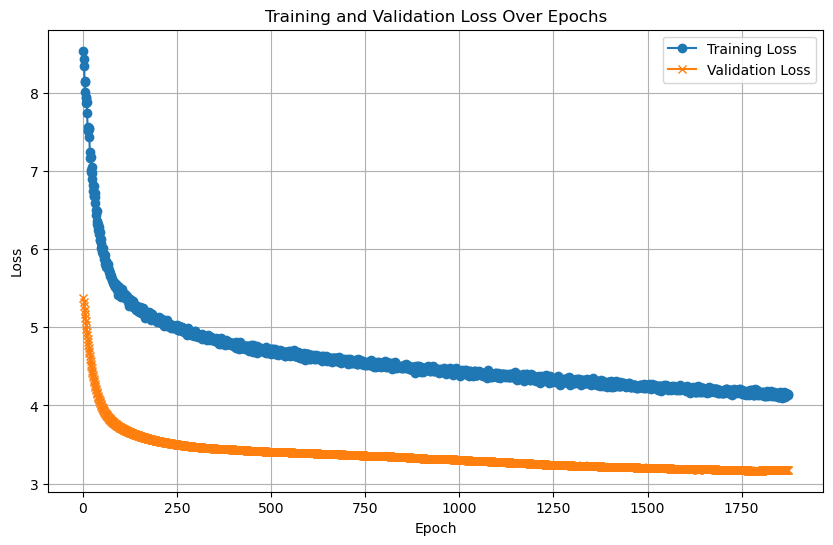

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/39], Loss: 5.3266
Test Batch [20/39], Loss: 5.1787
Test Batch [30/39], Loss: 4.4868

Test Loss: 5.1480


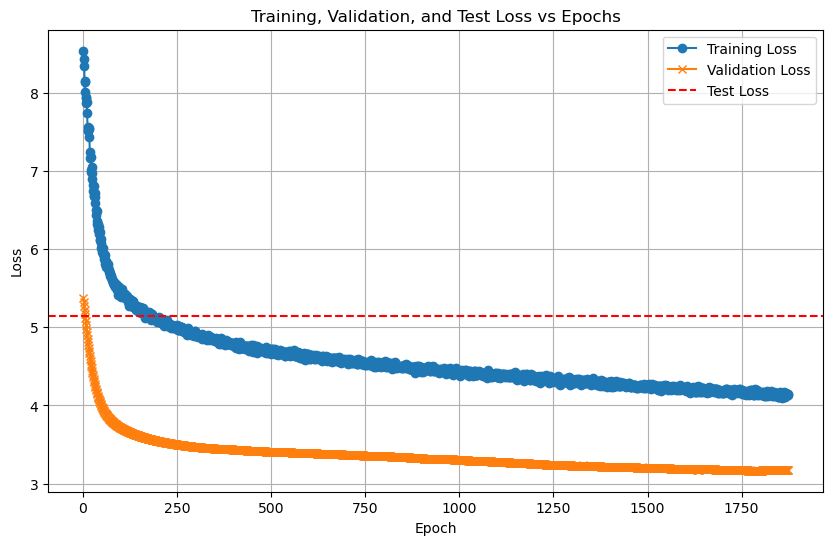

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/39 for test dataset.


  Processed batch 20/39 for test dataset.
  Processed batch 30/39 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 58.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       0.00      0.00      0.00         5
           2       0.25      0.20      0.22         5
           3       0.80      0.80      0.80         5
           4       0.57      0.80      0.67         5
           5       0.00      0.00      0.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.60      0.75         5
           8       0.00      0.00      0.00         0
           9       0.30      0.60      0.40         5
          10       0.75      0.60      0.67         5
          11       0.17      0.20      0.18         5
          12       0.62      1.00      0.77         5
          13       1.0

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklea

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8071  |  Val Loss: 2.7982
Validation loss improved from inf to 2.7982.
[Epoch 2/1000] Train Loss: 2.7858  |  Val Loss: 2.7804
Validation loss improved from 2.7982 to 2.7804.
[Epoch 3/1000] Train Loss: 2.7663  |  Val Loss: 2.7636
Validation loss improved from 2.7804 to 2.7636.
[Epoch 4/1000] Train Loss: 2.7493  |  Val Loss: 2.7481
Validation loss improved from 2.7636 to 2.7481.


[Epoch 5/1000] Train Loss: 2.7318  |  Val Loss: 2.7336
Validation loss improved from 2.7481 to 2.7336.
[Epoch 6/1000] Train Loss: 2.7167  |  Val Loss: 2.7211
Validation loss improved from 2.7336 to 2.7211.
[Epoch 7/1000] Train Loss: 2.7026  |  Val Loss: 2.7083
Validation loss improved from 2.7211 to 2.7083.
[Epoch 8/1000] Train Loss: 2.6884  |  Val Loss: 2.6959
Validation loss improved from 2.7083 to 2.6959.
[Epoch 9/1000] Train Loss: 2.6751  |  Val Loss: 2.6841
Validation loss improved from 2.6959 to 2.6841.
[Epoch 10/1000] Train Loss: 2.6627  |  Val Loss: 2.6727
Validation loss improved from 2.6841 to 2.6727.
[Epoch 11/1000] Train Loss: 2.6508  |  Val Loss: 2.6607
Validation loss improved from 2.6727 to 2.6607.
[Epoch 12/1000] Train Loss: 2.6385  |  Val Loss: 2.6496
Validation loss improved from 2.6607 to 2.6496.
[Epoch 13/1000] Train Loss: 2.6264  |  Val Loss: 2.6386
Validation loss improved from 2.6496 to 2.6386.
[Epoch 14/1000] Train Loss: 2.6147  |  Val Loss: 2.6276
Validation lo

[Epoch 15/1000] Train Loss: 2.6026  |  Val Loss: 2.6169
Validation loss improved from 2.6276 to 2.6169.
[Epoch 16/1000] Train Loss: 2.5912  |  Val Loss: 2.6063
Validation loss improved from 2.6169 to 2.6063.
[Epoch 17/1000] Train Loss: 2.5790  |  Val Loss: 2.5956
Validation loss improved from 2.6063 to 2.5956.
[Epoch 18/1000] Train Loss: 2.5673  |  Val Loss: 2.5845
Validation loss improved from 2.5956 to 2.5845.
[Epoch 19/1000] Train Loss: 2.5552  |  Val Loss: 2.5731
Validation loss improved from 2.5845 to 2.5731.


[Epoch 20/1000] Train Loss: 2.5428  |  Val Loss: 2.5621
Validation loss improved from 2.5731 to 2.5621.
[Epoch 21/1000] Train Loss: 2.5307  |  Val Loss: 2.5512
Validation loss improved from 2.5621 to 2.5512.
[Epoch 22/1000] Train Loss: 2.5183  |  Val Loss: 2.5401
Validation loss improved from 2.5512 to 2.5401.
[Epoch 23/1000] Train Loss: 2.5058  |  Val Loss: 2.5289
Validation loss improved from 2.5401 to 2.5289.
[Epoch 24/1000] Train Loss: 2.4933  |  Val Loss: 2.5179
Validation loss improved from 2.5289 to 2.5179.


[Epoch 25/1000] Train Loss: 2.4799  |  Val Loss: 2.5065
Validation loss improved from 2.5179 to 2.5065.
[Epoch 26/1000] Train Loss: 2.4673  |  Val Loss: 2.4946
Validation loss improved from 2.5065 to 2.4946.
[Epoch 27/1000] Train Loss: 2.4541  |  Val Loss: 2.4829
Validation loss improved from 2.4946 to 2.4829.
[Epoch 28/1000] Train Loss: 2.4406  |  Val Loss: 2.4712
Validation loss improved from 2.4829 to 2.4712.
[Epoch 29/1000] Train Loss: 2.4273  |  Val Loss: 2.4597
Validation loss improved from 2.4712 to 2.4597.
[Epoch 30/1000] Train Loss: 2.4144  |  Val Loss: 2.4475
Validation loss improved from 2.4597 to 2.4475.
[Epoch 31/1000] Train Loss: 2.4005  |  Val Loss: 2.4357
Validation loss improved from 2.4475 to 2.4357.
[Epoch 32/1000] Train Loss: 2.3867  |  Val Loss: 2.4236
Validation loss improved from 2.4357 to 2.4236.
[Epoch 33/1000] Train Loss: 2.3725  |  Val Loss: 2.4117
Validation loss improved from 2.4236 to 2.4117.


[Epoch 34/1000] Train Loss: 2.3589  |  Val Loss: 2.3993
Validation loss improved from 2.4117 to 2.3993.
[Epoch 35/1000] Train Loss: 2.3450  |  Val Loss: 2.3868
Validation loss improved from 2.3993 to 2.3868.
[Epoch 36/1000] Train Loss: 2.3307  |  Val Loss: 2.3742
Validation loss improved from 2.3868 to 2.3742.


[Epoch 37/1000] Train Loss: 2.3165  |  Val Loss: 2.3611
Validation loss improved from 2.3742 to 2.3611.
[Epoch 38/1000] Train Loss: 2.3019  |  Val Loss: 2.3481
Validation loss improved from 2.3611 to 2.3481.
[Epoch 39/1000] Train Loss: 2.2870  |  Val Loss: 2.3354
Validation loss improved from 2.3481 to 2.3354.
[Epoch 40/1000] Train Loss: 2.2719  |  Val Loss: 2.3227
Validation loss improved from 2.3354 to 2.3227.
[Epoch 41/1000] Train Loss: 2.2571  |  Val Loss: 2.3096
Validation loss improved from 2.3227 to 2.3096.


[Epoch 42/1000] Train Loss: 2.2427  |  Val Loss: 2.2962
Validation loss improved from 2.3096 to 2.2962.
[Epoch 43/1000] Train Loss: 2.2278  |  Val Loss: 2.2829
Validation loss improved from 2.2962 to 2.2829.
[Epoch 44/1000] Train Loss: 2.2124  |  Val Loss: 2.2694
Validation loss improved from 2.2829 to 2.2694.
[Epoch 45/1000] Train Loss: 2.1979  |  Val Loss: 2.2554
Validation loss improved from 2.2694 to 2.2554.
[Epoch 46/1000] Train Loss: 2.1832  |  Val Loss: 2.2424
Validation loss improved from 2.2554 to 2.2424.
[Epoch 47/1000] Train Loss: 2.1677  |  Val Loss: 2.2290
Validation loss improved from 2.2424 to 2.2290.
[Epoch 48/1000] Train Loss: 2.1530  |  Val Loss: 2.2162
Validation loss improved from 2.2290 to 2.2162.
[Epoch 49/1000] Train Loss: 2.1379  |  Val Loss: 2.2032
Validation loss improved from 2.2162 to 2.2032.
[Epoch 50/1000] Train Loss: 2.1231  |  Val Loss: 2.1905
Validation loss improved from 2.2032 to 2.1905.
[Epoch 51/1000] Train Loss: 2.1082  |  Val Loss: 2.1772
Validati

[Epoch 53/1000] Train Loss: 2.0781  |  Val Loss: 2.1514
Validation loss improved from 2.1642 to 2.1514.
[Epoch 54/1000] Train Loss: 2.0633  |  Val Loss: 2.1387
Validation loss improved from 2.1514 to 2.1387.
[Epoch 55/1000] Train Loss: 2.0492  |  Val Loss: 2.1262
Validation loss improved from 2.1387 to 2.1262.
[Epoch 56/1000] Train Loss: 2.0342  |  Val Loss: 2.1138
Validation loss improved from 2.1262 to 2.1138.


[Epoch 57/1000] Train Loss: 2.0199  |  Val Loss: 2.1014
Validation loss improved from 2.1138 to 2.1014.
[Epoch 58/1000] Train Loss: 2.0055  |  Val Loss: 2.0889
Validation loss improved from 2.1014 to 2.0889.
[Epoch 59/1000] Train Loss: 1.9914  |  Val Loss: 2.0769
Validation loss improved from 2.0889 to 2.0769.
[Epoch 60/1000] Train Loss: 1.9773  |  Val Loss: 2.0653
Validation loss improved from 2.0769 to 2.0653.
[Epoch 61/1000] Train Loss: 1.9636  |  Val Loss: 2.0536
Validation loss improved from 2.0653 to 2.0536.
[Epoch 62/1000] Train Loss: 1.9497  |  Val Loss: 2.0424
Validation loss improved from 2.0536 to 2.0424.
[Epoch 63/1000] Train Loss: 1.9359  |  Val Loss: 2.0310
Validation loss improved from 2.0424 to 2.0310.


[Epoch 64/1000] Train Loss: 1.9224  |  Val Loss: 2.0194
Validation loss improved from 2.0310 to 2.0194.
[Epoch 65/1000] Train Loss: 1.9086  |  Val Loss: 2.0075
Validation loss improved from 2.0194 to 2.0075.
[Epoch 66/1000] Train Loss: 1.8951  |  Val Loss: 1.9966
Validation loss improved from 2.0075 to 1.9966.
[Epoch 67/1000] Train Loss: 1.8819  |  Val Loss: 1.9853
Validation loss improved from 1.9966 to 1.9853.
[Epoch 68/1000] Train Loss: 1.8688  |  Val Loss: 1.9744
Validation loss improved from 1.9853 to 1.9744.
[Epoch 69/1000] Train Loss: 1.8551  |  Val Loss: 1.9637
Validation loss improved from 1.9744 to 1.9637.
[Epoch 70/1000] Train Loss: 1.8422  |  Val Loss: 1.9530
Validation loss improved from 1.9637 to 1.9530.
[Epoch 71/1000] Train Loss: 1.8293  |  Val Loss: 1.9427
Validation loss improved from 1.9530 to 1.9427.
[Epoch 72/1000] Train Loss: 1.8166  |  Val Loss: 1.9329
Validation loss improved from 1.9427 to 1.9329.


[Epoch 73/1000] Train Loss: 1.8039  |  Val Loss: 1.9225
Validation loss improved from 1.9329 to 1.9225.
[Epoch 74/1000] Train Loss: 1.7912  |  Val Loss: 1.9126
Validation loss improved from 1.9225 to 1.9126.
[Epoch 75/1000] Train Loss: 1.7793  |  Val Loss: 1.9023
Validation loss improved from 1.9126 to 1.9023.
[Epoch 76/1000] Train Loss: 1.7671  |  Val Loss: 1.8927
Validation loss improved from 1.9023 to 1.8927.
[Epoch 77/1000] Train Loss: 1.7546  |  Val Loss: 1.8832
Validation loss improved from 1.8927 to 1.8832.
[Epoch 78/1000] Train Loss: 1.7424  |  Val Loss: 1.8735
Validation loss improved from 1.8832 to 1.8735.
[Epoch 79/1000] Train Loss: 1.7305  |  Val Loss: 1.8645
Validation loss improved from 1.8735 to 1.8645.
[Epoch 80/1000] Train Loss: 1.7189  |  Val Loss: 1.8548
Validation loss improved from 1.8645 to 1.8548.
[Epoch 81/1000] Train Loss: 1.7067  |  Val Loss: 1.8458
Validation loss improved from 1.8548 to 1.8458.
[Epoch 82/1000] Train Loss: 1.6954  |  Val Loss: 1.8361
Validati

[Epoch 83/1000] Train Loss: 1.6837  |  Val Loss: 1.8271
Validation loss improved from 1.8361 to 1.8271.
[Epoch 84/1000] Train Loss: 1.6722  |  Val Loss: 1.8183
Validation loss improved from 1.8271 to 1.8183.
[Epoch 85/1000] Train Loss: 1.6608  |  Val Loss: 1.8099
Validation loss improved from 1.8183 to 1.8099.
[Epoch 86/1000] Train Loss: 1.6492  |  Val Loss: 1.8023
Validation loss improved from 1.8099 to 1.8023.
[Epoch 87/1000] Train Loss: 1.6376  |  Val Loss: 1.7936
Validation loss improved from 1.8023 to 1.7936.
[Epoch 88/1000] Train Loss: 1.6264  |  Val Loss: 1.7851
Validation loss improved from 1.7936 to 1.7851.
[Epoch 89/1000] Train Loss: 1.6142  |  Val Loss: 1.7770
Validation loss improved from 1.7851 to 1.7770.
[Epoch 90/1000] Train Loss: 1.6033  |  Val Loss: 1.7694
Validation loss improved from 1.7770 to 1.7694.
[Epoch 91/1000] Train Loss: 1.5918  |  Val Loss: 1.7620
Validation loss improved from 1.7694 to 1.7620.
[Epoch 92/1000] Train Loss: 1.5805  |  Val Loss: 1.7545
Validati

[Epoch 94/1000] Train Loss: 1.5585  |  Val Loss: 1.7393
Validation loss improved from 1.7468 to 1.7393.
[Epoch 95/1000] Train Loss: 1.5476  |  Val Loss: 1.7314
Validation loss improved from 1.7393 to 1.7314.
[Epoch 96/1000] Train Loss: 1.5360  |  Val Loss: 1.7244
Validation loss improved from 1.7314 to 1.7244.
[Epoch 97/1000] Train Loss: 1.5256  |  Val Loss: 1.7172
Validation loss improved from 1.7244 to 1.7172.
[Epoch 98/1000] Train Loss: 1.5145  |  Val Loss: 1.7104
Validation loss improved from 1.7172 to 1.7104.
[Epoch 99/1000] Train Loss: 1.5039  |  Val Loss: 1.7035
Validation loss improved from 1.7104 to 1.7035.
[Epoch 100/1000] Train Loss: 1.4932  |  Val Loss: 1.6958
Validation loss improved from 1.7035 to 1.6958.
[Epoch 101/1000] Train Loss: 1.4832  |  Val Loss: 1.6880
Validation loss improved from 1.6958 to 1.6880.
[Epoch 102/1000] Train Loss: 1.4723  |  Val Loss: 1.6814
Validation loss improved from 1.6880 to 1.6814.


[Epoch 103/1000] Train Loss: 1.4619  |  Val Loss: 1.6746
Validation loss improved from 1.6814 to 1.6746.
[Epoch 104/1000] Train Loss: 1.4521  |  Val Loss: 1.6680
Validation loss improved from 1.6746 to 1.6680.
[Epoch 105/1000] Train Loss: 1.4423  |  Val Loss: 1.6618
Validation loss improved from 1.6680 to 1.6618.
[Epoch 106/1000] Train Loss: 1.4324  |  Val Loss: 1.6545
Validation loss improved from 1.6618 to 1.6545.
[Epoch 107/1000] Train Loss: 1.4229  |  Val Loss: 1.6478
Validation loss improved from 1.6545 to 1.6478.
[Epoch 108/1000] Train Loss: 1.4135  |  Val Loss: 1.6408
Validation loss improved from 1.6478 to 1.6408.
[Epoch 109/1000] Train Loss: 1.4035  |  Val Loss: 1.6346
Validation loss improved from 1.6408 to 1.6346.
[Epoch 110/1000] Train Loss: 1.3942  |  Val Loss: 1.6290
Validation loss improved from 1.6346 to 1.6290.
[Epoch 111/1000] Train Loss: 1.3851  |  Val Loss: 1.6221
Validation loss improved from 1.6290 to 1.6221.


[Epoch 112/1000] Train Loss: 1.3758  |  Val Loss: 1.6162
Validation loss improved from 1.6221 to 1.6162.
[Epoch 113/1000] Train Loss: 1.3667  |  Val Loss: 1.6096
Validation loss improved from 1.6162 to 1.6096.
[Epoch 114/1000] Train Loss: 1.3584  |  Val Loss: 1.6044
Validation loss improved from 1.6096 to 1.6044.
[Epoch 115/1000] Train Loss: 1.3490  |  Val Loss: 1.5977
Validation loss improved from 1.6044 to 1.5977.
[Epoch 116/1000] Train Loss: 1.3397  |  Val Loss: 1.5917
Validation loss improved from 1.5977 to 1.5917.
[Epoch 117/1000] Train Loss: 1.3308  |  Val Loss: 1.5857
Validation loss improved from 1.5917 to 1.5857.
[Epoch 118/1000] Train Loss: 1.3223  |  Val Loss: 1.5802
Validation loss improved from 1.5857 to 1.5802.
[Epoch 119/1000] Train Loss: 1.3143  |  Val Loss: 1.5749
Validation loss improved from 1.5802 to 1.5749.


[Epoch 120/1000] Train Loss: 1.3059  |  Val Loss: 1.5697
Validation loss improved from 1.5749 to 1.5697.
[Epoch 121/1000] Train Loss: 1.2974  |  Val Loss: 1.5643
Validation loss improved from 1.5697 to 1.5643.
[Epoch 122/1000] Train Loss: 1.2890  |  Val Loss: 1.5589
Validation loss improved from 1.5643 to 1.5589.
[Epoch 123/1000] Train Loss: 1.2811  |  Val Loss: 1.5547
Validation loss improved from 1.5589 to 1.5547.
[Epoch 124/1000] Train Loss: 1.2730  |  Val Loss: 1.5493
Validation loss improved from 1.5547 to 1.5493.
[Epoch 125/1000] Train Loss: 1.2650  |  Val Loss: 1.5440
Validation loss improved from 1.5493 to 1.5440.
[Epoch 126/1000] Train Loss: 1.2573  |  Val Loss: 1.5387
Validation loss improved from 1.5440 to 1.5387.
[Epoch 127/1000] Train Loss: 1.2501  |  Val Loss: 1.5349
Validation loss improved from 1.5387 to 1.5349.
[Epoch 128/1000] Train Loss: 1.2422  |  Val Loss: 1.5307
Validation loss improved from 1.5349 to 1.5307.


[Epoch 129/1000] Train Loss: 1.2344  |  Val Loss: 1.5256
Validation loss improved from 1.5307 to 1.5256.
[Epoch 130/1000] Train Loss: 1.2274  |  Val Loss: 1.5208
Validation loss improved from 1.5256 to 1.5208.
[Epoch 131/1000] Train Loss: 1.2199  |  Val Loss: 1.5173
Validation loss improved from 1.5208 to 1.5173.
[Epoch 132/1000] Train Loss: 1.2120  |  Val Loss: 1.5124
Validation loss improved from 1.5173 to 1.5124.
[Epoch 133/1000] Train Loss: 1.2044  |  Val Loss: 1.5074
Validation loss improved from 1.5124 to 1.5074.
[Epoch 134/1000] Train Loss: 1.1980  |  Val Loss: 1.5039
Validation loss improved from 1.5074 to 1.5039.
[Epoch 135/1000] Train Loss: 1.1899  |  Val Loss: 1.4987
Validation loss improved from 1.5039 to 1.4987.
[Epoch 136/1000] Train Loss: 1.1825  |  Val Loss: 1.4938
Validation loss improved from 1.4987 to 1.4938.
[Epoch 137/1000] Train Loss: 1.1757  |  Val Loss: 1.4888
Validation loss improved from 1.4938 to 1.4888.
[Epoch 138/1000] Train Loss: 1.1684  |  Val Loss: 1.484

[Epoch 141/1000] Train Loss: 1.1470  |  Val Loss: 1.4700
Validation loss improved from 1.4747 to 1.4700.
[Epoch 142/1000] Train Loss: 1.1406  |  Val Loss: 1.4667
Validation loss improved from 1.4700 to 1.4667.
[Epoch 143/1000] Train Loss: 1.1341  |  Val Loss: 1.4632
Validation loss improved from 1.4667 to 1.4632.
[Epoch 144/1000] Train Loss: 1.1282  |  Val Loss: 1.4605
Validation loss improved from 1.4632 to 1.4605.
[Epoch 145/1000] Train Loss: 1.1219  |  Val Loss: 1.4567
Validation loss improved from 1.4605 to 1.4567.
[Epoch 146/1000] Train Loss: 1.1159  |  Val Loss: 1.4532
Validation loss improved from 1.4567 to 1.4532.
[Epoch 147/1000] Train Loss: 1.1098  |  Val Loss: 1.4502
Validation loss improved from 1.4532 to 1.4502.
[Epoch 148/1000] Train Loss: 1.1047  |  Val Loss: 1.4456
Validation loss improved from 1.4502 to 1.4456.
[Epoch 149/1000] Train Loss: 1.0985  |  Val Loss: 1.4440
Validation loss improved from 1.4456 to 1.4440.
[Epoch 150/1000] Train Loss: 1.0920  |  Val Loss: 1.440

[Epoch 151/1000] Train Loss: 1.0863  |  Val Loss: 1.4383
Validation loss improved from 1.4407 to 1.4383.
[Epoch 152/1000] Train Loss: 1.0811  |  Val Loss: 1.4352
Validation loss improved from 1.4383 to 1.4352.
[Epoch 153/1000] Train Loss: 1.0757  |  Val Loss: 1.4330
Validation loss improved from 1.4352 to 1.4330.
[Epoch 154/1000] Train Loss: 1.0705  |  Val Loss: 1.4309
Validation loss improved from 1.4330 to 1.4309.
[Epoch 155/1000] Train Loss: 1.0647  |  Val Loss: 1.4264
Validation loss improved from 1.4309 to 1.4264.
[Epoch 156/1000] Train Loss: 1.0593  |  Val Loss: 1.4241
Validation loss improved from 1.4264 to 1.4241.
[Epoch 157/1000] Train Loss: 1.0538  |  Val Loss: 1.4209
Validation loss improved from 1.4241 to 1.4209.
[Epoch 158/1000] Train Loss: 1.0488  |  Val Loss: 1.4184
Validation loss improved from 1.4209 to 1.4184.
[Epoch 159/1000] Train Loss: 1.0439  |  Val Loss: 1.4165
Validation loss improved from 1.4184 to 1.4165.


[Epoch 160/1000] Train Loss: 1.0384  |  Val Loss: 1.4140
Validation loss improved from 1.4165 to 1.4140.
[Epoch 161/1000] Train Loss: 1.0335  |  Val Loss: 1.4113
Validation loss improved from 1.4140 to 1.4113.
[Epoch 162/1000] Train Loss: 1.0285  |  Val Loss: 1.4089
Validation loss improved from 1.4113 to 1.4089.
[Epoch 163/1000] Train Loss: 1.0236  |  Val Loss: 1.4066
Validation loss improved from 1.4089 to 1.4066.
[Epoch 164/1000] Train Loss: 1.0192  |  Val Loss: 1.4044
Validation loss improved from 1.4066 to 1.4044.
[Epoch 165/1000] Train Loss: 1.0148  |  Val Loss: 1.4030
Validation loss improved from 1.4044 to 1.4030.
[Epoch 166/1000] Train Loss: 1.0095  |  Val Loss: 1.4007
Validation loss improved from 1.4030 to 1.4007.
[Epoch 167/1000] Train Loss: 1.0059  |  Val Loss: 1.3986
Validation loss improved from 1.4007 to 1.3986.
[Epoch 168/1000] Train Loss: 1.0000  |  Val Loss: 1.3972
Validation loss improved from 1.3986 to 1.3972.
[Epoch 169/1000] Train Loss: 0.9952  |  Val Loss: 1.394

[Epoch 171/1000] Train Loss: 0.9863  |  Val Loss: 1.3901
Validation loss improved from 1.3931 to 1.3901.
[Epoch 172/1000] Train Loss: 0.9819  |  Val Loss: 1.3878
Validation loss improved from 1.3901 to 1.3878.
[Epoch 173/1000] Train Loss: 0.9773  |  Val Loss: 1.3853
Validation loss improved from 1.3878 to 1.3853.
[Epoch 174/1000] Train Loss: 0.9729  |  Val Loss: 1.3849
Validation loss improved from 1.3853 to 1.3849.
[Epoch 175/1000] Train Loss: 0.9682  |  Val Loss: 1.3828
Validation loss improved from 1.3849 to 1.3828.
[Epoch 176/1000] Train Loss: 0.9641  |  Val Loss: 1.3807
Validation loss improved from 1.3828 to 1.3807.
[Epoch 177/1000] Train Loss: 0.9594  |  Val Loss: 1.3776
Validation loss improved from 1.3807 to 1.3776.
[Epoch 178/1000] Train Loss: 0.9546  |  Val Loss: 1.3766
Validation loss improved from 1.3776 to 1.3766.


[Epoch 179/1000] Train Loss: 0.9509  |  Val Loss: 1.3754
Validation loss improved from 1.3766 to 1.3754.
[Epoch 180/1000] Train Loss: 0.9465  |  Val Loss: 1.3732
Validation loss improved from 1.3754 to 1.3732.
[Epoch 181/1000] Train Loss: 0.9423  |  Val Loss: 1.3720
Validation loss improved from 1.3732 to 1.3720.
[Epoch 182/1000] Train Loss: 0.9385  |  Val Loss: 1.3709
Validation loss improved from 1.3720 to 1.3709.
[Epoch 183/1000] Train Loss: 0.9339  |  Val Loss: 1.3677
Validation loss improved from 1.3709 to 1.3677.
[Epoch 184/1000] Train Loss: 0.9310  |  Val Loss: 1.3638
Validation loss improved from 1.3677 to 1.3638.
[Epoch 185/1000] Train Loss: 0.9266  |  Val Loss: 1.3642
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 186/1000] Train Loss: 0.9229  |  Val Loss: 1.3634
Validation loss improved from 1.3638 to 1.3634.
[Epoch 187/1000] Train Loss: 0.9183  |  Val Loss: 1.3625
Validation loss improved from 1.3634 to 1.3625.
[Epoch 188/1000] Train Loss: 0.9145  |  Val Loss:

[Epoch 190/1000] Train Loss: 0.9071  |  Val Loss: 1.3589
Validation loss improved from 1.3617 to 1.3589.
[Epoch 191/1000] Train Loss: 0.9034  |  Val Loss: 1.3562
Validation loss improved from 1.3589 to 1.3562.
[Epoch 192/1000] Train Loss: 0.8996  |  Val Loss: 1.3553
Validation loss improved from 1.3562 to 1.3553.
[Epoch 193/1000] Train Loss: 0.8962  |  Val Loss: 1.3544
Validation loss improved from 1.3553 to 1.3544.
[Epoch 194/1000] Train Loss: 0.8922  |  Val Loss: 1.3539
Validation loss improved from 1.3544 to 1.3539.
[Epoch 195/1000] Train Loss: 0.8895  |  Val Loss: 1.3525
Validation loss improved from 1.3539 to 1.3525.
[Epoch 196/1000] Train Loss: 0.8852  |  Val Loss: 1.3517
Validation loss improved from 1.3525 to 1.3517.
[Epoch 197/1000] Train Loss: 0.8828  |  Val Loss: 1.3505
Validation loss improved from 1.3517 to 1.3505.


[Epoch 198/1000] Train Loss: 0.8784  |  Val Loss: 1.3503
Validation loss improved from 1.3505 to 1.3503.
[Epoch 199/1000] Train Loss: 0.8754  |  Val Loss: 1.3519
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 200/1000] Train Loss: 0.8720  |  Val Loss: 1.3517
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 201/1000] Train Loss: 0.8682  |  Val Loss: 1.3507
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 202/1000] Train Loss: 0.8650  |  Val Loss: 1.3478
Validation loss improved from 1.3503 to 1.3478.
[Epoch 203/1000] Train Loss: 0.8621  |  Val Loss: 1.3472
Validation loss improved from 1.3478 to 1.3472.
[Epoch 204/1000] Train Loss: 0.8586  |  Val Loss: 1.3472
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 205/1000] Train Loss: 0.8552  |  Val Loss: 1.3458
Validation loss improved from 1.3472 to 1.3458.
[Epoch 206/1000] Train Loss: 0.8522  |  Val Loss: 1.3470
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 207/1000] Train Lo

[Epoch 208/1000] Train Loss: 0.8469  |  Val Loss: 1.3465
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 209/1000] Train Loss: 0.8436  |  Val Loss: 1.3431
Validation loss improved from 1.3458 to 1.3431.
[Epoch 210/1000] Train Loss: 0.8394  |  Val Loss: 1.3429
Validation loss improved from 1.3431 to 1.3429.
[Epoch 211/1000] Train Loss: 0.8372  |  Val Loss: 1.3427
Validation loss improved from 1.3429 to 1.3427.
[Epoch 212/1000] Train Loss: 0.8338  |  Val Loss: 1.3429
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 213/1000] Train Loss: 0.8311  |  Val Loss: 1.3430
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 214/1000] Train Loss: 0.8287  |  Val Loss: 1.3413
Validation loss improved from 1.3427 to 1.3413.
[Epoch 215/1000] Train Loss: 0.8252  |  Val Loss: 1.3411
Validation loss improved from 1.3413 to 1.3411.
[Epoch 216/1000] Train Loss: 0.8227  |  Val Loss: 1.3394
Validation loss improved from 1.3411 to 1.3394.
[Epoch 217/1000] Train Loss: 0.8205  

[Epoch 218/1000] Train Loss: 0.8173  |  Val Loss: 1.3397
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 219/1000] Train Loss: 0.8148  |  Val Loss: 1.3372
Validation loss improved from 1.3394 to 1.3372.
[Epoch 220/1000] Train Loss: 0.8122  |  Val Loss: 1.3370
Validation loss improved from 1.3372 to 1.3370.
[Epoch 221/1000] Train Loss: 0.8090  |  Val Loss: 1.3364
Validation loss improved from 1.3370 to 1.3364.
[Epoch 222/1000] Train Loss: 0.8071  |  Val Loss: 1.3385
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 223/1000] Train Loss: 0.8038  |  Val Loss: 1.3376
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 224/1000] Train Loss: 0.8012  |  Val Loss: 1.3354
Validation loss improved from 1.3364 to 1.3354.
[Epoch 225/1000] Train Loss: 0.7994  |  Val Loss: 1.3355
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 226/1000] Train Loss: 0.7957  |  Val Loss: 1.3347
Validation loss improved from 1.3354 to 1.3347.
[Epoch 227/1000] Train Loss: 0.7938  |  Val Loss: 1.3329
Validation loss improved from 1.3347 to 1.3329.
[Epoch 228/1000] Train Loss: 0.7920  |  Val Loss: 1.3334
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 229/1000] Train Loss: 0.7885  |  Val Loss: 1.3327
Validation loss improved from 1.3329 to 1.3327.
[Epoch 230/1000] Train Loss: 0.7862  |  Val Loss: 1.3318
Validation loss improved from 1.3327 to 1.3318.
[Epoch 231/1000] Train Loss: 0.7844  |  Val Loss: 1.3322
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 232/1000] Train Loss: 0.7817  |  Val Loss: 1.3304
Validation loss improved from 1.3318 to 1.3304.
[Epoch 233/1000] Train Loss: 0.7796  |  Val Loss: 1.3300
Validation loss improved from 1.3304 to 1.3300.
[Epoch 234/1000] Train Loss: 0.7767  |  Val Loss: 1.3307
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 235/1000] Train Loss: 0.7747  

[Epoch 237/1000] Train Loss: 0.7707  |  Val Loss: 1.3300
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 238/1000] Train Loss: 0.7681  |  Val Loss: 1.3292
Validation loss improved from 1.3297 to 1.3292.
[Epoch 239/1000] Train Loss: 0.7657  |  Val Loss: 1.3279
Validation loss improved from 1.3292 to 1.3279.
[Epoch 240/1000] Train Loss: 0.7645  |  Val Loss: 1.3279
Validation loss improved from 1.3279 to 1.3279.
[Epoch 241/1000] Train Loss: 0.7615  |  Val Loss: 1.3260
Validation loss improved from 1.3279 to 1.3260.
[Epoch 242/1000] Train Loss: 0.7612  |  Val Loss: 1.3272
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 243/1000] Train Loss: 0.7571  |  Val Loss: 1.3261
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 244/1000] Train Loss: 0.7562  |  Val Loss: 1.3279
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 245/1000] Train Loss: 0.7525  |  Val Loss: 1.3263
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 246/1000] Train Lo

[Epoch 247/1000] Train Loss: 0.7489  |  Val Loss: 1.3241
Validation loss improved from 1.3243 to 1.3241.
[Epoch 248/1000] Train Loss: 0.7466  |  Val Loss: 1.3252
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 249/1000] Train Loss: 0.7448  |  Val Loss: 1.3253
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 250/1000] Train Loss: 0.7434  |  Val Loss: 1.3231
Validation loss improved from 1.3241 to 1.3231.
[Epoch 251/1000] Train Loss: 0.7412  |  Val Loss: 1.3238
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 252/1000] Train Loss: 0.7388  |  Val Loss: 1.3233
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 253/1000] Train Loss: 0.7372  |  Val Loss: 1.3231
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 254/1000] Train Loss: 0.7354  |  Val Loss: 1.3230
Validation loss improved from 1.3231 to 1.3230.
[Epoch 255/1000] Train Loss: 0.7335  |  Val Loss: 1.3224
Validation loss improved from 1.3230 to 1.3224.
[Epoch 256/1000] Train Lo

[Epoch 257/1000] Train Loss: 0.7297  |  Val Loss: 1.3203
Validation loss improved from 1.3207 to 1.3203.
[Epoch 258/1000] Train Loss: 0.7284  |  Val Loss: 1.3204
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 259/1000] Train Loss: 0.7267  |  Val Loss: 1.3211
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 260/1000] Train Loss: 0.7253  |  Val Loss: 1.3231
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 261/1000] Train Loss: 0.7227  |  Val Loss: 1.3193
Validation loss improved from 1.3203 to 1.3193.
[Epoch 262/1000] Train Loss: 0.7205  |  Val Loss: 1.3206
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 263/1000] Train Loss: 0.7187  |  Val Loss: 1.3203
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 264/1000] Train Loss: 0.7173  |  Val Loss: 1.3181
Validation loss improved from 1.3193 to 1.3181.
[Epoch 265/1000] Train Loss: 0.7163  |  Val Loss: 1.3181
Validation loss improved from 1.3181 to 1.3181.
[Epoch 266/1000] Train Lo

[Epoch 267/1000] Train Loss: 0.7117  |  Val Loss: 1.3203
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 268/1000] Train Loss: 0.7111  |  Val Loss: 1.3212
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 269/1000] Train Loss: 0.7095  |  Val Loss: 1.3188
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 270/1000] Train Loss: 0.7083  |  Val Loss: 1.3187
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 271/1000] Train Loss: 0.7056  |  Val Loss: 1.3176
Validation loss improved from 1.3180 to 1.3176.
[Epoch 272/1000] Train Loss: 0.7045  |  Val Loss: 1.3162
Validation loss improved from 1.3176 to 1.3162.
[Epoch 273/1000] Train Loss: 0.7025  |  Val Loss: 1.3154
Validation loss improved from 1.3162 to 1.3154.
[Epoch 274/1000] Train Loss: 0.7022  |  Val Loss: 1.3158
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 275/1000] Train Loss: 0.6998  |  Val Loss: 1.3162
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 276/1000] Train Loss: 0.6981  |  Val Loss: 1.3163
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 277/1000] Train Loss: 0.6966  |  Val Loss: 1.3184
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 278/1000] Train Loss: 0.6951  |  Val Loss: 1.3170
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 279/1000] Train Loss: 0.6937  |  Val Loss: 1.3134
Validation loss improved from 1.3154 to 1.3134.
[Epoch 280/1000] Train Loss: 0.6921  |  Val Loss: 1.3138
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 281/1000] Train Loss: 0.6905  |  Val Loss: 1.3150
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 282/1000] Train Loss: 0.6888  |  Val Loss: 1.3139
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 283/1000] Train Loss: 0.6874  |  Val Loss: 1.3134
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 284/1000] Train Loss: 0.6867  |  Val Loss: 1.3135
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 288/1000] Train Loss: 0.6803  |  Val Loss: 1.3139
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 289/1000] Train Loss: 0.6795  |  Val Loss: 1.3137
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 290/1000] Train Loss: 0.6793  |  Val Loss: 1.3113
Validation loss improved from 1.3134 to 1.3113.
[Epoch 291/1000] Train Loss: 0.6764  |  Val Loss: 1.3137
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 292/1000] Train Loss: 0.6753  |  Val Loss: 1.3138
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 293/1000] Train Loss: 0.6743  |  Val Loss: 1.3143
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 294/1000] Train Loss: 0.6724  |  Val Loss: 1.3123
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 295/1000] Train Loss: 0.6713  |  Val Loss: 1.3120
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 296/1000] Train Loss: 0.6700  |  Val Loss: 1.3112
Validation loss improved from 1.3113 to 1.3112.
[Epoch 297/1000] Train Loss: 0.6689  |  Val Loss: 1.3105
Validation loss improved from 1.3112 to 1.3105.
[Epoch 298/1000] Train Loss: 0.6677  |  Val Loss: 1.3121
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 299/1000] Train Loss: 0.6668  |  Val Loss: 1.3124
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 300/1000] Train Loss: 0.6646  |  Val Loss: 1.3138
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 301/1000] Train Loss: 0.6637  |  Val Loss: 1.3129
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 302/1000] Train Loss: 0.6632  |  Val Loss: 1.3114
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 303/1000] Train Loss: 0.6617  |  Val Loss: 1.3105
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 304/1000] Train Loss: 0.6597  |  Val Loss: 1.3102
Validation loss improved from 1.3105 to 1.3102.
[Epoch 305/1000] Train Loss: 0.6589  |  Val Loss: 1.3116
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 306/1000] Train Loss: 0.6575  |  Val Loss: 1.3126
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 307/1000] Train Loss: 0.6562  |  Val Loss: 1.3133
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 308/1000] Train Loss: 0.6548  |  Val Loss: 1.3132
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 309/1000] Train Loss: 0.6536  |  Val Loss: 1.3127
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 310/1000] Train Loss: 0.6531  |  Val Loss: 1.3123
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 311/1000] Train Loss: 0.6517  |  Val Loss: 1.3121
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 312/1000] Train Loss: 0.6512  |  Val Loss: 1.3148
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 313/1000] Train Loss: 0.6487  |  Val Loss: 1.3147
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 314/1000] Train Loss: 0.6478  |  Val Loss: 1.3141
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 315/1000] Train Loss: 0.6462  |  Val Loss: 1.3126
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 316/1000] Train Loss: 0.6460  |  Val Loss: 1.3132
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 317/1000] Train Loss: 0.6453  |  Val Loss: 1.3115
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 318/1000] Train Loss: 0.6444  |  Val Loss: 1.3127
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 319/1000] Train Loss: 0.6423  |  Val Loss: 1.3166
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 320/1000] Train Loss: 0.6413  |  Val Loss: 1.3188
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 321/1000] Train Loss: 0.6405  |  Val Loss: 1.3167
!! Validation loss did NOT improve !! Patience: 

[Epoch 324/1000] Train Loss: 0.6374  |  Val Loss: 1.3136
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 325/1000] Train Loss: 0.6358  |  Val Loss: 1.3169
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 326/1000] Train Loss: 0.6349  |  Val Loss: 1.3172
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 327/1000] Train Loss: 0.6343  |  Val Loss: 1.3148
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 328/1000] Train Loss: 0.6328  |  Val Loss: 1.3157
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 329/1000] Train Loss: 0.6319  |  Val Loss: 1.3171
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 330/1000] Train Loss: 0.6317  |  Val Loss: 1.3183
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 331/1000] Train Loss: 0.6292  |  Val Loss: 1.3165
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 332/1000] Train Loss: 0.6306  |  Val Loss: 1.3128
!! Validation loss did NOT improve !! Patience:

[Epoch 334/1000] Train Loss: 0.6263  |  Val Loss: 1.3157
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 335/1000] Train Loss: 0.6260  |  Val Loss: 1.3185
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 336/1000] Train Loss: 0.6250  |  Val Loss: 1.3188
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 337/1000] Train Loss: 0.6236  |  Val Loss: 1.3176
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 338/1000] Train Loss: 0.6232  |  Val Loss: 1.3180
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 339/1000] Train Loss: 0.6225  |  Val Loss: 1.3170
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 340/1000] Train Loss: 0.6209  |  Val Loss: 1.3176
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 341/1000] Train Loss: 0.6197  |  Val Loss: 1.3184
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 342/1000] Train Loss: 0.6196  |  Val Loss: 1.3150
!! Validation loss did NOT improve !! Patience:

[Epoch 343/1000] Train Loss: 0.6193  |  Val Loss: 1.3165
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 344/1000] Train Loss: 0.6179  |  Val Loss: 1.3177
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 345/1000] Train Loss: 0.6163  |  Val Loss: 1.3179
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 346/1000] Train Loss: 0.6154  |  Val Loss: 1.3204
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 347/1000] Train Loss: 0.6145  |  Val Loss: 1.3216
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 348/1000] Train Loss: 0.6137  |  Val Loss: 1.3188
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 349/1000] Train Loss: 0.6129  |  Val Loss: 1.3176
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 350/1000] Train Loss: 0.6116  |  Val Loss: 1.3193
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 351/1000] Train Loss: 0.6113  |  Val Loss: 1.3199
!! Validation loss did NOT improve !! Patience:

[Epoch 354/1000] Train Loss: 0.6086  |  Val Loss: 1.3215
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 355/1000] Train Loss: 0.6079  |  Val Loss: 1.3191
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 356/1000] Train Loss: 0.6068  |  Val Loss: 1.3186
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 357/1000] Train Loss: 0.6058  |  Val Loss: 1.3204
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 358/1000] Train Loss: 0.6047  |  Val Loss: 1.3209
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 359/1000] Train Loss: 0.6050  |  Val Loss: 1.3236
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 360/1000] Train Loss: 0.6038  |  Val Loss: 1.3209
!! Validation loss did NOT improve !! Patience: 56/100


[Epoch 361/1000] Train Loss: 0.6034  |  Val Loss: 1.3215
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 362/1000] Train Loss: 0.6024  |  Val Loss: 1.3198
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 363/1000] Train Loss: 0.6018  |  Val Loss: 1.3230
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 364/1000] Train Loss: 0.6007  |  Val Loss: 1.3238
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 365/1000] Train Loss: 0.5991  |  Val Loss: 1.3218
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 366/1000] Train Loss: 0.5986  |  Val Loss: 1.3211
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 367/1000] Train Loss: 0.5974  |  Val Loss: 1.3217
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 368/1000] Train Loss: 0.5973  |  Val Loss: 1.3231
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 369/1000] Train Loss: 0.5970  |  Val Loss: 1.3211
!! Validation loss did NOT improve !! Patience:

[Epoch 373/1000] Train Loss: 0.5927  |  Val Loss: 1.3250
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 374/1000] Train Loss: 0.5923  |  Val Loss: 1.3272
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 375/1000] Train Loss: 0.5921  |  Val Loss: 1.3280
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 376/1000] Train Loss: 0.5911  |  Val Loss: 1.3265
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 377/1000] Train Loss: 0.5908  |  Val Loss: 1.3244
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 378/1000] Train Loss: 0.5901  |  Val Loss: 1.3254
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 379/1000] Train Loss: 0.5889  |  Val Loss: 1.3248
!! Validation loss did NOT improve !! Patience: 75/100


[Epoch 380/1000] Train Loss: 0.5884  |  Val Loss: 1.3274
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 381/1000] Train Loss: 0.5872  |  Val Loss: 1.3262
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 382/1000] Train Loss: 0.5872  |  Val Loss: 1.3286
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 383/1000] Train Loss: 0.5862  |  Val Loss: 1.3285
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 384/1000] Train Loss: 0.5863  |  Val Loss: 1.3264
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 385/1000] Train Loss: 0.5846  |  Val Loss: 1.3258
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 386/1000] Train Loss: 0.5836  |  Val Loss: 1.3264
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 387/1000] Train Loss: 0.5833  |  Val Loss: 1.3288
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 388/1000] Train Loss: 0.5821  |  Val Loss: 1.3294
!! Validation loss did NOT improve !! Patience:

[Epoch 391/1000] Train Loss: 0.5803  |  Val Loss: 1.3283
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 392/1000] Train Loss: 0.5795  |  Val Loss: 1.3294
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 393/1000] Train Loss: 0.5802  |  Val Loss: 1.3287
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 394/1000] Train Loss: 0.5784  |  Val Loss: 1.3318
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 395/1000] Train Loss: 0.5779  |  Val Loss: 1.3321
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 396/1000] Train Loss: 0.5777  |  Val Loss: 1.3354
!! Validation loss did NOT improve !! Patience: 92/100


[Epoch 397/1000] Train Loss: 0.5773  |  Val Loss: 1.3315
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 398/1000] Train Loss: 0.5762  |  Val Loss: 1.3324
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 399/1000] Train Loss: 0.5753  |  Val Loss: 1.3317
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 400/1000] Train Loss: 0.5739  |  Val Loss: 1.3319
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 401/1000] Train Loss: 0.5740  |  Val Loss: 1.3317
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 402/1000] Train Loss: 0.5731  |  Val Loss: 1.3343
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 403/1000] Train Loss: 0.5721  |  Val Loss: 1.3351
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 404/1000] Train Loss: 0.5720  |  Val Loss: 1.3342
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 404 !!
No improvement for 100 epochs.


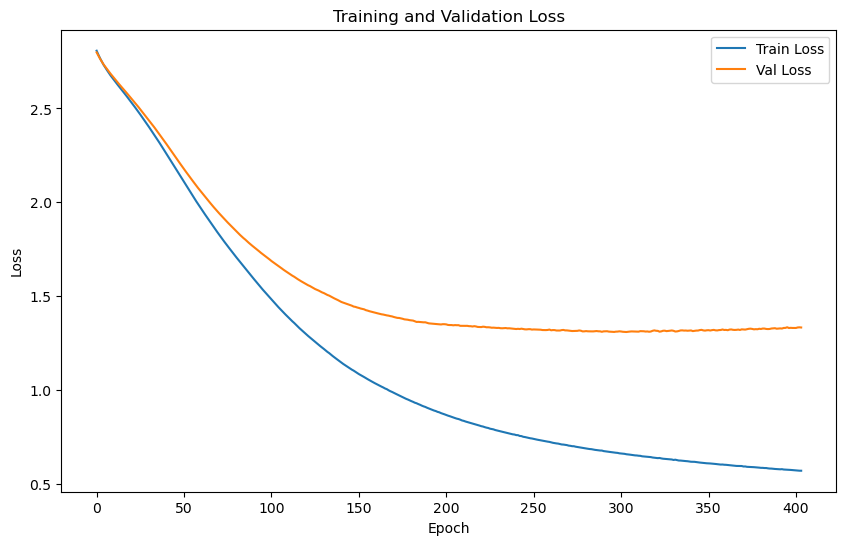

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.5011 | Test Accuracy: 48.90%


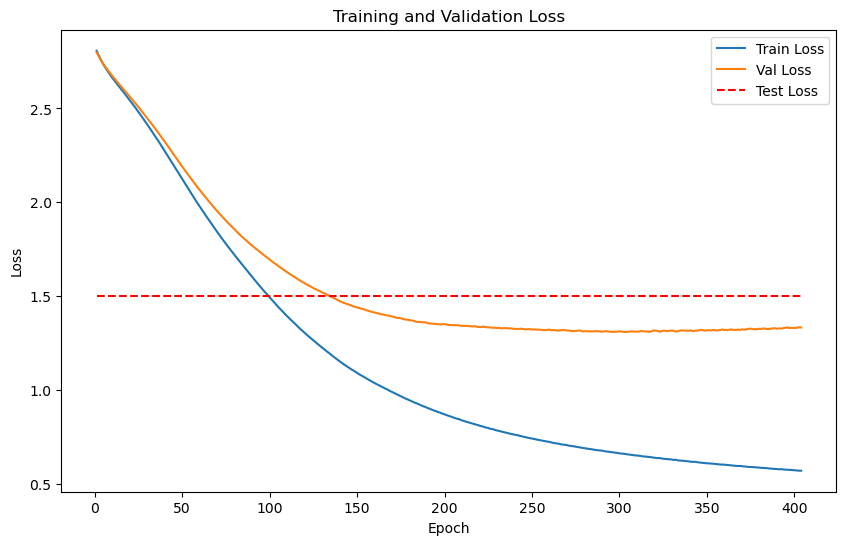

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (75, 64), 
Val labels shape: (75,)


Test embeddings shape: (9854, 64), 
Test labels shape: (9854,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4992
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5483
    Batch [2/2], Val Loss: 0.3277
Epoch [1/2000], Avg Train Loss: 0.4992, Avg Val Loss: 0.4380

Validation loss improved from inf to 0.4380. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4993
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5470
    Batch [2/2], Val Loss: 0.3275
Epoch [2/2000], Avg Train Loss: 0.4993, Avg Val Loss: 0.4373

Validation loss improved from 0.4380 to 0.4373. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4987
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5455
    Batch [2/2], Val Loss: 0.3275
Epoch [3/2000], Avg Train Loss: 0.4987, Avg Val Loss: 0.4365

Validation loss improved from 0.4373 to 0.4365. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4971
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5439
    Batch [2/2], Val Loss: 0.3283
Epoch [4/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.4361

Validation loss improved from 0.4365 to 0.4361. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5424
    Batch [2/2], Val Loss: 0.3289
Epoch [5/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.4357

Validation loss improved from 0.4361 to 0.4357. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4969
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5412
    Batch [2/2], Val Loss: 0.3298
Epoch [6/2000], Avg Train Loss: 0.4969, Avg Val Loss: 0.4355

Validation loss improved from 0.4357 to 0.4355. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5400
    Batch [2/2], Val Loss: 0.3311
Epoch [7/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.4355

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5389
    Batch [2/2], Val Loss: 0.3324
Epoch [8/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.4356

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5377
    Batch [2/2], Val Loss: 0.3332
Epoch [9/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.4355

Validation loss improved from 0.4355 to 0.4355. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5365
    Batch [2/2], Val Loss: 0.3343
Epoch [10/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.4354

Validation loss improved from 0.4355 to 0.4354. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5352
    Batch [2/2], Val Loss: 0.3352
Epoch [11/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.4352

Validation loss improved from 0.4354 to 0.4352. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5340
    Batch [2/2], Val Loss: 0.3360
Epoch [12/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.4350

Validation loss improved from 0.4352 to 0.4350. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5328
    Batch [2/2], Val Loss: 0.3368
Epoch [13/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.4348

Validation loss improved from 0.4350 to 0.4348. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5318
    Batch [2/2], Val Loss: 0.3377
Epoch [14/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.4347

Validation loss improved from 0.4348 to 0.4347. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5308
    Batch [2/2], Val Loss: 0.3383
Epoch [15/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4346

Validation loss improved from 0.4347 to 0.4346. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5296
    Batch [2/2], Val Loss: 0.3389
Epoch [16/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4342

Validation loss improved from 0.4346 to 0.4342. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5284
    Batch [2/2], Val Loss: 0.3395
Epoch [17/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4339

Validation loss improved from 0.4342 to 0.4339. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5274
    Batch [2/2], Val Loss: 0.3399
Epoch [18/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.4337

Validation loss improved from 0.4339 to 0.4337. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5266
    Batch [2/2], Val Loss: 0.3402
Epoch [19/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4334

Validation loss improved from 0.4337 to 0.4334. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5258
    Batch [2/2], Val Loss: 0.3402
Epoch [20/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4330

Validation loss improved from 0.4334 to 0.4330. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5253
    Batch [2/2], Val Loss: 0.3402
Epoch [21/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4327

Validation loss improved from 0.4330 to 0.4327. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5246
    Batch [2/2], Val Loss: 0.3404
Epoch [22/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4325

Validation loss improved from 0.4327 to 0.4325. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5240
    Batch [2/2], Val Loss: 0.3405
Epoch [23/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4323

Validation loss improved from 0.4325 to 0.4323. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5234
    Batch [2/2], Val Loss: 0.3405
Epoch [24/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4319

Validation loss improved from 0.4323 to 0.4319. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5228
    Batch [2/2], Val Loss: 0.3404
Epoch [25/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4316

Validation loss improved from 0.4319 to 0.4316. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5222
    Batch [2/2], Val Loss: 0.3404
Epoch [26/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4313

Validation loss improved from 0.4316 to 0.4313. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5216
    Batch [2/2], Val Loss: 0.3402
Epoch [27/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4309

Validation loss improved from 0.4313 to 0.4309. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5210
    Batch [2/2], Val Loss: 0.3399
Epoch [28/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4305

Validation loss improved from 0.4309 to 0.4305. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5205
    Batch [2/2], Val Loss: 0.3396
Epoch [29/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4300

Validation loss improved from 0.4305 to 0.4300. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5200
    Batch [2/2], Val Loss: 0.3392
Epoch [30/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4296

Validation loss improved from 0.4300 to 0.4296. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.3387
Epoch [31/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.4291

Validation loss improved from 0.4296 to 0.4291. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.3383
Epoch [32/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4287

Validation loss improved from 0.4291 to 0.4287. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5186
    Batch [2/2], Val Loss: 0.3379
Epoch [33/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4282

Validation loss improved from 0.4287 to 0.4282. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5182
    Batch [2/2], Val Loss: 0.3374
Epoch [34/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4278

Validation loss improved from 0.4282 to 0.4278. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5178
    Batch [2/2], Val Loss: 0.3370
Epoch [35/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4274

Validation loss improved from 0.4278 to 0.4274. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5174
    Batch [2/2], Val Loss: 0.3365
Epoch [36/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4269

Validation loss improved from 0.4274 to 0.4269. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.3359
Epoch [37/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4265

Validation loss improved from 0.4269 to 0.4265. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5167
    Batch [2/2], Val Loss: 0.3353
Epoch [38/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4260

Validation loss improved from 0.4265 to 0.4260. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.3347
Epoch [39/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4256

Validation loss improved from 0.4260 to 0.4256. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.3341
Epoch [40/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4251

Validation loss improved from 0.4256 to 0.4251. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.3335
Epoch [41/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.4247

Validation loss improved from 0.4251 to 0.4247. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.3329
Epoch [42/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4243

Validation loss improved from 0.4247 to 0.4243. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5154
    Batch [2/2], Val Loss: 0.3324
Epoch [43/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4239

Validation loss improved from 0.4243 to 0.4239. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5152
    Batch [2/2], Val Loss: 0.3319
Epoch [44/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4235

Validation loss improved from 0.4239 to 0.4235. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.3315
Epoch [45/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.4232

Validation loss improved from 0.4235 to 0.4232. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.3310
Epoch [46/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.4229

Validation loss improved from 0.4232 to 0.4229. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5145
    Batch [2/2], Val Loss: 0.3306
Epoch [47/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4226

Validation loss improved from 0.4229 to 0.4226. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5143
    Batch [2/2], Val Loss: 0.3302
Epoch [48/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4223

Validation loss improved from 0.4226 to 0.4223. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5141
    Batch [2/2], Val Loss: 0.3298
Epoch [49/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4220

Validation loss improved from 0.4223 to 0.4220. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4780
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5140
    Batch [2/2], Val Loss: 0.3295
Epoch [50/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.4217

Validation loss improved from 0.4220 to 0.4217. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5138
    Batch [2/2], Val Loss: 0.3291
Epoch [51/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.4214

Validation loss improved from 0.4217 to 0.4214. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4772
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.3286
Epoch [52/2000], Avg Train Loss: 0.4772, Avg Val Loss: 0.4211

Validation loss improved from 0.4214 to 0.4211. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.3283
Epoch [53/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4209

Validation loss improved from 0.4211 to 0.4209. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.3279
Epoch [54/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.4206

Validation loss improved from 0.4209 to 0.4206. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.3275
Epoch [55/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.4203

Validation loss improved from 0.4206 to 0.4203. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.3271
Epoch [56/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.4201

Validation loss improved from 0.4203 to 0.4201. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5129
    Batch [2/2], Val Loss: 0.3267
Epoch [57/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.4198

Validation loss improved from 0.4201 to 0.4198. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4760
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.3263
Epoch [58/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.4195

Validation loss improved from 0.4198 to 0.4195. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5126
    Batch [2/2], Val Loss: 0.3259
Epoch [59/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.4193

Validation loss improved from 0.4195 to 0.4193. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4757
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.3255
Epoch [60/2000], Avg Train Loss: 0.4757, Avg Val Loss: 0.4190

Validation loss improved from 0.4193 to 0.4190. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4751
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.5123
    Batch [2/2], Val Loss: 0.3251
Epoch [61/2000], Avg Train Loss: 0.4751, Avg Val Loss: 0.4187

Validation loss improved from 0.4190 to 0.4187. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5121
    Batch [2/2], Val Loss: 0.3247
Epoch [62/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.4184

Validation loss improved from 0.4187 to 0.4184. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5120
    Batch [2/2], Val Loss: 0.3242
Epoch [63/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.4181

Validation loss improved from 0.4184 to 0.4181. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5119
    Batch [2/2], Val Loss: 0.3238
Epoch [64/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.4179

Validation loss improved from 0.4181 to 0.4179. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5118
    Batch [2/2], Val Loss: 0.3234
Epoch [65/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.4176

Validation loss improved from 0.4179 to 0.4176. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5118
    Batch [2/2], Val Loss: 0.3230
Epoch [66/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.4174

Validation loss improved from 0.4176 to 0.4174. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5117
    Batch [2/2], Val Loss: 0.3226
Epoch [67/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.4172

Validation loss improved from 0.4174 to 0.4172. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5116
    Batch [2/2], Val Loss: 0.3223
Epoch [68/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.4169

Validation loss improved from 0.4172 to 0.4169. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4755
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5115
    Batch [2/2], Val Loss: 0.3220
Epoch [69/2000], Avg Train Loss: 0.4755, Avg Val Loss: 0.4167

Validation loss improved from 0.4169 to 0.4167. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5114
    Batch [2/2], Val Loss: 0.3216
Epoch [70/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.4165

Validation loss improved from 0.4167 to 0.4165. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4757
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5113
    Batch [2/2], Val Loss: 0.3213
Epoch [71/2000], Avg Train Loss: 0.4757, Avg Val Loss: 0.4163

Validation loss improved from 0.4165 to 0.4163. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5112
    Batch [2/2], Val Loss: 0.3210
Epoch [72/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.4161

Validation loss improved from 0.4163 to 0.4161. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5111
    Batch [2/2], Val Loss: 0.3207
Epoch [73/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4159

Validation loss improved from 0.4161 to 0.4159. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4726
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5110
    Batch [2/2], Val Loss: 0.3205
Epoch [74/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.4158

Validation loss improved from 0.4159 to 0.4158. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.5109
    Batch [2/2], Val Loss: 0.3202
Epoch [75/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.4156

Validation loss improved from 0.4158 to 0.4156. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.5108
    Batch [2/2], Val Loss: 0.3200
Epoch [76/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.4154

Validation loss improved from 0.4156 to 0.4154. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.5108
    Batch [2/2], Val Loss: 0.3197
Epoch [77/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4152

Validation loss improved from 0.4154 to 0.4152. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5107
    Batch [2/2], Val Loss: 0.3194
Epoch [78/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.4150

Validation loss improved from 0.4152 to 0.4150. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5106
    Batch [2/2], Val Loss: 0.3191
Epoch [79/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.4149

Validation loss improved from 0.4150 to 0.4149. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.5105
    Batch [2/2], Val Loss: 0.3189
Epoch [80/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.4147

Validation loss improved from 0.4149 to 0.4147. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.5104
    Batch [2/2], Val Loss: 0.3186
Epoch [81/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.4145

Validation loss improved from 0.4147 to 0.4145. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5103
    Batch [2/2], Val Loss: 0.3184
Epoch [82/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.4144

Validation loss improved from 0.4145 to 0.4144. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5103
    Batch [2/2], Val Loss: 0.3181
Epoch [83/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.4142

Validation loss improved from 0.4144 to 0.4142. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.5102
    Batch [2/2], Val Loss: 0.3178
Epoch [84/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.4140

Validation loss improved from 0.4142 to 0.4140. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5101
    Batch [2/2], Val Loss: 0.3175
Epoch [85/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.4138

Validation loss improved from 0.4140 to 0.4138. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5100
    Batch [2/2], Val Loss: 0.3172
Epoch [86/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4136

Validation loss improved from 0.4138 to 0.4136. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.5099
    Batch [2/2], Val Loss: 0.3169
Epoch [87/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.4134

Validation loss improved from 0.4136 to 0.4134. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.3166
Epoch [88/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4132

Validation loss improved from 0.4134 to 0.4132. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5096
    Batch [2/2], Val Loss: 0.3163
Epoch [89/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.4130

Validation loss improved from 0.4132 to 0.4130. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.3161
Epoch [90/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.4128

Validation loss improved from 0.4130 to 0.4128. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.5093
    Batch [2/2], Val Loss: 0.3159
Epoch [91/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.4126

Validation loss improved from 0.4128 to 0.4126. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.3157
Epoch [92/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.4124

Validation loss improved from 0.4126 to 0.4124. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.3156
Epoch [93/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4123

Validation loss improved from 0.4124 to 0.4123. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.3154
Epoch [94/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4121

Validation loss improved from 0.4123 to 0.4121. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.3152
Epoch [95/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.4120

Validation loss improved from 0.4121 to 0.4120. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5085
    Batch [2/2], Val Loss: 0.3150
Epoch [96/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.4118

Validation loss improved from 0.4120 to 0.4118. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.5084
    Batch [2/2], Val Loss: 0.3148
Epoch [97/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.4116

Validation loss improved from 0.4118 to 0.4116. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.5083
    Batch [2/2], Val Loss: 0.3145
Epoch [98/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.4114

Validation loss improved from 0.4116 to 0.4114. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.5082
    Batch [2/2], Val Loss: 0.3142
Epoch [99/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.4112

Validation loss improved from 0.4114 to 0.4112. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.5081
    Batch [2/2], Val Loss: 0.3140
Epoch [100/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4110

Validation loss improved from 0.4112 to 0.4110. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.5080
    Batch [2/2], Val Loss: 0.3137
Epoch [101/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4108

Validation loss improved from 0.4110 to 0.4108. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.3134
Epoch [102/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.4106

Validation loss improved from 0.4108 to 0.4106. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.5077
    Batch [2/2], Val Loss: 0.3131
Epoch [103/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.4104

Validation loss improved from 0.4106 to 0.4104. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.5077
    Batch [2/2], Val Loss: 0.3128
Epoch [104/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4102

Validation loss improved from 0.4104 to 0.4102. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.5076
    Batch [2/2], Val Loss: 0.3125
Epoch [105/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4100

Validation loss improved from 0.4102 to 0.4100. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.5074
    Batch [2/2], Val Loss: 0.3123
Epoch [106/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.4099

Validation loss improved from 0.4100 to 0.4099. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.5073
    Batch [2/2], Val Loss: 0.3121
Epoch [107/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.4097

Validation loss improved from 0.4099 to 0.4097. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.5071
    Batch [2/2], Val Loss: 0.3119
Epoch [108/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4095

Validation loss improved from 0.4097 to 0.4095. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.3117
Epoch [109/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4094

Validation loss improved from 0.4095 to 0.4094. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.3115
Epoch [110/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.4092

Validation loss improved from 0.4094 to 0.4092. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.5066
    Batch [2/2], Val Loss: 0.3114
Epoch [111/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4090

Validation loss improved from 0.4092 to 0.4090. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.5065
    Batch [2/2], Val Loss: 0.3111
Epoch [112/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4088

Validation loss improved from 0.4090 to 0.4088. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4596
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.5064
    Batch [2/2], Val Loss: 0.3110
Epoch [113/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.4087

Validation loss improved from 0.4088 to 0.4087. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.5063
    Batch [2/2], Val Loss: 0.3108
Epoch [114/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4086

Validation loss improved from 0.4087 to 0.4086. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.5062
    Batch [2/2], Val Loss: 0.3106
Epoch [115/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.4084

Validation loss improved from 0.4086 to 0.4084. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.3105
Epoch [116/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.4083

Validation loss improved from 0.4084 to 0.4083. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.3103
Epoch [117/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4082

Validation loss improved from 0.4083 to 0.4082. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.5059
    Batch [2/2], Val Loss: 0.3101
Epoch [118/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4080

Validation loss improved from 0.4082 to 0.4080. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.5058
    Batch [2/2], Val Loss: 0.3099
Epoch [119/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.4078

Validation loss improved from 0.4080 to 0.4078. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.5057
    Batch [2/2], Val Loss: 0.3096
Epoch [120/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.4077

Validation loss improved from 0.4078 to 0.4077. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.5057
    Batch [2/2], Val Loss: 0.3094
Epoch [121/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4075

Validation loss improved from 0.4077 to 0.4075. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.5056
    Batch [2/2], Val Loss: 0.3091
Epoch [122/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4073

Validation loss improved from 0.4075 to 0.4073. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.5054
    Batch [2/2], Val Loss: 0.3089
Epoch [123/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4072

Validation loss improved from 0.4073 to 0.4072. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.5053
    Batch [2/2], Val Loss: 0.3086
Epoch [124/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.4070

Validation loss improved from 0.4072 to 0.4070. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.5052
    Batch [2/2], Val Loss: 0.3083
Epoch [125/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.4068

Validation loss improved from 0.4070 to 0.4068. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.5051
    Batch [2/2], Val Loss: 0.3081
Epoch [126/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4066

Validation loss improved from 0.4068 to 0.4066. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.5050
    Batch [2/2], Val Loss: 0.3078
Epoch [127/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4064

Validation loss improved from 0.4066 to 0.4064. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.3076
Epoch [128/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.4062

Validation loss improved from 0.4064 to 0.4062. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.5047
    Batch [2/2], Val Loss: 0.3073
Epoch [129/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4060

Validation loss improved from 0.4062 to 0.4060. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.3069
Epoch [130/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4058

Validation loss improved from 0.4060 to 0.4058. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.3066
Epoch [131/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4055

Validation loss improved from 0.4058 to 0.4055. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.3064
Epoch [132/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4054

Validation loss improved from 0.4055 to 0.4054. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.5042
    Batch [2/2], Val Loss: 0.3062
Epoch [133/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4052

Validation loss improved from 0.4054 to 0.4052. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.3060
Epoch [134/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.4050

Validation loss improved from 0.4052 to 0.4050. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4552
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.3059
Epoch [135/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.4049

Validation loss improved from 0.4050 to 0.4049. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.3058
Epoch [136/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4048

Validation loss improved from 0.4049 to 0.4048. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.5037
    Batch [2/2], Val Loss: 0.3056
Epoch [137/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.4047

Validation loss improved from 0.4048 to 0.4047. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.3055
Epoch [138/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4045

Validation loss improved from 0.4047 to 0.4045. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.3053
Epoch [139/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.4044

Validation loss improved from 0.4045 to 0.4044. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.3052
Epoch [140/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.4042

Validation loss improved from 0.4044 to 0.4042. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.3051
Epoch [141/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4041

Validation loss improved from 0.4042 to 0.4041. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.5031
    Batch [2/2], Val Loss: 0.3049
Epoch [142/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.4040

Validation loss improved from 0.4041 to 0.4040. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.3048
Epoch [143/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4039

Validation loss improved from 0.4040 to 0.4039. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.5028
    Batch [2/2], Val Loss: 0.3047
Epoch [144/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4038

Validation loss improved from 0.4039 to 0.4038. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.3047
Epoch [145/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4037

Validation loss improved from 0.4038 to 0.4037. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.3046
Epoch [146/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4036

Validation loss improved from 0.4037 to 0.4036. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.3045
Epoch [147/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.4034

Validation loss improved from 0.4036 to 0.4034. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.5022
    Batch [2/2], Val Loss: 0.3044
Epoch [148/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4033

Validation loss improved from 0.4034 to 0.4033. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.5020
    Batch [2/2], Val Loss: 0.3043
Epoch [149/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4032

Validation loss improved from 0.4033 to 0.4032. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.3042
Epoch [150/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.4030

Validation loss improved from 0.4032 to 0.4030. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.3041
Epoch [151/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.4029

Validation loss improved from 0.4030 to 0.4029. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.5014
    Batch [2/2], Val Loss: 0.3040
Epoch [152/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.4027

Validation loss improved from 0.4029 to 0.4027. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.3038
Epoch [153/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.4025

Validation loss improved from 0.4027 to 0.4025. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.3036
Epoch [154/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.4024

Validation loss improved from 0.4025 to 0.4024. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.5010
    Batch [2/2], Val Loss: 0.3034
Epoch [155/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.4022

Validation loss improved from 0.4024 to 0.4022. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.3032
Epoch [156/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4020

Validation loss improved from 0.4022 to 0.4020. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3030
Epoch [157/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4018

Validation loss improved from 0.4020 to 0.4018. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3028
Epoch [158/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4016

Validation loss improved from 0.4018 to 0.4016. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.5003
    Batch [2/2], Val Loss: 0.3026
Epoch [159/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4015

Validation loss improved from 0.4016 to 0.4015. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.5001
    Batch [2/2], Val Loss: 0.3025
Epoch [160/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4013

Validation loss improved from 0.4015 to 0.4013. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.5000
    Batch [2/2], Val Loss: 0.3023
Epoch [161/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.4012

Validation loss improved from 0.4013 to 0.4012. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4999
    Batch [2/2], Val Loss: 0.3022
Epoch [162/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.4010

Validation loss improved from 0.4012 to 0.4010. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.3020
Epoch [163/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.4009

Validation loss improved from 0.4010 to 0.4009. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.3019
Epoch [164/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.4008

Validation loss improved from 0.4009 to 0.4008. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4996
    Batch [2/2], Val Loss: 0.3018
Epoch [165/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4007

Validation loss improved from 0.4008 to 0.4007. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.3018
Epoch [166/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.4006

Validation loss improved from 0.4007 to 0.4006. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.3017
Epoch [167/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4005

Validation loss improved from 0.4006 to 0.4005. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4991
    Batch [2/2], Val Loss: 0.3017
Epoch [168/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4004

Validation loss improved from 0.4005 to 0.4004. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4990
    Batch [2/2], Val Loss: 0.3016
Epoch [169/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.4003

Validation loss improved from 0.4004 to 0.4003. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.3014
Epoch [170/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.4002

Validation loss improved from 0.4003 to 0.4002. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4988
    Batch [2/2], Val Loss: 0.3012
Epoch [171/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.4000

Validation loss improved from 0.4002 to 0.4000. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4987
    Batch [2/2], Val Loss: 0.3010
Epoch [172/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.3999

Validation loss improved from 0.4000 to 0.3999. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.3009
Epoch [173/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3997

Validation loss improved from 0.3999 to 0.3997. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.3008
Epoch [174/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.3996

Validation loss improved from 0.3997 to 0.3996. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4982
    Batch [2/2], Val Loss: 0.3007
Epoch [175/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.3995

Validation loss improved from 0.3996 to 0.3995. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4981
    Batch [2/2], Val Loss: 0.3005
Epoch [176/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.3993

Validation loss improved from 0.3995 to 0.3993. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4980
    Batch [2/2], Val Loss: 0.3004
Epoch [177/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.3992

Validation loss improved from 0.3993 to 0.3992. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.3002
Epoch [178/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.3990

Validation loss improved from 0.3992 to 0.3990. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.3000
Epoch [179/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.3988

Validation loss improved from 0.3990 to 0.3988. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.2999
Epoch [180/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.3987

Validation loss improved from 0.3988 to 0.3987. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4973
    Batch [2/2], Val Loss: 0.2998
Epoch [181/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.3985

Validation loss improved from 0.3987 to 0.3985. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.2996
Epoch [182/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.3984

Validation loss improved from 0.3985 to 0.3984. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.2996
Epoch [183/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.3982

Validation loss improved from 0.3984 to 0.3982. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.2995
Epoch [184/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.3981

Validation loss improved from 0.3982 to 0.3981. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.2994
Epoch [185/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.3980

Validation loss improved from 0.3981 to 0.3980. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.2993
Epoch [186/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.3979

Validation loss improved from 0.3980 to 0.3979. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.2992
Epoch [187/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.3978

Validation loss improved from 0.3979 to 0.3978. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4963
    Batch [2/2], Val Loss: 0.2990
Epoch [188/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.3976

Validation loss improved from 0.3978 to 0.3976. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4961
    Batch [2/2], Val Loss: 0.2988
Epoch [189/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.3975

Validation loss improved from 0.3976 to 0.3975. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.2987
Epoch [190/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.3974

Validation loss improved from 0.3975 to 0.3974. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.2985
Epoch [191/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.3972

Validation loss improved from 0.3974 to 0.3972. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4959
    Batch [2/2], Val Loss: 0.2984
Epoch [192/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.3971

Validation loss improved from 0.3972 to 0.3971. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.2983
Epoch [193/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.3971

Validation loss improved from 0.3971 to 0.3971. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.2982
Epoch [194/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.3970

Validation loss improved from 0.3971 to 0.3970. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.2980
Epoch [195/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3969

Validation loss improved from 0.3970 to 0.3969. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4957
    Batch [2/2], Val Loss: 0.2977
Epoch [196/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.3967

Validation loss improved from 0.3969 to 0.3967. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4957
    Batch [2/2], Val Loss: 0.2974
Epoch [197/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.3966

Validation loss improved from 0.3967 to 0.3966. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4956
    Batch [2/2], Val Loss: 0.2972
Epoch [198/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.3964

Validation loss improved from 0.3966 to 0.3964. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.2971
Epoch [199/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.3963

Validation loss improved from 0.3964 to 0.3963. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.2970
Epoch [200/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.3962

Validation loss improved from 0.3963 to 0.3962. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.2969
Epoch [201/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3961

Validation loss improved from 0.3962 to 0.3961. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4951
    Batch [2/2], Val Loss: 0.2968
Epoch [202/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3959

Validation loss improved from 0.3961 to 0.3959. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4949
    Batch [2/2], Val Loss: 0.2967
Epoch [203/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3958

Validation loss improved from 0.3959 to 0.3958. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.2967
Epoch [204/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3957

Validation loss improved from 0.3958 to 0.3957. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4945
    Batch [2/2], Val Loss: 0.2965
Epoch [205/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3955

Validation loss improved from 0.3957 to 0.3955. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.2963
Epoch [206/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.3953

Validation loss improved from 0.3955 to 0.3953. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.2961
Epoch [207/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.3952

Validation loss improved from 0.3953 to 0.3952. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.2959
Epoch [208/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.3950

Validation loss improved from 0.3952 to 0.3950. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.2956
Epoch [209/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3948

Validation loss improved from 0.3950 to 0.3948. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.2953
Epoch [210/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.3946

Validation loss improved from 0.3948 to 0.3946. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4939
    Batch [2/2], Val Loss: 0.2950
Epoch [211/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.3945

Validation loss improved from 0.3946 to 0.3945. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4938
    Batch [2/2], Val Loss: 0.2948
Epoch [212/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.3943

Validation loss improved from 0.3945 to 0.3943. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4938
    Batch [2/2], Val Loss: 0.2946
Epoch [213/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3942

Validation loss improved from 0.3943 to 0.3942. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.2945
Epoch [214/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3941

Validation loss improved from 0.3942 to 0.3941. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.2945
Epoch [215/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.3941

Validation loss improved from 0.3941 to 0.3941. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4936
    Batch [2/2], Val Loss: 0.2947
Epoch [216/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.3941

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.2948
Epoch [217/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3942

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.2949
Epoch [218/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.3942

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.2950
Epoch [219/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.3941

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.2952
Epoch [220/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3941

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.2953
Epoch [221/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.3941

Validation loss improved from 0.3941 to 0.3941. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.2955
Epoch [222/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.3940

Validation loss improved from 0.3941 to 0.3940. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.2956
Epoch [223/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.3940

Validation loss improved from 0.3940 to 0.3940. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.2957
Epoch [224/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.3939

Validation loss improved from 0.3940 to 0.3939. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4919
    Batch [2/2], Val Loss: 0.2956
Epoch [225/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.3938

Validation loss improved from 0.3939 to 0.3938. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4918
    Batch [2/2], Val Loss: 0.2955
Epoch [226/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.3937

Validation loss improved from 0.3938 to 0.3937. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.2954
Epoch [227/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.3935

Validation loss improved from 0.3937 to 0.3935. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4915
    Batch [2/2], Val Loss: 0.2952
Epoch [228/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.3933

Validation loss improved from 0.3935 to 0.3933. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4913
    Batch [2/2], Val Loss: 0.2950
Epoch [229/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.3931

Validation loss improved from 0.3933 to 0.3931. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4912
    Batch [2/2], Val Loss: 0.2948
Epoch [230/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.3930

Validation loss improved from 0.3931 to 0.3930. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.2945
Epoch [231/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.3928

Validation loss improved from 0.3930 to 0.3928. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.2944
Epoch [232/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.3927

Validation loss improved from 0.3928 to 0.3927. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4909
    Batch [2/2], Val Loss: 0.2942
Epoch [233/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.3926

Validation loss improved from 0.3927 to 0.3926. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.2939
Epoch [234/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.3924

Validation loss improved from 0.3926 to 0.3924. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.2937
Epoch [235/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.3922

Validation loss improved from 0.3924 to 0.3922. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.2935
Epoch [236/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.3921

Validation loss improved from 0.3922 to 0.3921. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.2934
Epoch [237/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.3919

Validation loss improved from 0.3921 to 0.3919. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4328
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.2933
Epoch [238/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.3918

Validation loss improved from 0.3919 to 0.3918. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4343
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4901
    Batch [2/2], Val Loss: 0.2932
Epoch [239/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.3917

Validation loss improved from 0.3918 to 0.3917. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.2931
Epoch [240/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.3915

Validation loss improved from 0.3917 to 0.3915. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4897
    Batch [2/2], Val Loss: 0.2929
Epoch [241/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.3913

Validation loss improved from 0.3915 to 0.3913. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4895
    Batch [2/2], Val Loss: 0.2928
Epoch [242/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.3911

Validation loss improved from 0.3913 to 0.3911. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4892
    Batch [2/2], Val Loss: 0.2927
Epoch [243/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.3909

Validation loss improved from 0.3911 to 0.3909. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4890
    Batch [2/2], Val Loss: 0.2925
Epoch [244/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.3907

Validation loss improved from 0.3909 to 0.3907. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.2924
Epoch [245/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.3905

Validation loss improved from 0.3907 to 0.3905. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4885
    Batch [2/2], Val Loss: 0.2922
Epoch [246/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.3903

Validation loss improved from 0.3905 to 0.3903. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4883
    Batch [2/2], Val Loss: 0.2920
Epoch [247/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.3902

Validation loss improved from 0.3903 to 0.3902. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.2920
Epoch [248/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.3900

Validation loss improved from 0.3902 to 0.3900. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4879
    Batch [2/2], Val Loss: 0.2920
Epoch [249/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.3900

Validation loss improved from 0.3900 to 0.3900. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.2919
Epoch [250/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.3898

Validation loss improved from 0.3900 to 0.3898. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.2918
Epoch [251/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.3897

Validation loss improved from 0.3898 to 0.3897. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4874
    Batch [2/2], Val Loss: 0.2919
Epoch [252/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.3896

Validation loss improved from 0.3897 to 0.3896. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.2918
Epoch [253/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.3895

Validation loss improved from 0.3896 to 0.3895. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4869
    Batch [2/2], Val Loss: 0.2918
Epoch [254/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.3894

Validation loss improved from 0.3895 to 0.3894. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4868
    Batch [2/2], Val Loss: 0.2918
Epoch [255/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.3893

Validation loss improved from 0.3894 to 0.3893. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4867
    Batch [2/2], Val Loss: 0.2919
Epoch [256/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.3893

Validation loss improved from 0.3893 to 0.3893. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4865
    Batch [2/2], Val Loss: 0.2920
Epoch [257/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.3893

Validation loss improved from 0.3893 to 0.3893. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.2921
Epoch [258/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.3893

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.2923
Epoch [259/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.3893

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.2925
Epoch [260/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.3894

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.2927
Epoch [261/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.2930
Epoch [262/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.3896

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.2932
Epoch [263/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.3897

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.2935
Epoch [264/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.3898

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.2936
Epoch [265/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.3898

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.2936
Epoch [266/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.3898

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.2936
Epoch [267/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.3898

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.2935
Epoch [268/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.3897

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.2935
Epoch [269/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.3897

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.2934
Epoch [270/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.3896

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.2933
Epoch [271/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4856
    Batch [2/2], Val Loss: 0.2931
Epoch [272/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.3894

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4854
    Batch [2/2], Val Loss: 0.2930
Epoch [273/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.3892

Validation loss improved from 0.3893 to 0.3892. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4852
    Batch [2/2], Val Loss: 0.2928
Epoch [274/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.3890

Validation loss improved from 0.3892 to 0.3890. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4851
    Batch [2/2], Val Loss: 0.2926
Epoch [275/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.3888

Validation loss improved from 0.3890 to 0.3888. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4849
    Batch [2/2], Val Loss: 0.2924
Epoch [276/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.3887

Validation loss improved from 0.3888 to 0.3887. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.2923
Epoch [277/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.3885

Validation loss improved from 0.3887 to 0.3885. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4847
    Batch [2/2], Val Loss: 0.2922
Epoch [278/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.3884

Validation loss improved from 0.3885 to 0.3884. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.2922
Epoch [279/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.3884

Validation loss improved from 0.3884 to 0.3884. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.2921
Epoch [280/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.3882

Validation loss improved from 0.3884 to 0.3882. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.2920
Epoch [281/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.3882

Validation loss improved from 0.3882 to 0.3882. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.2920
Epoch [282/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.3881

Validation loss improved from 0.3882 to 0.3881. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.2919
Epoch [283/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.3880

Validation loss improved from 0.3881 to 0.3880. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.2919
Epoch [284/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.3879

Validation loss improved from 0.3880 to 0.3879. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.2918
Epoch [285/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.3878

Validation loss improved from 0.3879 to 0.3878. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.2917
Epoch [286/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.3877

Validation loss improved from 0.3878 to 0.3877. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.2916
Epoch [287/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.3876

Validation loss improved from 0.3877 to 0.3876. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4834
    Batch [2/2], Val Loss: 0.2914
Epoch [288/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.3874

Validation loss improved from 0.3876 to 0.3874. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.2912
Epoch [289/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3873

Validation loss improved from 0.3874 to 0.3873. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.2910
Epoch [290/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.3872

Validation loss improved from 0.3873 to 0.3872. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.2908
Epoch [291/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.3870

Validation loss improved from 0.3872 to 0.3870. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.2905
Epoch [292/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.3869

Validation loss improved from 0.3870 to 0.3869. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.2903
Epoch [293/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.3868

Validation loss improved from 0.3869 to 0.3868. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.2900
Epoch [294/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.3866

Validation loss improved from 0.3868 to 0.3866. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4216
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.2897
Epoch [295/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.3865

Validation loss improved from 0.3866 to 0.3865. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.2893
Epoch [296/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.3863

Validation loss improved from 0.3865 to 0.3863. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.2890
Epoch [297/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3862

Validation loss improved from 0.3863 to 0.3862. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4834
    Batch [2/2], Val Loss: 0.2886
Epoch [298/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.3860

Validation loss improved from 0.3862 to 0.3860. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4834
    Batch [2/2], Val Loss: 0.2882
Epoch [299/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.3858

Validation loss improved from 0.3860 to 0.3858. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4834
    Batch [2/2], Val Loss: 0.2880
Epoch [300/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.3857

Validation loss improved from 0.3858 to 0.3857. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.2878
Epoch [301/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.3855

Validation loss improved from 0.3857 to 0.3855. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.2876
Epoch [302/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3854

Validation loss improved from 0.3855 to 0.3854. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4831
    Batch [2/2], Val Loss: 0.2874
Epoch [303/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.3852

Validation loss improved from 0.3854 to 0.3852. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4830
    Batch [2/2], Val Loss: 0.2873
Epoch [304/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.3851

Validation loss improved from 0.3852 to 0.3851. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.2871
Epoch [305/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.3850

Validation loss improved from 0.3851 to 0.3850. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.2870
Epoch [306/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.3848

Validation loss improved from 0.3850 to 0.3848. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.2869
Epoch [307/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.3847

Validation loss improved from 0.3848 to 0.3847. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4822
    Batch [2/2], Val Loss: 0.2869
Epoch [308/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.3845

Validation loss improved from 0.3847 to 0.3845. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4819
    Batch [2/2], Val Loss: 0.2869
Epoch [309/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.3844

Validation loss improved from 0.3845 to 0.3844. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4816
    Batch [2/2], Val Loss: 0.2870
Epoch [310/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.3843

Validation loss improved from 0.3844 to 0.3843. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4813
    Batch [2/2], Val Loss: 0.2870
Epoch [311/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.3842

Validation loss improved from 0.3843 to 0.3842. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.2872
Epoch [312/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.3841

Validation loss improved from 0.3842 to 0.3841. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.2873
Epoch [313/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.3840

Validation loss improved from 0.3841 to 0.3840. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4804
    Batch [2/2], Val Loss: 0.2874
Epoch [314/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.3839

Validation loss improved from 0.3840 to 0.3839. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.2874
Epoch [315/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.3838

Validation loss improved from 0.3839 to 0.3838. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.2875
Epoch [316/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.3837

Validation loss improved from 0.3838 to 0.3837. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.2876
Epoch [317/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.3836

Validation loss improved from 0.3837 to 0.3836. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.2877
Epoch [318/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.3835

Validation loss improved from 0.3836 to 0.3835. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.2878
Epoch [319/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.3833

Validation loss improved from 0.3835 to 0.3833. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.2879
Epoch [320/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.3832

Validation loss improved from 0.3833 to 0.3832. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.2880
Epoch [321/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.3832

Validation loss improved from 0.3832 to 0.3832. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.2880
Epoch [322/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.3831

Validation loss improved from 0.3832 to 0.3831. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.2879
Epoch [323/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.3830

Validation loss improved from 0.3831 to 0.3830. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.2879
Epoch [324/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.3829

Validation loss improved from 0.3830 to 0.3829. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.2879
Epoch [325/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.3829

Validation loss improved from 0.3829 to 0.3829. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.2880
Epoch [326/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.3829

Validation loss improved from 0.3829 to 0.3829. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.2880
Epoch [327/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.3828

Validation loss improved from 0.3829 to 0.3828. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.2880
Epoch [328/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.3827

Validation loss improved from 0.3828 to 0.3827. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.2878
Epoch [329/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3826

Validation loss improved from 0.3827 to 0.3826. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.2877
Epoch [330/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3825

Validation loss improved from 0.3826 to 0.3825. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4771
    Batch [2/2], Val Loss: 0.2875
Epoch [331/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.3823

Validation loss improved from 0.3825 to 0.3823. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4771
    Batch [2/2], Val Loss: 0.2874
Epoch [332/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.3822

Validation loss improved from 0.3823 to 0.3822. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.2872
Epoch [333/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.3821

Validation loss improved from 0.3822 to 0.3821. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.2870
Epoch [334/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.3820

Validation loss improved from 0.3821 to 0.3820. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.2868
Epoch [335/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.3818

Validation loss improved from 0.3820 to 0.3818. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.2865
Epoch [336/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.3817

Validation loss improved from 0.3818 to 0.3817. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.2863
Epoch [337/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.3816

Validation loss improved from 0.3817 to 0.3816. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.2861
Epoch [338/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.3815

Validation loss improved from 0.3816 to 0.3815. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.2860
Epoch [339/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.3814

Validation loss improved from 0.3815 to 0.3814. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.2859
Epoch [340/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3813

Validation loss improved from 0.3814 to 0.3813. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.2859
Epoch [341/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.3811

Validation loss improved from 0.3813 to 0.3811. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.2860
Epoch [342/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.3811

Validation loss improved from 0.3811 to 0.3811. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.2861
Epoch [343/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.3810

Validation loss improved from 0.3811 to 0.3810. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2862
Epoch [344/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.3811

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.2865
Epoch [345/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.3811

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4755
    Batch [2/2], Val Loss: 0.2867
Epoch [346/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.3811

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.2870
Epoch [347/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.3811

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.2872
Epoch [348/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.3812

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.2874
Epoch [349/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.3812

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.2875
Epoch [350/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.3811

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.2877
Epoch [351/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.3811

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4745
    Batch [2/2], Val Loss: 0.2878
Epoch [352/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.3812

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4744
    Batch [2/2], Val Loss: 0.2879
Epoch [353/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.3811

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.2878
Epoch [354/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.3810

Validation loss improved from 0.3810 to 0.3810. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.2877
Epoch [355/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.3809

Validation loss improved from 0.3810 to 0.3809. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.2876
Epoch [356/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.3808

Validation loss improved from 0.3809 to 0.3808. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.2874
Epoch [357/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.3807

Validation loss improved from 0.3808 to 0.3807. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.2872
Epoch [358/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.3806

Validation loss improved from 0.3807 to 0.3806. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.2870
Epoch [359/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.3805

Validation loss improved from 0.3806 to 0.3805. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.2867
Epoch [360/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.3803

Validation loss improved from 0.3805 to 0.3803. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.2863
Epoch [361/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.3802

Validation loss improved from 0.3803 to 0.3802. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.2860
Epoch [362/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.3800

Validation loss improved from 0.3802 to 0.3800. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.2856
Epoch [363/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.3799

Validation loss improved from 0.3800 to 0.3799. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.2853
Epoch [364/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.3797

Validation loss improved from 0.3799 to 0.3797. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.2850
Epoch [365/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.3796

Validation loss improved from 0.3797 to 0.3796. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.2849
Epoch [366/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.3794

Validation loss improved from 0.3796 to 0.3794. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4737
    Batch [2/2], Val Loss: 0.2849
Epoch [367/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.3793

Validation loss improved from 0.3794 to 0.3793. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4735
    Batch [2/2], Val Loss: 0.2849
Epoch [368/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.3792

Validation loss improved from 0.3793 to 0.3792. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4733
    Batch [2/2], Val Loss: 0.2849
Epoch [369/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.3791

Validation loss improved from 0.3792 to 0.3791. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.2848
Epoch [370/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.3789

Validation loss improved from 0.3791 to 0.3789. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2846
Epoch [371/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.3787

Validation loss improved from 0.3789 to 0.3787. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.2845
Epoch [372/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.3785

Validation loss improved from 0.3787 to 0.3785. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.2844
Epoch [373/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.3784

Validation loss improved from 0.3785 to 0.3784. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.2844
Epoch [374/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.3783

Validation loss improved from 0.3784 to 0.3783. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4720
    Batch [2/2], Val Loss: 0.2843
Epoch [375/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.3782

Validation loss improved from 0.3783 to 0.3782. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.2844
Epoch [376/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.3781

Validation loss improved from 0.3782 to 0.3781. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.2845
Epoch [377/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.3780

Validation loss improved from 0.3781 to 0.3780. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.2846
Epoch [378/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.3779

Validation loss improved from 0.3780 to 0.3779. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.2847
Epoch [379/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.3778

Validation loss improved from 0.3779 to 0.3778. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4707
    Batch [2/2], Val Loss: 0.2848
Epoch [380/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.3778

Validation loss improved from 0.3778 to 0.3778. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.2849
Epoch [381/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.3777

Validation loss improved from 0.3778 to 0.3777. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4703
    Batch [2/2], Val Loss: 0.2850
Epoch [382/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.3777

Validation loss improved from 0.3777 to 0.3777. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.2850
Epoch [383/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.3776

Validation loss improved from 0.3777 to 0.3776. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.2850
Epoch [384/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.3775

Validation loss improved from 0.3776 to 0.3775. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.2849
Epoch [385/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.3774

Validation loss improved from 0.3775 to 0.3774. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.2847
Epoch [386/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3773

Validation loss improved from 0.3774 to 0.3773. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.2844
Epoch [387/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.3771

Validation loss improved from 0.3773 to 0.3771. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.2841
Epoch [388/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.3770

Validation loss improved from 0.3771 to 0.3770. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.2838
Epoch [389/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.3769

Validation loss improved from 0.3770 to 0.3769. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.2834
Epoch [390/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.3767

Validation loss improved from 0.3769 to 0.3767. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.2830
Epoch [391/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.3765

Validation loss improved from 0.3767 to 0.3765. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.2827
Epoch [392/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.3763

Validation loss improved from 0.3765 to 0.3763. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.2825
Epoch [393/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.3762

Validation loss improved from 0.3763 to 0.3762. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.2824
Epoch [394/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.3761

Validation loss improved from 0.3762 to 0.3761. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.2824
Epoch [395/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.3760

Validation loss improved from 0.3761 to 0.3760. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.2825
Epoch [396/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.3759

Validation loss improved from 0.3760 to 0.3759. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.2826
Epoch [397/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.3758

Validation loss improved from 0.3759 to 0.3758. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2827
Epoch [398/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3758

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2828
Epoch [399/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.3758

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2829
Epoch [400/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.3759

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2831
Epoch [401/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.3760

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2833
Epoch [402/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.3761

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2834
Epoch [403/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.3761

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2835
Epoch [404/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3762

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.2837
Epoch [405/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.3763

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.2839
Epoch [406/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.3763

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.2839
Epoch [407/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.3763

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.2839
Epoch [408/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.3763

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.2838
Epoch [409/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.3762

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.2836
Epoch [410/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.3762

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2834
Epoch [411/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.3761

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.2832
Epoch [412/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.3761

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.2831
Epoch [413/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3761

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.2831
Epoch [414/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.3761

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.2833
Epoch [415/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3761

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.2834
Epoch [416/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3761

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.2835
Epoch [417/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.3760

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2836
Epoch [418/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.3760

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.2837
Epoch [419/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3759

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.2837
Epoch [420/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.3758

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.2838
Epoch [421/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.3758

Validation loss improved from 0.3758 to 0.3758. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.2837
Epoch [422/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.3757

Validation loss improved from 0.3758 to 0.3757. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.2837
Epoch [423/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.3757

Validation loss improved from 0.3757 to 0.3757. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.2837
Epoch [424/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3756

Validation loss improved from 0.3757 to 0.3756. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.2836
Epoch [425/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3756

Validation loss improved from 0.3756 to 0.3756. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.2836
Epoch [426/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.2835
Epoch [427/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.2833
Epoch [428/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.3756

Validation loss improved from 0.3756 to 0.3756. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.2833
Epoch [429/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3756

Validation loss improved from 0.3756 to 0.3756. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.2832
Epoch [430/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.2832
Epoch [431/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.2831
Epoch [432/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3755

Validation loss improved from 0.3756 to 0.3755. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.2829
Epoch [433/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3754

Validation loss improved from 0.3755 to 0.3754. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.2828
Epoch [434/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3753

Validation loss improved from 0.3754 to 0.3753. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.2829
Epoch [435/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3753

Validation loss improved from 0.3753 to 0.3753. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.2829
Epoch [436/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3752

Validation loss improved from 0.3753 to 0.3752. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.2829
Epoch [437/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3751

Validation loss improved from 0.3752 to 0.3751. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4671
    Batch [2/2], Val Loss: 0.2829
Epoch [438/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3750

Validation loss improved from 0.3751 to 0.3750. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.2826
Epoch [439/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3748

Validation loss improved from 0.3750 to 0.3748. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.2824
Epoch [440/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3746

Validation loss improved from 0.3748 to 0.3746. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.2822
Epoch [441/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3744

Validation loss improved from 0.3746 to 0.3744. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.2820
Epoch [442/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3742

Validation loss improved from 0.3744 to 0.3742. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.2817
Epoch [443/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3739

Validation loss improved from 0.3742 to 0.3739. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4657
    Batch [2/2], Val Loss: 0.2814
Epoch [444/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3736

Validation loss improved from 0.3739 to 0.3736. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4655
    Batch [2/2], Val Loss: 0.2810
Epoch [445/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.3732

Validation loss improved from 0.3736 to 0.3732. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4653
    Batch [2/2], Val Loss: 0.2807
Epoch [446/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3730

Validation loss improved from 0.3732 to 0.3730. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4651
    Batch [2/2], Val Loss: 0.2805
Epoch [447/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.3728

Validation loss improved from 0.3730 to 0.3728. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4648
    Batch [2/2], Val Loss: 0.2804
Epoch [448/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3726

Validation loss improved from 0.3728 to 0.3726. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4646
    Batch [2/2], Val Loss: 0.2802
Epoch [449/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3724

Validation loss improved from 0.3726 to 0.3724. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4645
    Batch [2/2], Val Loss: 0.2800
Epoch [450/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3722

Validation loss improved from 0.3724 to 0.3722. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4642
    Batch [2/2], Val Loss: 0.2801
Epoch [451/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3722

Validation loss improved from 0.3722 to 0.3722. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.2801
Epoch [452/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3720

Validation loss improved from 0.3722 to 0.3720. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.2799
Epoch [453/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3718

Validation loss improved from 0.3720 to 0.3718. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.2797
Epoch [454/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3716

Validation loss improved from 0.3718 to 0.3716. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4632
    Batch [2/2], Val Loss: 0.2796
Epoch [455/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3714

Validation loss improved from 0.3716 to 0.3714. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.2796
Epoch [456/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3713

Validation loss improved from 0.3714 to 0.3713. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4628
    Batch [2/2], Val Loss: 0.2797
Epoch [457/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3712

Validation loss improved from 0.3713 to 0.3712. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4626
    Batch [2/2], Val Loss: 0.2799
Epoch [458/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3712

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.2802
Epoch [459/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3713

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.2803
Epoch [460/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3714

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4626
    Batch [2/2], Val Loss: 0.2805
Epoch [461/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3716

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.2807
Epoch [462/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3718

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.2809
Epoch [463/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3721

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.2809
Epoch [464/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3722

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.2810
Epoch [465/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.3724

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.2810
Epoch [466/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3725

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4641
    Batch [2/2], Val Loss: 0.2809
Epoch [467/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3725

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4641
    Batch [2/2], Val Loss: 0.2809
Epoch [468/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3725

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.2809
Epoch [469/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.3725

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.2809
Epoch [470/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3725

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.2809
Epoch [471/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3724

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.2808
Epoch [472/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3723

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.2808
Epoch [473/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3722

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.2807
Epoch [474/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3721

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.2804
Epoch [475/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3719

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.2802
Epoch [476/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.3717

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4630
    Batch [2/2], Val Loss: 0.2800
Epoch [477/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3715

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.2799
Epoch [478/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.3714

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4628
    Batch [2/2], Val Loss: 0.2797
Epoch [479/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3713

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4628
    Batch [2/2], Val Loss: 0.2795
Epoch [480/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.3711

Validation loss improved from 0.3712 to 0.3711. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4626
    Batch [2/2], Val Loss: 0.2795
Epoch [481/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.3710

Validation loss improved from 0.3711 to 0.3710. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4624
    Batch [2/2], Val Loss: 0.2795
Epoch [482/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3709

Validation loss improved from 0.3710 to 0.3709. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.2794
Epoch [483/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3708

Validation loss improved from 0.3709 to 0.3708. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4621
    Batch [2/2], Val Loss: 0.2793
Epoch [484/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3707

Validation loss improved from 0.3708 to 0.3707. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.2794
Epoch [485/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3707

Validation loss improved from 0.3707 to 0.3707. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.2794
Epoch [486/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3707

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.2794
Epoch [487/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3707

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.2794
Epoch [488/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.3706

Validation loss improved from 0.3707 to 0.3706. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.2794
Epoch [489/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.3706

Validation loss improved from 0.3706 to 0.3706. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.2796
Epoch [490/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3706

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.2796
Epoch [491/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.3706

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.2796
Epoch [492/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.3706

Validation loss improved from 0.3706 to 0.3706. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.2796
Epoch [493/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.3705

Validation loss improved from 0.3706 to 0.3705. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.2793
Epoch [494/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.3704

Validation loss improved from 0.3705 to 0.3704. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.2789
Epoch [495/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3701

Validation loss improved from 0.3704 to 0.3701. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.2786
Epoch [496/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3699

Validation loss improved from 0.3701 to 0.3699. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.2782
Epoch [497/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.3696

Validation loss improved from 0.3699 to 0.3696. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.2779
Epoch [498/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.3694

Validation loss improved from 0.3696 to 0.3694. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.2776
Epoch [499/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.3692

Validation loss improved from 0.3694 to 0.3692. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.2776
Epoch [500/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.3691

Validation loss improved from 0.3692 to 0.3691. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.2777
Epoch [501/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.3691

Validation loss improved from 0.3691 to 0.3691. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.2777
Epoch [502/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.3690

Validation loss improved from 0.3691 to 0.3690. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.2775
Epoch [503/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.3689

Validation loss improved from 0.3690 to 0.3689. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4601
    Batch [2/2], Val Loss: 0.2772
Epoch [504/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.3687

Validation loss improved from 0.3689 to 0.3687. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.2769
Epoch [505/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.3684

Validation loss improved from 0.3687 to 0.3684. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4598
    Batch [2/2], Val Loss: 0.2766
Epoch [506/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.3682

Validation loss improved from 0.3684 to 0.3682. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4595
    Batch [2/2], Val Loss: 0.2763
Epoch [507/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.3679

Validation loss improved from 0.3682 to 0.3679. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.2760
Epoch [508/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.3676

Validation loss improved from 0.3679 to 0.3676. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.2756
Epoch [509/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.3673

Validation loss improved from 0.3676 to 0.3673. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.2754
Epoch [510/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.3671

Validation loss improved from 0.3673 to 0.3671. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.2752
Epoch [511/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.3669

Validation loss improved from 0.3671 to 0.3669. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.2749
Epoch [512/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.3668

Validation loss improved from 0.3669 to 0.3668. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3805
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.2745
Epoch [513/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.3665

Validation loss improved from 0.3668 to 0.3665. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.2742
Epoch [514/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.3663

Validation loss improved from 0.3665 to 0.3663. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3828
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.2739
Epoch [515/2000], Avg Train Loss: 0.3828, Avg Val Loss: 0.3662

Validation loss improved from 0.3663 to 0.3662. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.2736
Epoch [516/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.3660

Validation loss improved from 0.3662 to 0.3660. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.2736
Epoch [517/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.3660

Validation loss improved from 0.3660 to 0.3660. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.2735
Epoch [518/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.3659

Validation loss improved from 0.3660 to 0.3659. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.2736
Epoch [519/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.3660

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.2736
Epoch [520/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.3660

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4585
    Batch [2/2], Val Loss: 0.2738
Epoch [521/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.3661

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.2740
Epoch [522/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.3663

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.2742
Epoch [523/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.3664

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4585
    Batch [2/2], Val Loss: 0.2743
Epoch [524/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.3664

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.2747
Epoch [525/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.3665

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.2751
Epoch [526/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.3667

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.2757
Epoch [527/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.3669

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.2763
Epoch [528/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.3672

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.2767
Epoch [529/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.3673

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.2767
Epoch [530/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.3674

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.2765
Epoch [531/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.3674

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3802
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.2764
Epoch [532/2000], Avg Train Loss: 0.3802, Avg Val Loss: 0.3674

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.2763
Epoch [533/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.3674

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.2764
Epoch [534/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.3674

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3802
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.2764
Epoch [535/2000], Avg Train Loss: 0.3802, Avg Val Loss: 0.3674

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.2763
Epoch [536/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.3674

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.2762
Epoch [537/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.3673

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.2761
Epoch [538/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.3671

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.2760
Epoch [539/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.3670

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.2757
Epoch [540/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.3667

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.2755
Epoch [541/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.3665

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.2753
Epoch [542/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.3663

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.2750
Epoch [543/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.3661

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.2746
Epoch [544/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.3657

Validation loss improved from 0.3659 to 0.3657. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.2741
Epoch [545/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.3654

Validation loss improved from 0.3657 to 0.3654. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.2737
Epoch [546/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3651

Validation loss improved from 0.3654 to 0.3651. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.2734
Epoch [547/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.3649

Validation loss improved from 0.3651 to 0.3649. Saving model...
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.2731
Epoch [548/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.3647

Validation loss improved from 0.3649 to 0.3647. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.2729
Epoch [549/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.3646

Validation loss improved from 0.3647 to 0.3646. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.2728
Epoch [550/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.3645

Validation loss improved from 0.3646 to 0.3645. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4565
    Batch [2/2], Val Loss: 0.2726
Epoch [551/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.3645

Validation loss improved from 0.3645 to 0.3645. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.2725
Epoch [552/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3780
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4567
    Batch [2/2], Val Loss: 0.2724
Epoch [553/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.2721
Epoch [554/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.3644

Validation loss improved from 0.3645 to 0.3644. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.2719
Epoch [555/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.3644

Validation loss improved from 0.3644 to 0.3644. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.2720
Epoch [556/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.2723
Epoch [557/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.2727
Epoch [558/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.2731
Epoch [559/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.3650

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.2736
Epoch [560/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.3651

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.2742
Epoch [561/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.3653

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.2747
Epoch [562/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.3655

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4560
    Batch [2/2], Val Loss: 0.2752
Epoch [563/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.3656

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4557
    Batch [2/2], Val Loss: 0.2755
Epoch [564/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.3656

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4553
    Batch [2/2], Val Loss: 0.2755
Epoch [565/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.3654

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.2755
Epoch [566/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.3652

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4547
    Batch [2/2], Val Loss: 0.2755
Epoch [567/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.3651

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4547
    Batch [2/2], Val Loss: 0.2752
Epoch [568/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.3649

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.2748
Epoch [569/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3647

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.2744
Epoch [570/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4544
    Batch [2/2], Val Loss: 0.2743
Epoch [571/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.3643

Validation loss improved from 0.3644 to 0.3643. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4542
    Batch [2/2], Val Loss: 0.2743
Epoch [572/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.3643

Validation loss improved from 0.3643 to 0.3643. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.2745
Epoch [573/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.3643

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.2744
Epoch [574/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.3642

Validation loss improved from 0.3643 to 0.3642. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.2742
Epoch [575/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.3641

Validation loss improved from 0.3642 to 0.3641. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.2739
Epoch [576/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.3639

Validation loss improved from 0.3641 to 0.3639. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.2735
Epoch [577/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.3636

Validation loss improved from 0.3639 to 0.3636. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.2730
Epoch [578/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.3634

Validation loss improved from 0.3636 to 0.3634. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.2722
Epoch [579/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.3631

Validation loss improved from 0.3634 to 0.3631. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4542
    Batch [2/2], Val Loss: 0.2712
Epoch [580/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.3627

Validation loss improved from 0.3631 to 0.3627. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4544
    Batch [2/2], Val Loss: 0.2704
Epoch [581/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.3624

Validation loss improved from 0.3627 to 0.3624. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.2695
Epoch [582/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.3620

Validation loss improved from 0.3624 to 0.3620. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.4547
    Batch [2/2], Val Loss: 0.2686
Epoch [583/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.3617

Validation loss improved from 0.3620 to 0.3617. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.2681
Epoch [584/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.3615

Validation loss improved from 0.3617 to 0.3615. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4552
    Batch [2/2], Val Loss: 0.2674
Epoch [585/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.3613

Validation loss improved from 0.3615 to 0.3613. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.4555
    Batch [2/2], Val Loss: 0.2671
Epoch [586/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3613

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4555
    Batch [2/2], Val Loss: 0.2672
Epoch [587/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.3613

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4553
    Batch [2/2], Val Loss: 0.2672
Epoch [588/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.3613

Validation loss improved from 0.3613 to 0.3613. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4553
    Batch [2/2], Val Loss: 0.2675
Epoch [589/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.3614

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.4551
    Batch [2/2], Val Loss: 0.2682
Epoch [590/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.3616

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4551
    Batch [2/2], Val Loss: 0.2691
Epoch [591/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.3621

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4551
    Batch [2/2], Val Loss: 0.2701
Epoch [592/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.3626

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.2711
Epoch [593/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.3630

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4545
    Batch [2/2], Val Loss: 0.2722
Epoch [594/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.3633

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.2731
Epoch [595/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.3636

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.2734
Epoch [596/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.3636

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4533
    Batch [2/2], Val Loss: 0.2737
Epoch [597/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3635

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.2739
Epoch [598/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.3634

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4528
    Batch [2/2], Val Loss: 0.2736
Epoch [599/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.3632

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.4528
    Batch [2/2], Val Loss: 0.2732
Epoch [600/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.3630

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4528
    Batch [2/2], Val Loss: 0.2726
Epoch [601/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.3627

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4529
    Batch [2/2], Val Loss: 0.2720
Epoch [602/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.3624

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.2711
Epoch [603/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.3620

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4529
    Batch [2/2], Val Loss: 0.2704
Epoch [604/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3617

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4529
    Batch [2/2], Val Loss: 0.2696
Epoch [605/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.3612

Validation loss improved from 0.3613 to 0.3612. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.2688
Epoch [606/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.3609

Validation loss improved from 0.3612 to 0.3609. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.4528
    Batch [2/2], Val Loss: 0.2681
Epoch [607/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.3605

Validation loss improved from 0.3609 to 0.3605. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.4527
    Batch [2/2], Val Loss: 0.2677
Epoch [608/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.3602

Validation loss improved from 0.3605 to 0.3602. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.4525
    Batch [2/2], Val Loss: 0.2675
Epoch [609/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3600

Validation loss improved from 0.3602 to 0.3600. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.2677
Epoch [610/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.3600

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.2679
Epoch [611/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.3599

Validation loss improved from 0.3600 to 0.3599. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.4514
    Batch [2/2], Val Loss: 0.2683
Epoch [612/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.3598

Validation loss improved from 0.3599 to 0.3598. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.2686
Epoch [613/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.3597

Validation loss improved from 0.3598 to 0.3597. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.2689
Epoch [614/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.3596

Validation loss improved from 0.3597 to 0.3596. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [615/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.3596

Validation loss improved from 0.3596 to 0.3596. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.2692
Epoch [616/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3594

Validation loss improved from 0.3596 to 0.3594. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.2692
Epoch [617/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.3593

Validation loss improved from 0.3594 to 0.3593. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.2692
Epoch [618/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.3592

Validation loss improved from 0.3593 to 0.3592. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2692
Epoch [619/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.3591

Validation loss improved from 0.3592 to 0.3591. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.2694
Epoch [620/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.3593

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.2694
Epoch [621/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.3592

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.2695
Epoch [622/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3593

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.2695
Epoch [623/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.3595

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2691
Epoch [624/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.2686
Epoch [625/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.3595

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.2680
Epoch [626/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.3595

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.4511
    Batch [2/2], Val Loss: 0.2677
Epoch [627/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3594

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.4512
    Batch [2/2], Val Loss: 0.2673
Epoch [628/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.3593

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.4513
    Batch [2/2], Val Loss: 0.2673
Epoch [629/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.3593

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.4510
    Batch [2/2], Val Loss: 0.2674
Epoch [630/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.3592

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.3585
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.4508
    Batch [2/2], Val Loss: 0.2676
Epoch [631/2000], Avg Train Loss: 0.3585, Avg Val Loss: 0.3592

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.4507
    Batch [2/2], Val Loss: 0.2682
Epoch [632/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.3594

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.2692
Epoch [633/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2700
Epoch [634/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.3600

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.2707
Epoch [635/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.2715
Epoch [636/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.3603

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.2721
Epoch [637/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.3604

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.2726
Epoch [638/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3606

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.3570
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.2729
Epoch [639/2000], Avg Train Loss: 0.3570, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2729
Epoch [640/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.3609

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.2724
Epoch [641/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.3607

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2718
Epoch [642/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.3605

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.2712
Epoch [643/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.3603

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.2704
Epoch [644/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.3600

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2699
Epoch [645/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2698
Epoch [646/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.3561
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2698
Epoch [647/2000], Avg Train Loss: 0.3561, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2697
Epoch [648/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2697
Epoch [649/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2697
Epoch [650/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2697
Epoch [651/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2698
Epoch [652/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2697
Epoch [653/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2697
Epoch [654/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2697
Epoch [655/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2697
Epoch [656/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2697
Epoch [657/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2696
Epoch [658/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.2696
Epoch [659/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.2695
Epoch [660/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.2695
Epoch [661/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.2695
Epoch [662/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.3599
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.2694
Epoch [663/2000], Avg Train Loss: 0.3599, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.2694
Epoch [664/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.2694
Epoch [665/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.2694
Epoch [666/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.3561
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.2694
Epoch [667/2000], Avg Train Loss: 0.3561, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.2693
Epoch [668/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.2693
Epoch [669/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.2693
Epoch [670/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.2693
Epoch [671/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.2693
Epoch [672/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.2693
Epoch [673/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.2693
Epoch [674/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.2693
Epoch [675/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.2693
Epoch [676/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.2693
Epoch [677/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.2693
Epoch [678/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.2693
Epoch [679/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.2693
Epoch [680/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.2693
Epoch [681/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.2693
Epoch [682/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.2693
Epoch [683/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2693
Epoch [684/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2693
Epoch [685/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.3564
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2693
Epoch [686/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.3560
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2693
Epoch [687/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2693
Epoch [688/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2692
Epoch [689/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2692
Epoch [690/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2692
Epoch [691/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2692
Epoch [692/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2692
Epoch [693/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2692
Epoch [694/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2692
Epoch [695/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2692
Epoch [696/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [697/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [698/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [699/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.3580
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [700/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [701/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [702/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [703/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [704/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [705/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.3554
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [706/2000], Avg Train Loss: 0.3554, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [707/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [708/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.3564
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [709/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.3599
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [710/2000], Avg Train Loss: 0.3599, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [711/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [712/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.3570
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [713/2000], Avg Train Loss: 0.3570, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.3560
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [714/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [715/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [716/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [717/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [718/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2692
Epoch [719/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 719!!
No improvement for 100 epochs


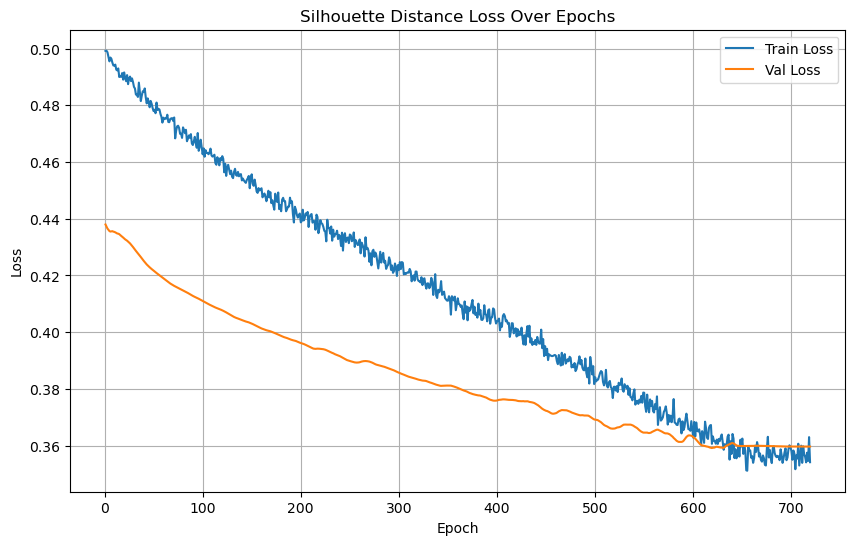

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/154], Loss: 0.2731


Test Batch [20/154], Loss: 0.3513
Test Batch [30/154], Loss: 0.3474


Test Batch [40/154], Loss: 0.2714


Test Batch [50/154], Loss: 0.4219
Test Batch [60/154], Loss: 0.4338


Test Batch [70/154], Loss: 0.2403


Test Batch [80/154], Loss: 0.2034
Test Batch [90/154], Loss: 0.2319
Test Batch [100/154], Loss: 0.1631
Test Batch [110/154], Loss: 0.1762
Test Batch [120/154], Loss: 0.1361


Test Batch [130/154], Loss: 0.2693


Test Batch [140/154], Loss: 0.3644
Test Batch [150/154], Loss: 0.3267

Test Loss: 0.3023


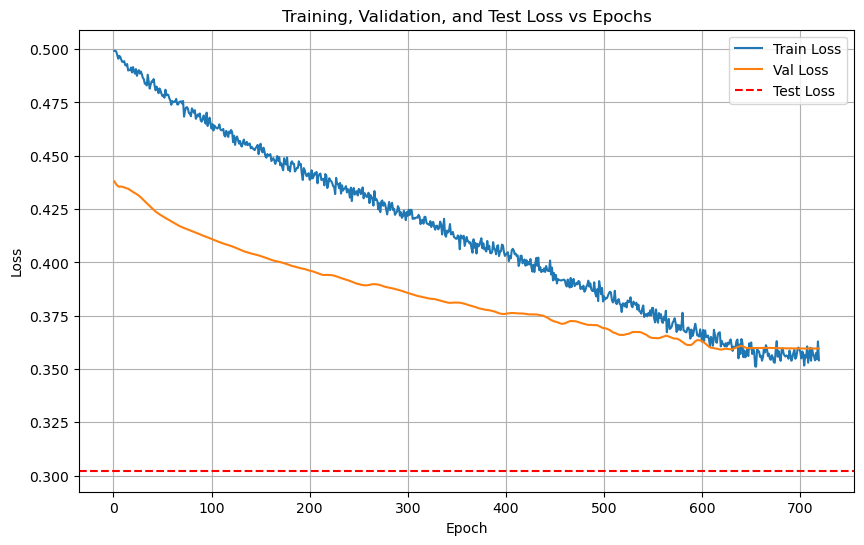

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/154 for test dataset.
  Processed batch 20/154 for test dataset.


  Processed batch 30/154 for test dataset.
  Processed batch 40/154 for test dataset.
  Processed batch 50/154 for test dataset.


  Processed batch 60/154 for test dataset.
  Processed batch 70/154 for test dataset.
  Processed batch 80/154 for test dataset.
  Processed batch 90/154 for test dataset.


  Processed batch 100/154 for test dataset.
  Processed batch 110/154 for test dataset.
  Processed batch 120/154 for test dataset.
  Processed batch 130/154 for test dataset.


  Processed batch 140/154 for test dataset.
  Processed batch 150/154 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 57.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.50      0.20      0.29         5
           2       0.29      0.40      0.33         5
           3       0.80      0.80      0.80         5
           4       0.75      0.60      0.67         5
           5       0.50      0.40      0.44         5
           6       1.00      1.00      1.00         5
           7       0.67      0.80      0.73         5
           8       0.00      0.00      0.00         0
           9       0.38      0.60      0.46         5
          10       0.33      0.40      0.36         5
          11       0.00      0.00      0.00         5
          12       0.71      1.00      0.83         5
          13       0.7

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7601  |  Val Loss: 2.7498
Validation loss improved from inf to 2.7498.
[Epoch 2/1000] Train Loss: 2.7339  |  Val Loss: 2.7254
Validation loss improved from 2.7498 to 2.7254.
[Epoch 3/1000] Train Loss: 2.7082  |  Val Loss: 2.7043
Validation loss improved from 2.7254 to 2.7043.
[Epoch 4/1000] Train Loss: 2.6861  |  Val Loss: 2.6857
Validation loss improved from 2.7043 to 2.6857.
[Epoch 5/1000] Train Loss: 2.6673  |  Val Loss: 2.6668
Validation loss improved from 2.6857 to 2.6668.
[Epoch 6/1000] Train Loss: 2.6467  |  Val Loss: 2.6487
Validation loss improved from 2.6668 to 2.6487.


[Epoch 7/1000] Train Loss: 2.6271  |  Val Loss: 2.6310
Validation loss improved from 2.6487 to 2.6310.
[Epoch 8/1000] Train Loss: 2.6076  |  Val Loss: 2.6139
Validation loss improved from 2.6310 to 2.6139.
[Epoch 9/1000] Train Loss: 2.5878  |  Val Loss: 2.5973
Validation loss improved from 2.6139 to 2.5973.
[Epoch 10/1000] Train Loss: 2.5694  |  Val Loss: 2.5807
Validation loss improved from 2.5973 to 2.5807.
[Epoch 11/1000] Train Loss: 2.5508  |  Val Loss: 2.5640
Validation loss improved from 2.5807 to 2.5640.
[Epoch 12/1000] Train Loss: 2.5325  |  Val Loss: 2.5476
Validation loss improved from 2.5640 to 2.5476.
[Epoch 13/1000] Train Loss: 2.5149  |  Val Loss: 2.5317
Validation loss improved from 2.5476 to 2.5317.
[Epoch 14/1000] Train Loss: 2.4977  |  Val Loss: 2.5164
Validation loss improved from 2.5317 to 2.5164.
[Epoch 15/1000] Train Loss: 2.4804  |  Val Loss: 2.5019
Validation loss improved from 2.5164 to 2.5019.
[Epoch 16/1000] Train Loss: 2.4644  |  Val Loss: 2.4875
Validation 

[Epoch 18/1000] Train Loss: 2.4335  |  Val Loss: 2.4599
Validation loss improved from 2.4734 to 2.4599.


[Epoch 19/1000] Train Loss: 2.4189  |  Val Loss: 2.4472
Validation loss improved from 2.4599 to 2.4472.
[Epoch 20/1000] Train Loss: 2.4035  |  Val Loss: 2.4349
Validation loss improved from 2.4472 to 2.4349.
[Epoch 21/1000] Train Loss: 2.3888  |  Val Loss: 2.4228
Validation loss improved from 2.4349 to 2.4228.
[Epoch 22/1000] Train Loss: 2.3740  |  Val Loss: 2.4112
Validation loss improved from 2.4228 to 2.4112.
[Epoch 23/1000] Train Loss: 2.3593  |  Val Loss: 2.3995
Validation loss improved from 2.4112 to 2.3995.
[Epoch 24/1000] Train Loss: 2.3447  |  Val Loss: 2.3881
Validation loss improved from 2.3995 to 2.3881.
[Epoch 25/1000] Train Loss: 2.3297  |  Val Loss: 2.3769
Validation loss improved from 2.3881 to 2.3769.
[Epoch 26/1000] Train Loss: 2.3154  |  Val Loss: 2.3660
Validation loss improved from 2.3769 to 2.3660.
[Epoch 27/1000] Train Loss: 2.3008  |  Val Loss: 2.3550
Validation loss improved from 2.3660 to 2.3550.


[Epoch 28/1000] Train Loss: 2.2864  |  Val Loss: 2.3443
Validation loss improved from 2.3550 to 2.3443.
[Epoch 29/1000] Train Loss: 2.2720  |  Val Loss: 2.3337
Validation loss improved from 2.3443 to 2.3337.
[Epoch 30/1000] Train Loss: 2.2577  |  Val Loss: 2.3231
Validation loss improved from 2.3337 to 2.3231.
[Epoch 31/1000] Train Loss: 2.2438  |  Val Loss: 2.3124
Validation loss improved from 2.3231 to 2.3124.
[Epoch 32/1000] Train Loss: 2.2296  |  Val Loss: 2.3021
Validation loss improved from 2.3124 to 2.3021.
[Epoch 33/1000] Train Loss: 2.2152  |  Val Loss: 2.2913
Validation loss improved from 2.3021 to 2.2913.
[Epoch 34/1000] Train Loss: 2.2004  |  Val Loss: 2.2804
Validation loss improved from 2.2913 to 2.2804.
[Epoch 35/1000] Train Loss: 2.1859  |  Val Loss: 2.2697
Validation loss improved from 2.2804 to 2.2697.
[Epoch 36/1000] Train Loss: 2.1711  |  Val Loss: 2.2591
Validation loss improved from 2.2697 to 2.2591.


[Epoch 37/1000] Train Loss: 2.1569  |  Val Loss: 2.2483
Validation loss improved from 2.2591 to 2.2483.
[Epoch 38/1000] Train Loss: 2.1425  |  Val Loss: 2.2376
Validation loss improved from 2.2483 to 2.2376.
[Epoch 39/1000] Train Loss: 2.1275  |  Val Loss: 2.2266
Validation loss improved from 2.2376 to 2.2266.
[Epoch 40/1000] Train Loss: 2.1133  |  Val Loss: 2.2152
Validation loss improved from 2.2266 to 2.2152.
[Epoch 41/1000] Train Loss: 2.0978  |  Val Loss: 2.2039
Validation loss improved from 2.2152 to 2.2039.
[Epoch 42/1000] Train Loss: 2.0834  |  Val Loss: 2.1924
Validation loss improved from 2.2039 to 2.1924.
[Epoch 43/1000] Train Loss: 2.0684  |  Val Loss: 2.1809
Validation loss improved from 2.1924 to 2.1809.
[Epoch 44/1000] Train Loss: 2.0536  |  Val Loss: 2.1698
Validation loss improved from 2.1809 to 2.1698.
[Epoch 45/1000] Train Loss: 2.0382  |  Val Loss: 2.1582
Validation loss improved from 2.1698 to 2.1582.
[Epoch 46/1000] Train Loss: 2.0232  |  Val Loss: 2.1459
Validati

[Epoch 47/1000] Train Loss: 2.0078  |  Val Loss: 2.1336
Validation loss improved from 2.1459 to 2.1336.
[Epoch 48/1000] Train Loss: 1.9913  |  Val Loss: 2.1211
Validation loss improved from 2.1336 to 2.1211.
[Epoch 49/1000] Train Loss: 1.9755  |  Val Loss: 2.1085
Validation loss improved from 2.1211 to 2.1085.
[Epoch 50/1000] Train Loss: 1.9600  |  Val Loss: 2.0959
Validation loss improved from 2.1085 to 2.0959.
[Epoch 51/1000] Train Loss: 1.9438  |  Val Loss: 2.0832
Validation loss improved from 2.0959 to 2.0832.
[Epoch 52/1000] Train Loss: 1.9276  |  Val Loss: 2.0703
Validation loss improved from 2.0832 to 2.0703.
[Epoch 53/1000] Train Loss: 1.9112  |  Val Loss: 2.0575
Validation loss improved from 2.0703 to 2.0575.
[Epoch 54/1000] Train Loss: 1.8953  |  Val Loss: 2.0443
Validation loss improved from 2.0575 to 2.0443.


[Epoch 55/1000] Train Loss: 1.8790  |  Val Loss: 2.0314
Validation loss improved from 2.0443 to 2.0314.
[Epoch 56/1000] Train Loss: 1.8623  |  Val Loss: 2.0183
Validation loss improved from 2.0314 to 2.0183.
[Epoch 57/1000] Train Loss: 1.8462  |  Val Loss: 2.0048
Validation loss improved from 2.0183 to 2.0048.
[Epoch 58/1000] Train Loss: 1.8295  |  Val Loss: 1.9917
Validation loss improved from 2.0048 to 1.9917.
[Epoch 59/1000] Train Loss: 1.8130  |  Val Loss: 1.9786
Validation loss improved from 1.9917 to 1.9786.
[Epoch 60/1000] Train Loss: 1.7964  |  Val Loss: 1.9656
Validation loss improved from 1.9786 to 1.9656.
[Epoch 61/1000] Train Loss: 1.7798  |  Val Loss: 1.9523
Validation loss improved from 1.9656 to 1.9523.
[Epoch 62/1000] Train Loss: 1.7630  |  Val Loss: 1.9388
Validation loss improved from 1.9523 to 1.9388.
[Epoch 63/1000] Train Loss: 1.7463  |  Val Loss: 1.9250
Validation loss improved from 1.9388 to 1.9250.


[Epoch 64/1000] Train Loss: 1.7294  |  Val Loss: 1.9116
Validation loss improved from 1.9250 to 1.9116.
[Epoch 65/1000] Train Loss: 1.7126  |  Val Loss: 1.8983
Validation loss improved from 1.9116 to 1.8983.
[Epoch 66/1000] Train Loss: 1.6962  |  Val Loss: 1.8849
Validation loss improved from 1.8983 to 1.8849.
[Epoch 67/1000] Train Loss: 1.6792  |  Val Loss: 1.8715
Validation loss improved from 1.8849 to 1.8715.
[Epoch 68/1000] Train Loss: 1.6625  |  Val Loss: 1.8584
Validation loss improved from 1.8715 to 1.8584.
[Epoch 69/1000] Train Loss: 1.6453  |  Val Loss: 1.8447
Validation loss improved from 1.8584 to 1.8447.
[Epoch 70/1000] Train Loss: 1.6288  |  Val Loss: 1.8315
Validation loss improved from 1.8447 to 1.8315.
[Epoch 71/1000] Train Loss: 1.6119  |  Val Loss: 1.8183
Validation loss improved from 1.8315 to 1.8183.
[Epoch 72/1000] Train Loss: 1.5953  |  Val Loss: 1.8050
Validation loss improved from 1.8183 to 1.8050.


[Epoch 73/1000] Train Loss: 1.5783  |  Val Loss: 1.7920
Validation loss improved from 1.8050 to 1.7920.
[Epoch 74/1000] Train Loss: 1.5615  |  Val Loss: 1.7788
Validation loss improved from 1.7920 to 1.7788.
[Epoch 75/1000] Train Loss: 1.5451  |  Val Loss: 1.7658
Validation loss improved from 1.7788 to 1.7658.
[Epoch 76/1000] Train Loss: 1.5278  |  Val Loss: 1.7525
Validation loss improved from 1.7658 to 1.7525.
[Epoch 77/1000] Train Loss: 1.5114  |  Val Loss: 1.7392
Validation loss improved from 1.7525 to 1.7392.
[Epoch 78/1000] Train Loss: 1.4946  |  Val Loss: 1.7263
Validation loss improved from 1.7392 to 1.7263.
[Epoch 79/1000] Train Loss: 1.4784  |  Val Loss: 1.7134
Validation loss improved from 1.7263 to 1.7134.
[Epoch 80/1000] Train Loss: 1.4620  |  Val Loss: 1.7007
Validation loss improved from 1.7134 to 1.7007.
[Epoch 81/1000] Train Loss: 1.4456  |  Val Loss: 1.6872
Validation loss improved from 1.7007 to 1.6872.
[Epoch 82/1000] Train Loss: 1.4293  |  Val Loss: 1.6749
Validati

[Epoch 83/1000] Train Loss: 1.4136  |  Val Loss: 1.6627
Validation loss improved from 1.6749 to 1.6627.
[Epoch 84/1000] Train Loss: 1.3974  |  Val Loss: 1.6511
Validation loss improved from 1.6627 to 1.6511.
[Epoch 85/1000] Train Loss: 1.3815  |  Val Loss: 1.6387
Validation loss improved from 1.6511 to 1.6387.
[Epoch 86/1000] Train Loss: 1.3660  |  Val Loss: 1.6273
Validation loss improved from 1.6387 to 1.6273.
[Epoch 87/1000] Train Loss: 1.3503  |  Val Loss: 1.6148
Validation loss improved from 1.6273 to 1.6148.
[Epoch 88/1000] Train Loss: 1.3348  |  Val Loss: 1.6033
Validation loss improved from 1.6148 to 1.6033.
[Epoch 89/1000] Train Loss: 1.3194  |  Val Loss: 1.5915
Validation loss improved from 1.6033 to 1.5915.
[Epoch 90/1000] Train Loss: 1.3045  |  Val Loss: 1.5795
Validation loss improved from 1.5915 to 1.5795.
[Epoch 91/1000] Train Loss: 1.2897  |  Val Loss: 1.5683
Validation loss improved from 1.5795 to 1.5683.
[Epoch 92/1000] Train Loss: 1.2744  |  Val Loss: 1.5574
Validati

[Epoch 93/1000] Train Loss: 1.2599  |  Val Loss: 1.5458
Validation loss improved from 1.5574 to 1.5458.
[Epoch 94/1000] Train Loss: 1.2452  |  Val Loss: 1.5355
Validation loss improved from 1.5458 to 1.5355.
[Epoch 95/1000] Train Loss: 1.2309  |  Val Loss: 1.5251
Validation loss improved from 1.5355 to 1.5251.
[Epoch 96/1000] Train Loss: 1.2166  |  Val Loss: 1.5148
Validation loss improved from 1.5251 to 1.5148.
[Epoch 97/1000] Train Loss: 1.2026  |  Val Loss: 1.5055
Validation loss improved from 1.5148 to 1.5055.
[Epoch 98/1000] Train Loss: 1.1886  |  Val Loss: 1.4952
Validation loss improved from 1.5055 to 1.4952.
[Epoch 99/1000] Train Loss: 1.1756  |  Val Loss: 1.4862
Validation loss improved from 1.4952 to 1.4862.
[Epoch 100/1000] Train Loss: 1.1617  |  Val Loss: 1.4759
Validation loss improved from 1.4862 to 1.4759.


[Epoch 101/1000] Train Loss: 1.1487  |  Val Loss: 1.4668
Validation loss improved from 1.4759 to 1.4668.
[Epoch 102/1000] Train Loss: 1.1347  |  Val Loss: 1.4573
Validation loss improved from 1.4668 to 1.4573.
[Epoch 103/1000] Train Loss: 1.1223  |  Val Loss: 1.4482
Validation loss improved from 1.4573 to 1.4482.
[Epoch 104/1000] Train Loss: 1.1096  |  Val Loss: 1.4396
Validation loss improved from 1.4482 to 1.4396.
[Epoch 105/1000] Train Loss: 1.0965  |  Val Loss: 1.4305
Validation loss improved from 1.4396 to 1.4305.
[Epoch 106/1000] Train Loss: 1.0836  |  Val Loss: 1.4220
Validation loss improved from 1.4305 to 1.4220.
[Epoch 107/1000] Train Loss: 1.0711  |  Val Loss: 1.4137
Validation loss improved from 1.4220 to 1.4137.
[Epoch 108/1000] Train Loss: 1.0599  |  Val Loss: 1.4059
Validation loss improved from 1.4137 to 1.4059.
[Epoch 109/1000] Train Loss: 1.0476  |  Val Loss: 1.3982
Validation loss improved from 1.4059 to 1.3982.
[Epoch 110/1000] Train Loss: 1.0361  |  Val Loss: 1.390

[Epoch 113/1000] Train Loss: 1.0022  |  Val Loss: 1.3685
Validation loss improved from 1.3763 to 1.3685.
[Epoch 114/1000] Train Loss: 0.9915  |  Val Loss: 1.3611
Validation loss improved from 1.3685 to 1.3611.
[Epoch 115/1000] Train Loss: 0.9813  |  Val Loss: 1.3545
Validation loss improved from 1.3611 to 1.3545.
[Epoch 116/1000] Train Loss: 0.9704  |  Val Loss: 1.3487
Validation loss improved from 1.3545 to 1.3487.
[Epoch 117/1000] Train Loss: 0.9605  |  Val Loss: 1.3430
Validation loss improved from 1.3487 to 1.3430.
[Epoch 118/1000] Train Loss: 0.9506  |  Val Loss: 1.3371
Validation loss improved from 1.3430 to 1.3371.
[Epoch 119/1000] Train Loss: 0.9409  |  Val Loss: 1.3306
Validation loss improved from 1.3371 to 1.3306.


[Epoch 120/1000] Train Loss: 0.9315  |  Val Loss: 1.3240
Validation loss improved from 1.3306 to 1.3240.
[Epoch 121/1000] Train Loss: 0.9229  |  Val Loss: 1.3177
Validation loss improved from 1.3240 to 1.3177.
[Epoch 122/1000] Train Loss: 0.9130  |  Val Loss: 1.3131
Validation loss improved from 1.3177 to 1.3131.
[Epoch 123/1000] Train Loss: 0.9045  |  Val Loss: 1.3081
Validation loss improved from 1.3131 to 1.3081.
[Epoch 124/1000] Train Loss: 0.8960  |  Val Loss: 1.3037
Validation loss improved from 1.3081 to 1.3037.
[Epoch 125/1000] Train Loss: 0.8874  |  Val Loss: 1.2996
Validation loss improved from 1.3037 to 1.2996.
[Epoch 126/1000] Train Loss: 0.8793  |  Val Loss: 1.2942
Validation loss improved from 1.2996 to 1.2942.
[Epoch 127/1000] Train Loss: 0.8721  |  Val Loss: 1.2886
Validation loss improved from 1.2942 to 1.2886.
[Epoch 128/1000] Train Loss: 0.8632  |  Val Loss: 1.2846
Validation loss improved from 1.2886 to 1.2846.
[Epoch 129/1000] Train Loss: 0.8554  |  Val Loss: 1.281

[Epoch 131/1000] Train Loss: 0.8405  |  Val Loss: 1.2728
Validation loss improved from 1.2771 to 1.2728.
[Epoch 132/1000] Train Loss: 0.8336  |  Val Loss: 1.2683
Validation loss improved from 1.2728 to 1.2683.
[Epoch 133/1000] Train Loss: 0.8266  |  Val Loss: 1.2648
Validation loss improved from 1.2683 to 1.2648.
[Epoch 134/1000] Train Loss: 0.8200  |  Val Loss: 1.2608
Validation loss improved from 1.2648 to 1.2608.
[Epoch 135/1000] Train Loss: 0.8134  |  Val Loss: 1.2577
Validation loss improved from 1.2608 to 1.2577.
[Epoch 136/1000] Train Loss: 0.8064  |  Val Loss: 1.2555
Validation loss improved from 1.2577 to 1.2555.
[Epoch 137/1000] Train Loss: 0.8009  |  Val Loss: 1.2535
Validation loss improved from 1.2555 to 1.2535.
[Epoch 138/1000] Train Loss: 0.7943  |  Val Loss: 1.2490
Validation loss improved from 1.2535 to 1.2490.


[Epoch 139/1000] Train Loss: 0.7875  |  Val Loss: 1.2454
Validation loss improved from 1.2490 to 1.2454.
[Epoch 140/1000] Train Loss: 0.7819  |  Val Loss: 1.2424
Validation loss improved from 1.2454 to 1.2424.
[Epoch 141/1000] Train Loss: 0.7756  |  Val Loss: 1.2387
Validation loss improved from 1.2424 to 1.2387.
[Epoch 142/1000] Train Loss: 0.7704  |  Val Loss: 1.2353
Validation loss improved from 1.2387 to 1.2353.
[Epoch 143/1000] Train Loss: 0.7646  |  Val Loss: 1.2343
Validation loss improved from 1.2353 to 1.2343.
[Epoch 144/1000] Train Loss: 0.7587  |  Val Loss: 1.2320
Validation loss improved from 1.2343 to 1.2320.
[Epoch 145/1000] Train Loss: 0.7533  |  Val Loss: 1.2303
Validation loss improved from 1.2320 to 1.2303.
[Epoch 146/1000] Train Loss: 0.7481  |  Val Loss: 1.2269
Validation loss improved from 1.2303 to 1.2269.
[Epoch 147/1000] Train Loss: 0.7426  |  Val Loss: 1.2234
Validation loss improved from 1.2269 to 1.2234.
[Epoch 148/1000] Train Loss: 0.7376  |  Val Loss: 1.221

[Epoch 150/1000] Train Loss: 0.7280  |  Val Loss: 1.2163
Validation loss improved from 1.2177 to 1.2163.
[Epoch 151/1000] Train Loss: 0.7222  |  Val Loss: 1.2141
Validation loss improved from 1.2163 to 1.2141.
[Epoch 152/1000] Train Loss: 0.7178  |  Val Loss: 1.2124
Validation loss improved from 1.2141 to 1.2124.
[Epoch 153/1000] Train Loss: 0.7131  |  Val Loss: 1.2102
Validation loss improved from 1.2124 to 1.2102.
[Epoch 154/1000] Train Loss: 0.7086  |  Val Loss: 1.2077
Validation loss improved from 1.2102 to 1.2077.
[Epoch 155/1000] Train Loss: 0.7040  |  Val Loss: 1.2052
Validation loss improved from 1.2077 to 1.2052.
[Epoch 156/1000] Train Loss: 0.7000  |  Val Loss: 1.2033
Validation loss improved from 1.2052 to 1.2033.
[Epoch 157/1000] Train Loss: 0.6952  |  Val Loss: 1.2021
Validation loss improved from 1.2033 to 1.2021.


[Epoch 158/1000] Train Loss: 0.6925  |  Val Loss: 1.2019
Validation loss improved from 1.2021 to 1.2019.
[Epoch 159/1000] Train Loss: 0.6869  |  Val Loss: 1.1993
Validation loss improved from 1.2019 to 1.1993.
[Epoch 160/1000] Train Loss: 0.6829  |  Val Loss: 1.1984
Validation loss improved from 1.1993 to 1.1984.
[Epoch 161/1000] Train Loss: 0.6788  |  Val Loss: 1.1959
Validation loss improved from 1.1984 to 1.1959.
[Epoch 162/1000] Train Loss: 0.6749  |  Val Loss: 1.1932
Validation loss improved from 1.1959 to 1.1932.
[Epoch 163/1000] Train Loss: 0.6720  |  Val Loss: 1.1921
Validation loss improved from 1.1932 to 1.1921.
[Epoch 164/1000] Train Loss: 0.6673  |  Val Loss: 1.1905
Validation loss improved from 1.1921 to 1.1905.
[Epoch 165/1000] Train Loss: 0.6636  |  Val Loss: 1.1892
Validation loss improved from 1.1905 to 1.1892.
[Epoch 166/1000] Train Loss: 0.6599  |  Val Loss: 1.1864
Validation loss improved from 1.1892 to 1.1864.
[Epoch 167/1000] Train Loss: 0.6561  |  Val Loss: 1.185

[Epoch 170/1000] Train Loss: 0.6454  |  Val Loss: 1.1820
Validation loss improved from 1.1834 to 1.1820.
[Epoch 171/1000] Train Loss: 0.6421  |  Val Loss: 1.1813
Validation loss improved from 1.1820 to 1.1813.
[Epoch 172/1000] Train Loss: 0.6392  |  Val Loss: 1.1810
Validation loss improved from 1.1813 to 1.1810.
[Epoch 173/1000] Train Loss: 0.6353  |  Val Loss: 1.1806
Validation loss improved from 1.1810 to 1.1806.
[Epoch 174/1000] Train Loss: 0.6321  |  Val Loss: 1.1794
Validation loss improved from 1.1806 to 1.1794.
[Epoch 175/1000] Train Loss: 0.6288  |  Val Loss: 1.1777
Validation loss improved from 1.1794 to 1.1777.
[Epoch 176/1000] Train Loss: 0.6264  |  Val Loss: 1.1758
Validation loss improved from 1.1777 to 1.1758.


[Epoch 177/1000] Train Loss: 0.6227  |  Val Loss: 1.1743
Validation loss improved from 1.1758 to 1.1743.
[Epoch 178/1000] Train Loss: 0.6196  |  Val Loss: 1.1746
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 179/1000] Train Loss: 0.6165  |  Val Loss: 1.1746
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 180/1000] Train Loss: 0.6134  |  Val Loss: 1.1741
Validation loss improved from 1.1743 to 1.1741.
[Epoch 181/1000] Train Loss: 0.6107  |  Val Loss: 1.1736
Validation loss improved from 1.1741 to 1.1736.
[Epoch 182/1000] Train Loss: 0.6080  |  Val Loss: 1.1724
Validation loss improved from 1.1736 to 1.1724.
[Epoch 183/1000] Train Loss: 0.6050  |  Val Loss: 1.1706
Validation loss improved from 1.1724 to 1.1706.
[Epoch 184/1000] Train Loss: 0.6022  |  Val Loss: 1.1694
Validation loss improved from 1.1706 to 1.1694.
[Epoch 185/1000] Train Loss: 0.5992  |  Val Loss: 1.1699
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 186/1000] Train Loss: 0.5966  

[Epoch 189/1000] Train Loss: 0.5885  |  Val Loss: 1.1685
Validation loss improved from 1.1688 to 1.1685.
[Epoch 190/1000] Train Loss: 0.5856  |  Val Loss: 1.1684
Validation loss improved from 1.1685 to 1.1684.
[Epoch 191/1000] Train Loss: 0.5835  |  Val Loss: 1.1676
Validation loss improved from 1.1684 to 1.1676.
[Epoch 192/1000] Train Loss: 0.5808  |  Val Loss: 1.1660
Validation loss improved from 1.1676 to 1.1660.
[Epoch 193/1000] Train Loss: 0.5782  |  Val Loss: 1.1657
Validation loss improved from 1.1660 to 1.1657.


[Epoch 194/1000] Train Loss: 0.5763  |  Val Loss: 1.1667
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 195/1000] Train Loss: 0.5737  |  Val Loss: 1.1653
Validation loss improved from 1.1657 to 1.1653.
[Epoch 196/1000] Train Loss: 0.5708  |  Val Loss: 1.1652
Validation loss improved from 1.1653 to 1.1652.
[Epoch 197/1000] Train Loss: 0.5687  |  Val Loss: 1.1647
Validation loss improved from 1.1652 to 1.1647.
[Epoch 198/1000] Train Loss: 0.5665  |  Val Loss: 1.1650
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 199/1000] Train Loss: 0.5636  |  Val Loss: 1.1650
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 200/1000] Train Loss: 0.5614  |  Val Loss: 1.1633
Validation loss improved from 1.1647 to 1.1633.
[Epoch 201/1000] Train Loss: 0.5592  |  Val Loss: 1.1630
Validation loss improved from 1.1633 to 1.1630.
[Epoch 202/1000] Train Loss: 0.5570  |  Val Loss: 1.1635
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 203/1000] Train Loss: 0.

[Epoch 209/1000] Train Loss: 0.5418  |  Val Loss: 1.1620
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 210/1000] Train Loss: 0.5398  |  Val Loss: 1.1608
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 211/1000] Train Loss: 0.5372  |  Val Loss: 1.1608
Validation loss improved from 1.1608 to 1.1608.
[Epoch 212/1000] Train Loss: 0.5354  |  Val Loss: 1.1606
Validation loss improved from 1.1608 to 1.1606.


[Epoch 213/1000] Train Loss: 0.5331  |  Val Loss: 1.1610
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 214/1000] Train Loss: 0.5311  |  Val Loss: 1.1603
Validation loss improved from 1.1606 to 1.1603.
[Epoch 215/1000] Train Loss: 0.5294  |  Val Loss: 1.1602
Validation loss improved from 1.1603 to 1.1602.
[Epoch 216/1000] Train Loss: 0.5271  |  Val Loss: 1.1609
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 217/1000] Train Loss: 0.5260  |  Val Loss: 1.1608
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 218/1000] Train Loss: 0.5231  |  Val Loss: 1.1613
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 219/1000] Train Loss: 0.5214  |  Val Loss: 1.1607
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 220/1000] Train Loss: 0.5192  |  Val Loss: 1.1601
Validation loss improved from 1.1602 to 1.1601.
[Epoch 221/1000] Train Loss: 0.5175  |  Val Loss: 1.1598
Validation loss improved from 1.1601 to 1.1598.
[Epoch 222/1000] Train Lo

[Epoch 227/1000] Train Loss: 0.5062  |  Val Loss: 1.1617
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 228/1000] Train Loss: 0.5045  |  Val Loss: 1.1619
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 229/1000] Train Loss: 0.5027  |  Val Loss: 1.1619
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 230/1000] Train Loss: 0.5012  |  Val Loss: 1.1613
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 231/1000] Train Loss: 0.4994  |  Val Loss: 1.1613
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 232/1000] Train Loss: 0.4990  |  Val Loss: 1.1627
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 233/1000] Train Loss: 0.4958  |  Val Loss: 1.1629
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 234/1000] Train Loss: 0.4939  |  Val Loss: 1.1619
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 235/1000] Train Loss: 0.4924  |  Val Loss: 1.1633
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 236/1000] Train Loss: 0.4907  |  Val Loss: 1.1631
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 237/1000] Train Loss: 0.4890  |  Val Loss: 1.1632
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 238/1000] Train Loss: 0.4874  |  Val Loss: 1.1625
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 239/1000] Train Loss: 0.4857  |  Val Loss: 1.1629
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 240/1000] Train Loss: 0.4840  |  Val Loss: 1.1637
!! Validation loss did NOT improve !! Patience:

[Epoch 245/1000] Train Loss: 0.4762  |  Val Loss: 1.1653
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 246/1000] Train Loss: 0.4746  |  Val Loss: 1.1658
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 247/1000] Train Loss: 0.4735  |  Val Loss: 1.1661
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 248/1000] Train Loss: 0.4718  |  Val Loss: 1.1666
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 249/1000] Train Loss: 0.4697  |  Val Loss: 1.1672
!! Validation loss did NOT improve !! Patience: 28/100


[Epoch 250/1000] Train Loss: 0.4683  |  Val Loss: 1.1680
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 251/1000] Train Loss: 0.4677  |  Val Loss: 1.1684
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 252/1000] Train Loss: 0.4662  |  Val Loss: 1.1699
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 253/1000] Train Loss: 0.4643  |  Val Loss: 1.1694
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 254/1000] Train Loss: 0.4627  |  Val Loss: 1.1699
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 255/1000] Train Loss: 0.4610  |  Val Loss: 1.1712
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 256/1000] Train Loss: 0.4597  |  Val Loss: 1.1709
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 257/1000] Train Loss: 0.4583  |  Val Loss: 1.1714
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 258/1000] Train Loss: 0.4569  |  Val Loss: 1.1722
!! Validation loss did NOT improve !! Patience:

[Epoch 263/1000] Train Loss: 0.4497  |  Val Loss: 1.1753
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 264/1000] Train Loss: 0.4486  |  Val Loss: 1.1758
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 265/1000] Train Loss: 0.4474  |  Val Loss: 1.1762
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 266/1000] Train Loss: 0.4461  |  Val Loss: 1.1762
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 267/1000] Train Loss: 0.4444  |  Val Loss: 1.1771
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 268/1000] Train Loss: 0.4431  |  Val Loss: 1.1785
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 269/1000] Train Loss: 0.4418  |  Val Loss: 1.1794
!! Validation loss did NOT improve !! Patience: 48/100


[Epoch 270/1000] Train Loss: 0.4407  |  Val Loss: 1.1795
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 271/1000] Train Loss: 0.4395  |  Val Loss: 1.1792
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 272/1000] Train Loss: 0.4378  |  Val Loss: 1.1805
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 273/1000] Train Loss: 0.4368  |  Val Loss: 1.1810
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 274/1000] Train Loss: 0.4363  |  Val Loss: 1.1826
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 275/1000] Train Loss: 0.4342  |  Val Loss: 1.1826
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 276/1000] Train Loss: 0.4333  |  Val Loss: 1.1826
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 277/1000] Train Loss: 0.4320  |  Val Loss: 1.1848
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 278/1000] Train Loss: 0.4305  |  Val Loss: 1.1853
!! Validation loss did NOT improve !! Patience:

[Epoch 281/1000] Train Loss: 0.4266  |  Val Loss: 1.1878
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 282/1000] Train Loss: 0.4259  |  Val Loss: 1.1883
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 283/1000] Train Loss: 0.4244  |  Val Loss: 1.1885
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 284/1000] Train Loss: 0.4235  |  Val Loss: 1.1905
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 285/1000] Train Loss: 0.4226  |  Val Loss: 1.1921
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 286/1000] Train Loss: 0.4211  |  Val Loss: 1.1912
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 287/1000] Train Loss: 0.4202  |  Val Loss: 1.1938
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 288/1000] Train Loss: 0.4188  |  Val Loss: 1.1937
!! Validation loss did NOT improve !! Patience: 67/100


[Epoch 289/1000] Train Loss: 0.4177  |  Val Loss: 1.1946
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 290/1000] Train Loss: 0.4163  |  Val Loss: 1.1946
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 291/1000] Train Loss: 0.4153  |  Val Loss: 1.1945
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 292/1000] Train Loss: 0.4145  |  Val Loss: 1.1965
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 293/1000] Train Loss: 0.4131  |  Val Loss: 1.1959
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 294/1000] Train Loss: 0.4120  |  Val Loss: 1.1972
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 295/1000] Train Loss: 0.4106  |  Val Loss: 1.1988
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 296/1000] Train Loss: 0.4096  |  Val Loss: 1.1999
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 297/1000] Train Loss: 0.4084  |  Val Loss: 1.1996
!! Validation loss did NOT improve !! Patience:

[Epoch 299/1000] Train Loss: 0.4073  |  Val Loss: 1.2041
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 300/1000] Train Loss: 0.4055  |  Val Loss: 1.2032
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 301/1000] Train Loss: 0.4047  |  Val Loss: 1.2034
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 302/1000] Train Loss: 0.4030  |  Val Loss: 1.2044
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 303/1000] Train Loss: 0.4020  |  Val Loss: 1.2051
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 304/1000] Train Loss: 0.4010  |  Val Loss: 1.2048
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 305/1000] Train Loss: 0.4002  |  Val Loss: 1.2066
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 306/1000] Train Loss: 0.3992  |  Val Loss: 1.2084
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 307/1000] Train Loss: 0.3979  |  Val Loss: 1.2084
!! Validation loss did NOT improve !! Patience:

[Epoch 308/1000] Train Loss: 0.3973  |  Val Loss: 1.2075
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 309/1000] Train Loss: 0.3960  |  Val Loss: 1.2088
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 310/1000] Train Loss: 0.3953  |  Val Loss: 1.2112
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 311/1000] Train Loss: 0.3939  |  Val Loss: 1.2141
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 312/1000] Train Loss: 0.3928  |  Val Loss: 1.2146
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 313/1000] Train Loss: 0.3918  |  Val Loss: 1.2161
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 314/1000] Train Loss: 0.3909  |  Val Loss: 1.2165
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 315/1000] Train Loss: 0.3904  |  Val Loss: 1.2183
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 316/1000] Train Loss: 0.3892  |  Val Loss: 1.2180
!! Validation loss did NOT improve !! Patience:

[Epoch 319/1000] Train Loss: 0.3862  |  Val Loss: 1.2211
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 320/1000] Train Loss: 0.3854  |  Val Loss: 1.2232
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 321/1000] Train Loss: 0.3840  |  Val Loss: 1.2244
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 321 !!
No improvement for 100 epochs.


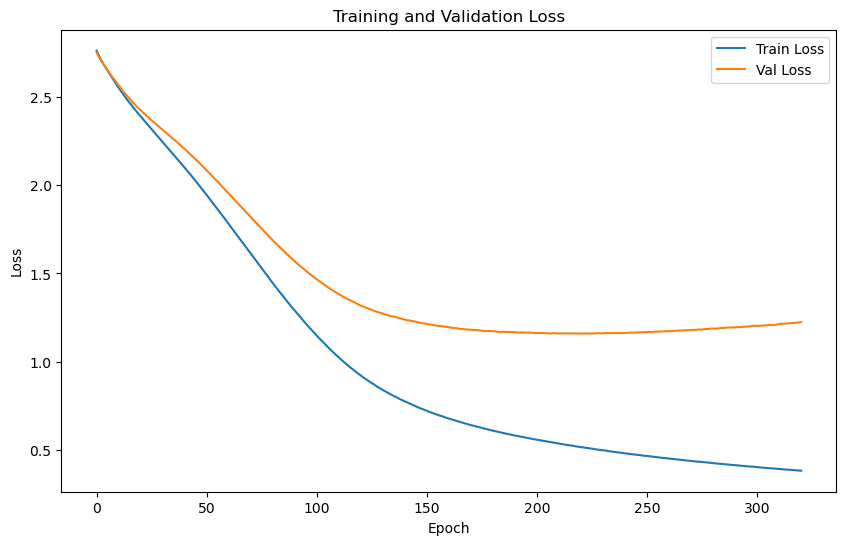

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.4124 | Test Accuracy: 53.82%


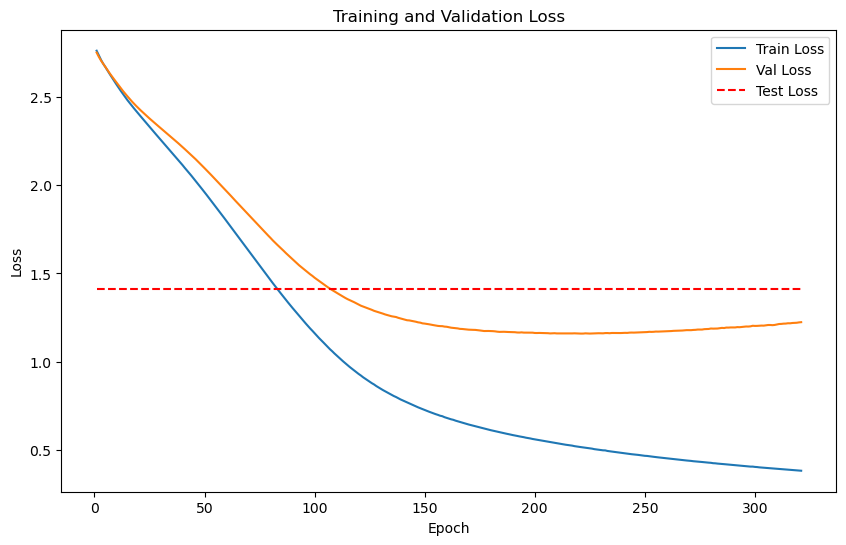

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


C:\Users\vella\AppData\Local\Temp\ipykernel_23004\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


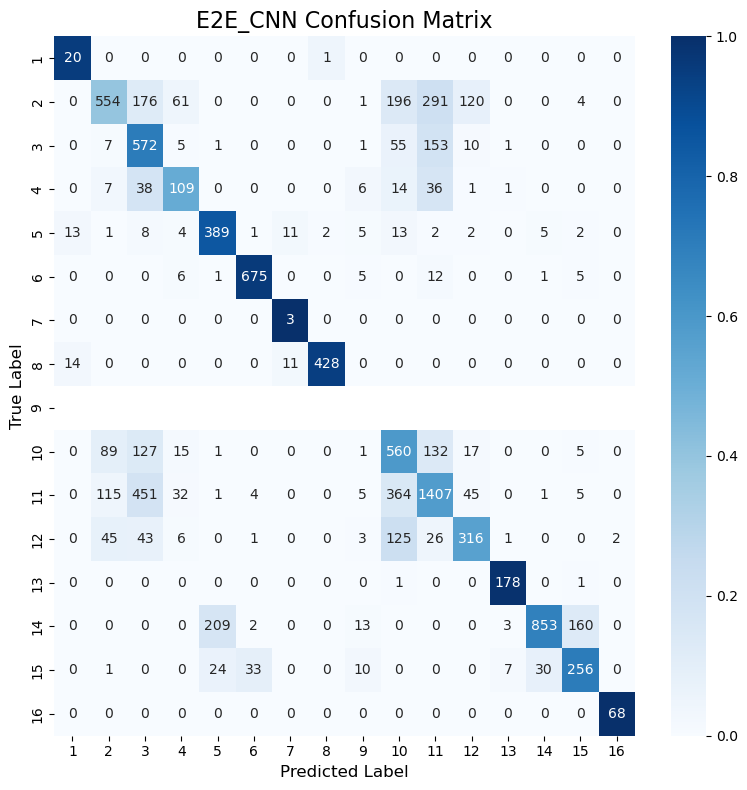

Classification Accuracy: 64.83%


C:\Users\vella\AppData\Local\Temp\ipykernel_23004\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


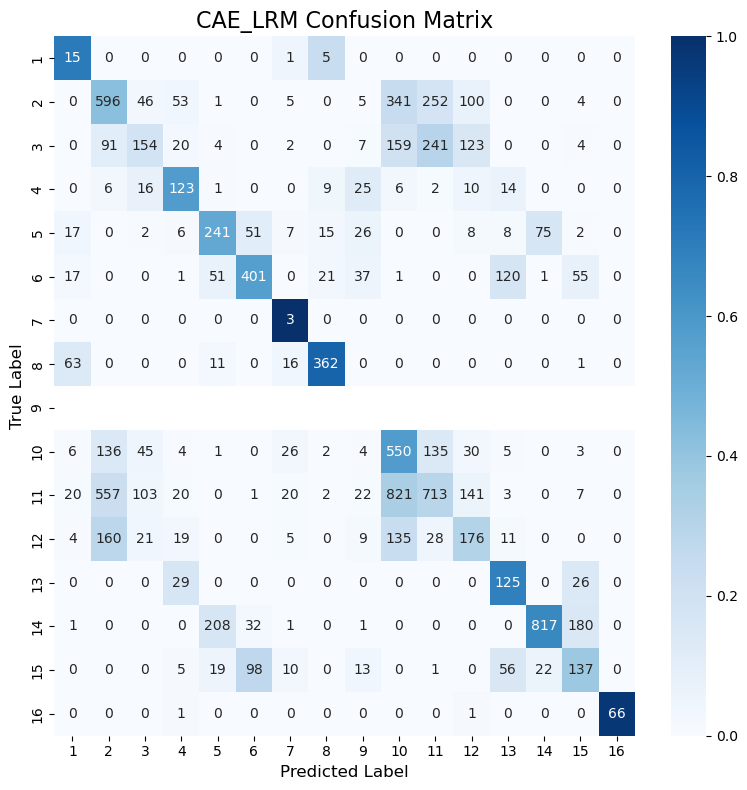

Classification Accuracy: 45.45%


C:\Users\vella\AppData\Local\Temp\ipykernel_23004\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


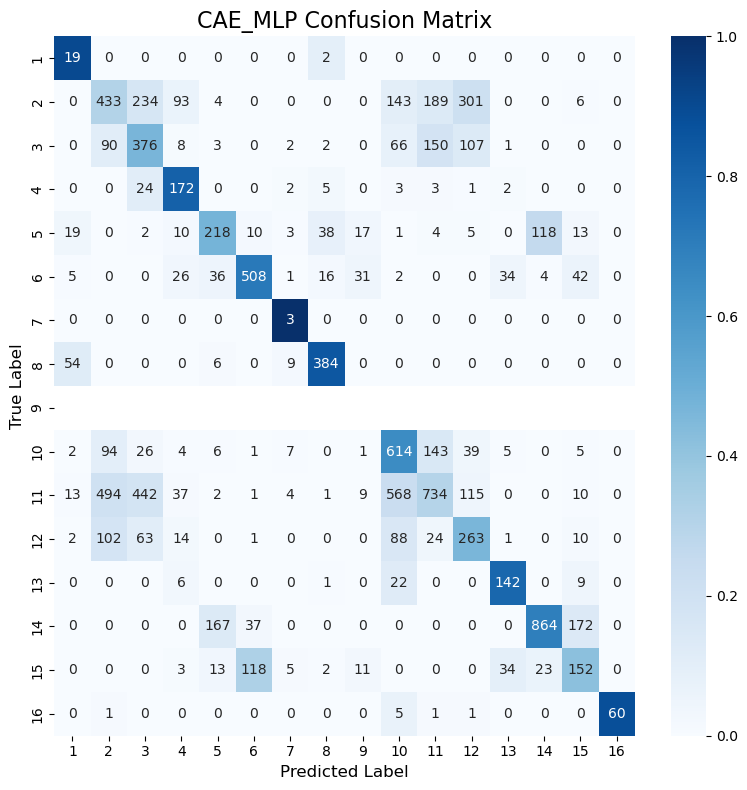

Classification Accuracy: 50.15%


C:\Users\vella\AppData\Local\Temp\ipykernel_23004\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


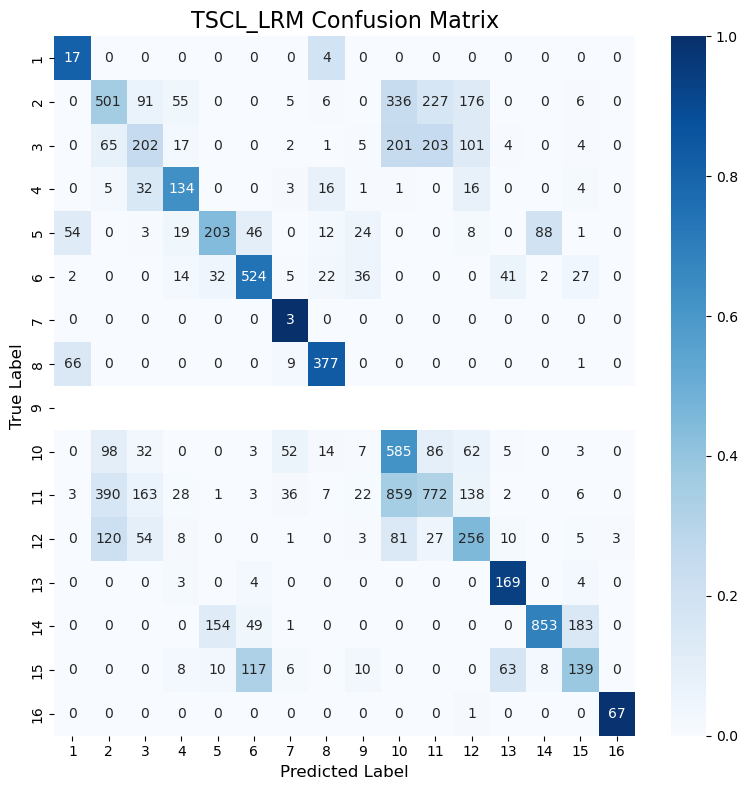

Classification Accuracy: 48.73%


C:\Users\vella\AppData\Local\Temp\ipykernel_23004\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


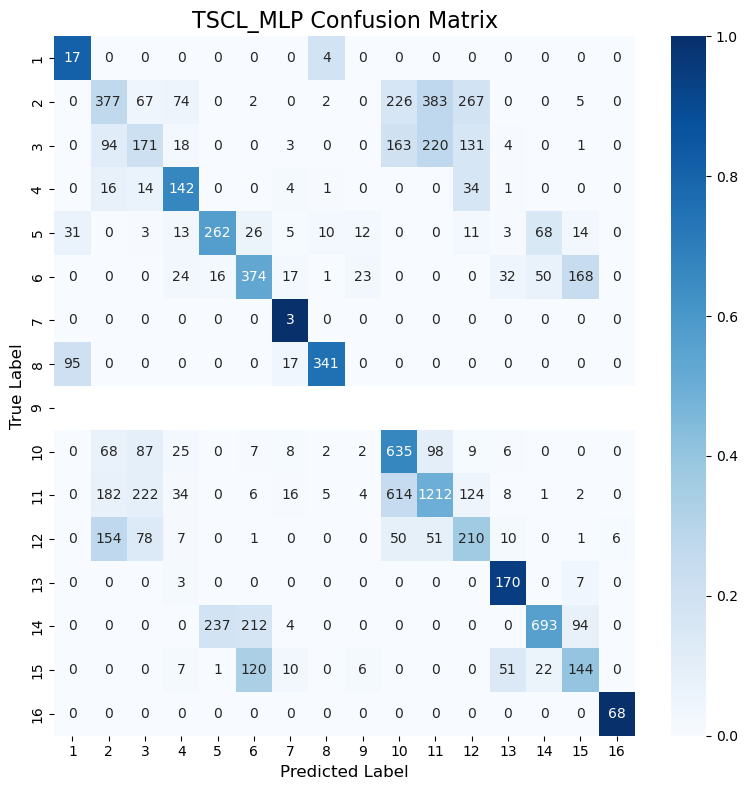

Classification Accuracy: 48.90%


C:\Users\vella\AppData\Local\Temp\ipykernel_23004\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


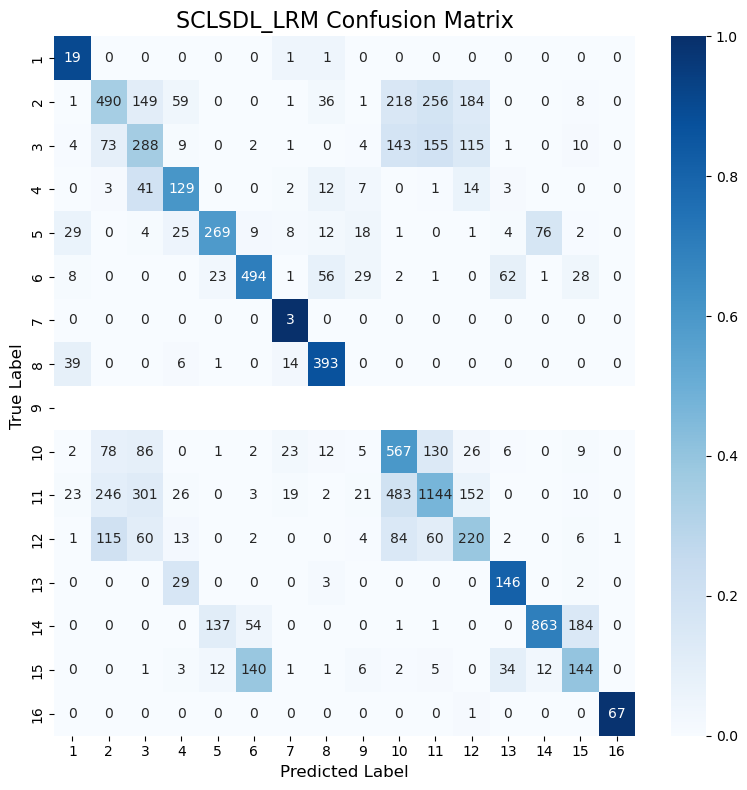

Classification Accuracy: 53.14%


C:\Users\vella\AppData\Local\Temp\ipykernel_23004\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


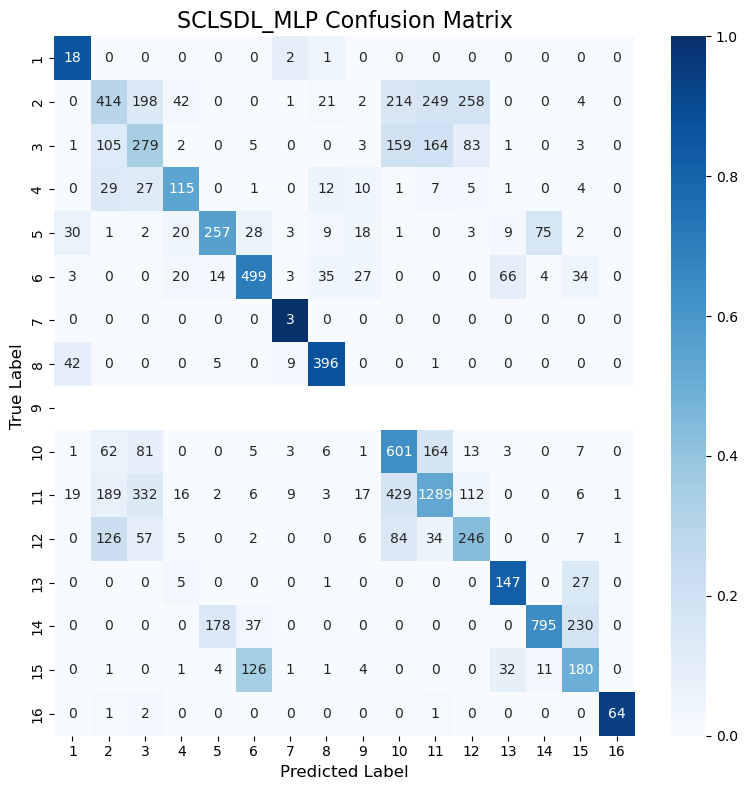

Classification Accuracy: 53.82%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          64.83
1    LRM (CAE)          45.45
2    MLP (CAE)          50.15
3     TSCL LRM          48.73
4     TSCL MLP          48.90
5  SCL_SDL LRM          53.14
6  SCL_SDL MLP          53.82

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          64.83
6  SCL_SDL MLP          53.82
5  SCL_SDL LRM          53.14
2    MLP (CAE)          50.15
4     TSCL MLP          48.90
3     TSCL LRM          48.73
1    LRM (CAE)          45.45
